## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
# Librerías estándar de Python
import datetime
import os
import sys
import subprocess
import warnings
import re
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from typing import List, Tuple, Optional
from enum import Enum
from math import floor

# Librerías de terceros
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import brentq
import pulp
from pulp import *

# Importar funciones de valoración desde módulo externo
from descuento import MetodoDescuento, calcular_valor_presente, interpolar_factor_descuento

In [2]:
# Estilo
plt.style.use('dark_background')

In [3]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

##### <font color=#CC6600>NOTA MIA: Análisis descriptivo</font>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [4]:
# Check current working directory
print("Current working directory:", os.getcwd())

df = pd.read_csv('../data/universo.csv', engine='python', sep=None, encoding='utf-8-sig')

Current working directory: c:\Users\diego\MIAX\02-renta-fija\src


#### <font color=#808080>Divisas</font>

In [5]:
# ver los valores distintos de divisas del daataframe
divisas = df['Ccy'].unique()
print("Divisas en el DataFrame:", divisas)

Divisas en el DataFrame: ['EUR']


#### <font color=#808080>Tipos de bono</font>

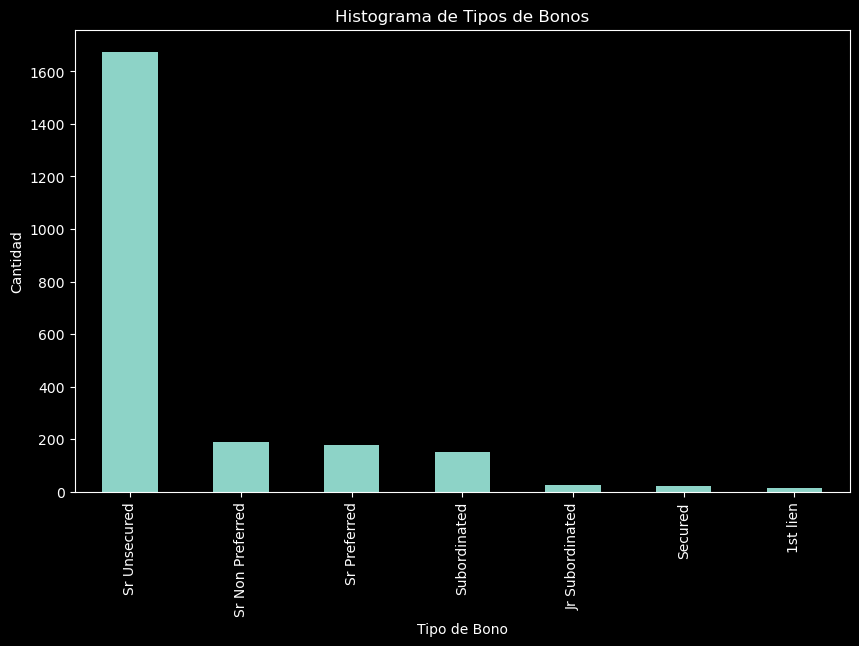

In [6]:
tipo_bono = df['Seniority']
#hisotgrama con conteo de tipos de bonos
plt.figure(figsize=(10,6))
tipo_bono.value_counts().plot(kind='bar')
plt.title('Histograma de Tipos de Bonos')
plt.xlabel('Tipo de Bono')
plt.ylabel('Cantidad')
plt.show()

In [7]:
# contar el numero de cupones por tipo
num_tipo_cupon = df['Coupon Type'].value_counts()
num_tipo_cupon

Coupon Type
FIXED       1910
VARIABLE     345
Name: count, dtype: int64

In [8]:
# Bonos perpetuos donde maturity date es null
bonos_perpetuos = df[df['Maturity'].isnull()]
bonos_perpetuos

,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
26,XS1115498260,ORAFP 5 PERP,EUR,102.19020,ORANGE SA,Communications,NaN,5.000,BBB-,2.142390e-05,...,Y,01/10/2026,Jr Subordinated,1,VARIABLE,01/10/2015,NaN,01/10/2014,101.894,102.486
54,XS1206541366,VW 3 ½ PERP,EUR,96.28500,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,3.500,BBB-,4.212007e-02,...,Y,20/03/2030,Jr Subordinated,1,VARIABLE,20/03/2016,NaN,20/03/2015,96.012,96.558
120,XS1492580516,SLHNVX 4 ½ PERP,EUR,102.88900,ELM BV (SWISS LIFE),Financial,NaN,4.500,NR,2.039300e-07,...,Y,19/05/2027,Subordinated,1,VARIABLE,19/05/2017,NaN,27/09/2016,102.597,103.182
221,XS1629774230,VW 3 ⅞ PERP,EUR,100.09400,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,3.875,BBB-,4.212007e-02,...,Y,14/06/2027,Jr Subordinated,1,VARIABLE,14/06/2018,NaN,14/06/2017,99.814,100.373
358,XS1799939027,VW 4 ⅝ PERP,EUR,101.62600,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,4.625,BBB-,4.212007e-02,...,Y,27/06/2028,Jr Subordinated,1,VARIABLE,27/06/2019,NaN,27/06/2018,101.345,101.906
577,FR0013447877,ORAFP 1 ¾ PERP,EUR,98.31100,ORANGE SA,Communications,NaN,1.750,BBB-,2.142390e-05,...,Y,19/12/2026,Jr Subordinated,1,VARIABLE,19/03/2020,NaN,19/09/2019,98.043,98.579
596,XS2056730679,IFXGR 3 ⅝ PERP,EUR,100.76870,INFINEON TECHNOLOGIES AG,Technology,NaN,3.625,NR,1.247850e-04,...,Y,01/01/2028,Jr Subordinated,1,VARIABLE,01/04/2020,NaN,01/10/2019,100.475,101.062
850,XS2187689380,VW 3 ⅞ PERP,EUR,98.09600,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,3.875,BBB-,4.212007e-02,...,Y,17/06/2029,Jr Subordinated,1,VARIABLE,17/06/2021,NaN,17/06/2020,97.803,98.389
885,XS2195190520,SSELN 3 ⅛ PERP,EUR,100.05300,SSE PLC,Utilities,NaN,3.125,BBB-,3.055990e-05,...,Y,14/04/2027,Jr Subordinated,1,VARIABLE,14/07/2021,NaN,14/07/2020,99.743,100.363
946,FR00140005L7,ORAFP 1 ¾ PERP,EUR,95.42167,ORANGE SA,Communications,NaN,1.750,BBB-,2.142390e-05,...,Y,15/07/2028,Jr Subordinated,1,VARIABLE,15/10/2021,NaN,15/10/2020,95.093,95.751


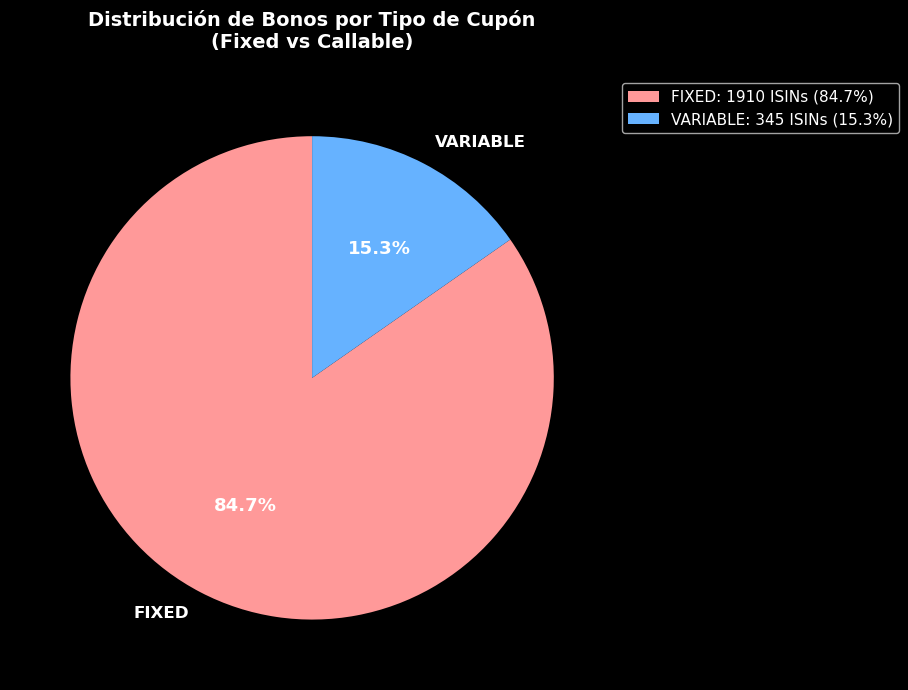


RESUMEN: DISTRIBUCIÓN DE BONOS POR TIPO DE CUPÓN
FIXED           | ISINs: 1910 | Porcentaje:  84.70%
VARIABLE        | ISINs:  345 | Porcentaje:  15.30%


In [9]:
# Gráfico de pastel para Fixed vs Callable
# Contar el número de ISINs por tipo de cupón
coupon_counts = df['Coupon Type'].value_counts()

# Calcular porcentajes
coupon_percentages = (coupon_counts / coupon_counts.sum() * 100).round(2)

# Crear figura y gráfico de pastel
fig, ax = plt.subplots(figsize=(10, 7))

# Colores personalizados
colors = ['#FF9999', '#66B2FF']

# Crear el gráfico de pastel
wedges, texts, autotexts = ax.pie(
    coupon_counts,
    labels=coupon_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Personalizar los textos de porcentaje
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_weight('bold')

# Agregar título
ax.set_title('Distribución de Bonos por Tipo de Cupón\n(Fixed vs Callable)', 
             fontsize=14, fontweight='bold', pad=20)

# Crear leyenda con información detallada
legend_labels = [f'{coupon_type}: {count} ISINs ({pct}%)' 
                 for coupon_type, count, pct in zip(coupon_counts.index, coupon_counts.values, coupon_percentages.values)]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

plt.tight_layout()
plt.show()

# Mostrar tabla con resumen
print("\n" + "="*50)
print("RESUMEN: DISTRIBUCIÓN DE BONOS POR TIPO DE CUPÓN")
print("="*50)
for coupon_type in coupon_counts.index:
    count = coupon_counts[coupon_type]
    pct = coupon_percentages[coupon_type]
    print(f"{coupon_type:15} | ISINs: {count:4} | Porcentaje: {pct:6.2f}%")
print("="*50)

#### <font color=#808080>Sectores y emisores</font>

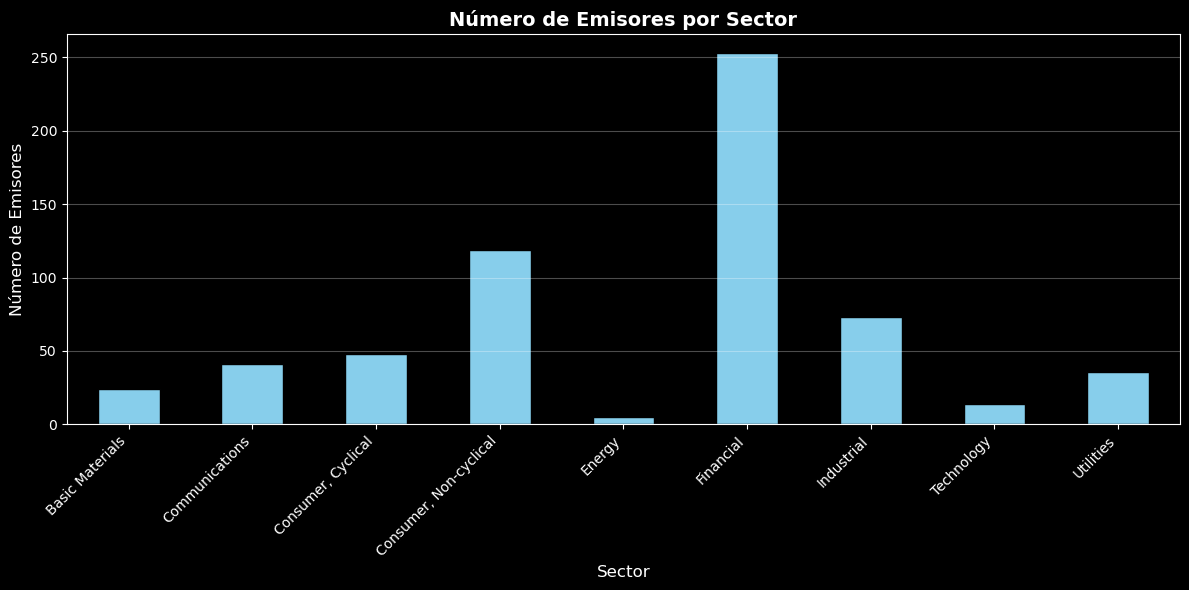


Número de emisores por sector:
Industry Sector
Financial                 253
Consumer, Non-cyclical    119
Industrial                 73
Consumer, Cyclical         48
Communications             41
Utilities                  36
Basic Materials            24
Technology                 14
Energy                      5
Name: Issuer, dtype: int64


In [10]:
sector_emisor = df['Industry Sector']

# Contar el número de emisores únicos por sector
emisores_por_sector = df.groupby('Industry Sector')['Issuer'].nunique()

# Crear el histograma
plt.figure(figsize=(12, 6))
emisores_por_sector.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Emisores por Sector', fontsize=14, fontweight='bold')
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Número de Emisores', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar también los valores numéricos
print("\nNúmero de emisores por sector:")
print(emisores_por_sector.sort_values(ascending=False))

In [11]:
emisores_frecuencia  = df['Issuer'].value_counts()
print(emisores_frecuencia.sort_values(ascending=False))

Issuer
BANQUE FED CRED MUTUEL      33
BNP PARIBAS                 27
VONOVIA SE                  23
BPCE SA                     23
ORANGE SA                   23
                            ..
ABEILLE VIE SA D'ASSURAN     1
KNORR-BREMSE AG              1
SMITH & NEPHEW PLC           1
EUROCLEAR BANK SA            1
SUDZUCKER INT FINANCE        1
Name: count, Length: 613, dtype: int64


Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?

NO , mucha concentración en mismo emisor y mismo sector

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

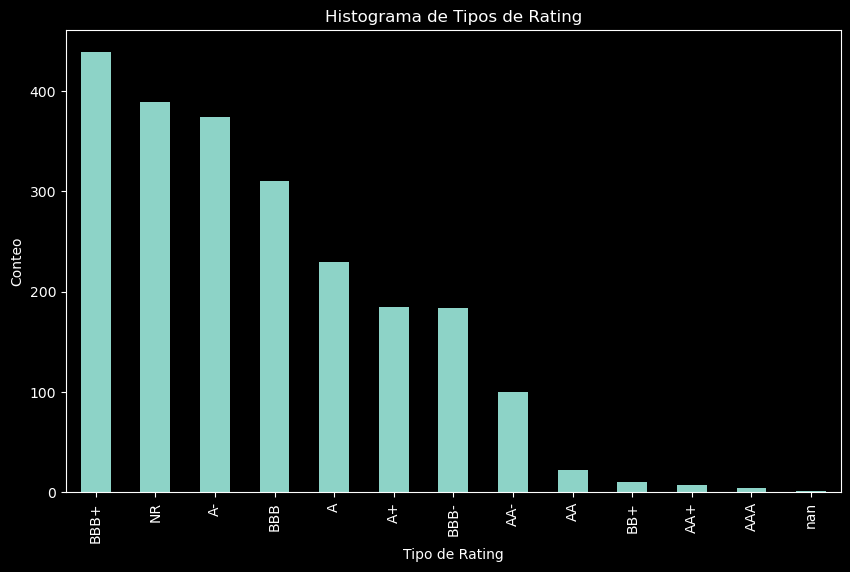

Rating
BBB+    439
NR      389
A-      374
BBB     310
A       230
A+      185
BBB-    184
AA-     100
AA       22
BB+      10
AA+       7
AAA       4
NaN       1
Name: count, dtype: int64


In [12]:
tip_rating = df['Rating']
#hisotgrama con conteo rating
plt.figure(figsize=(10,6))
tip_rating.value_counts(dropna=False).plot(kind='bar')
plt.title('Histograma de Tipos de Rating')
plt.xlabel('Tipo de Rating')
plt.ylabel('Conteo')
plt.show()

print(tip_rating.value_counts(dropna=False).sort_values(ascending=False))

ANÁLISIS: RELACIÓN ENTRE RATINGS Y SECTORES

Valores nulos:
  - Rating: 1 bonos
  - Industry Sector: 0 bonos

TABLA DE FRECUENCIAS: RATING × SECTOR
Industry Sector  Basic Materials  Communications  Consumer, Cyclical  \
Rating                                                                 
A                             20               0                  44   
A+                             0               0                   8   
A-                            15              22                  14   
AA                             0               0                   0   
AA+                            0               0                   0   
AA-                            0               0                   0   
AAA                            0               0                   0   
BB+                            0               5                   3   
BBB                           13              52                  36   
BBB+                          10              58            

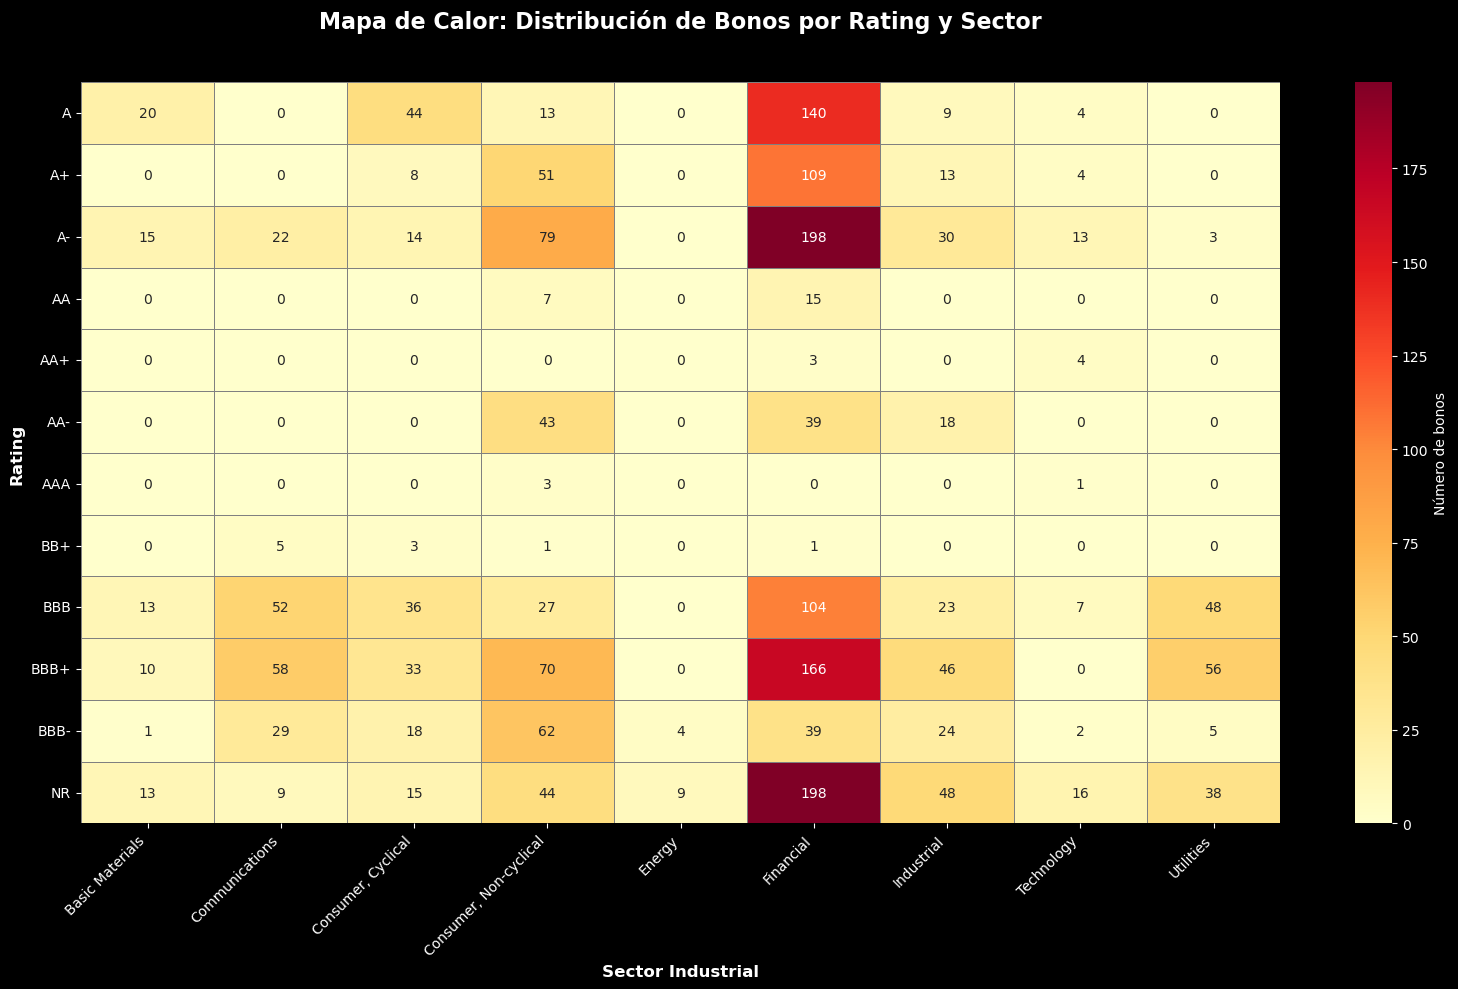


SECTOR MÁS FRECUENTE POR RATING

A:
  - Financial                     : 140 bonos ( 60.9%)
  - Consumer, Cyclical            :  44 bonos ( 19.1%)
  - Basic Materials               :  20 bonos (  8.7%)

A+:
  - Financial                     : 109 bonos ( 58.9%)
  - Consumer, Non-cyclical        :  51 bonos ( 27.6%)
  - Industrial                    :  13 bonos (  7.0%)

A-:
  - Financial                     : 198 bonos ( 52.9%)
  - Consumer, Non-cyclical        :  79 bonos ( 21.1%)
  - Industrial                    :  30 bonos (  8.0%)

AA:
  - Financial                     :  15 bonos ( 68.2%)
  - Consumer, Non-cyclical        :   7 bonos ( 31.8%)

AA+:
  - Technology                    :   4 bonos ( 57.1%)
  - Financial                     :   3 bonos ( 42.9%)

AA-:
  - Consumer, Non-cyclical        :  43 bonos ( 43.0%)
  - Financial                     :  39 bonos ( 39.0%)
  - Industrial                    :  18 bonos ( 18.0%)

AAA:
  - Consumer, Non-cyclical        :   3 bonos ( 75

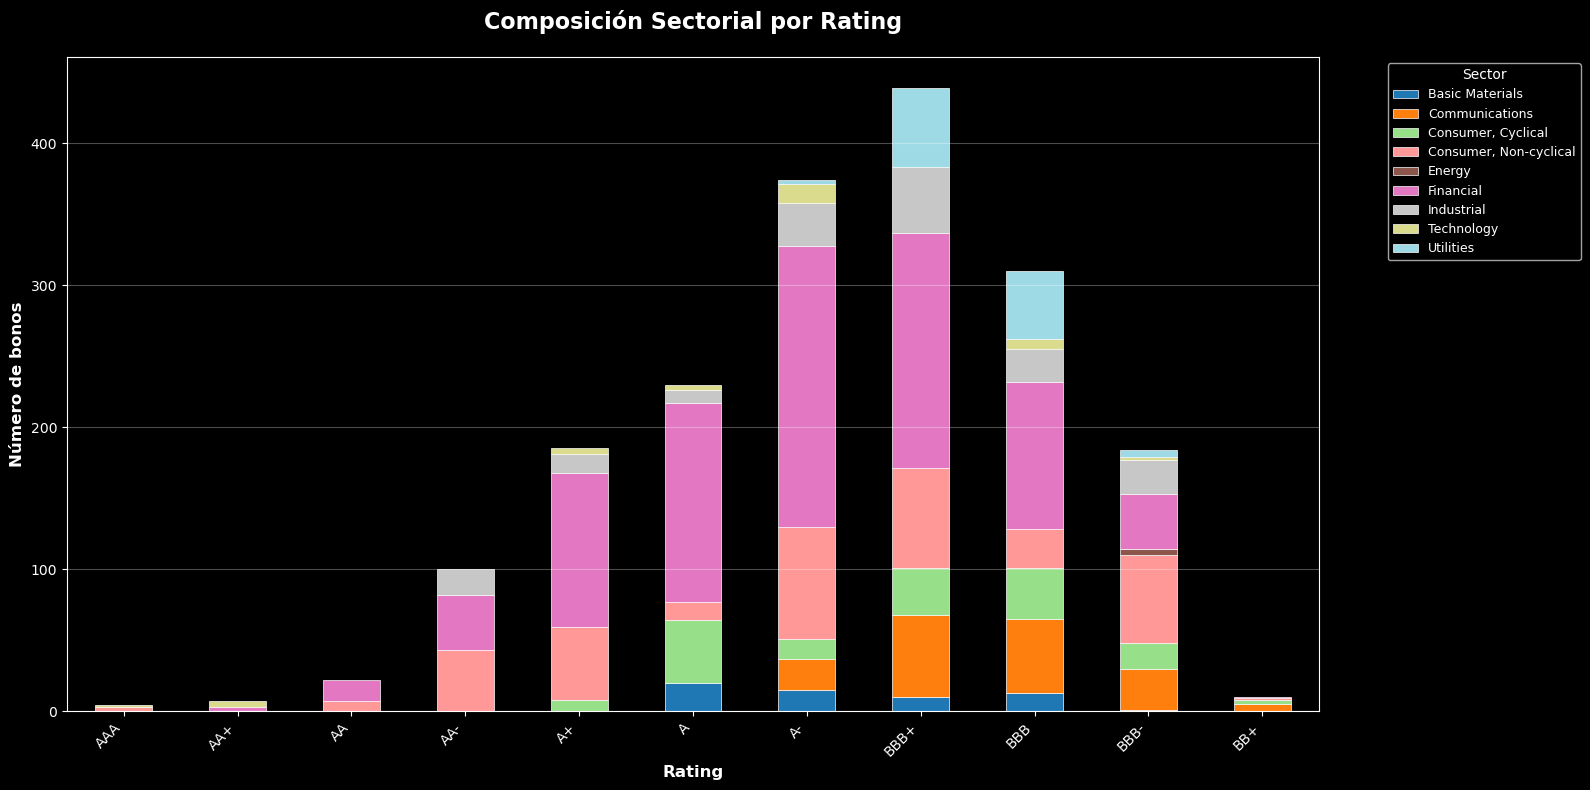


CASOS ESPECIALES

📌 BONOS SIN RATING (1 bonos):

Distribución por sector:
Industry Sector
Energy    1
Name: count, dtype: int64

CONCLUSIÓN

El heatmap muestra claramente:
✓ Qué sectores se concentran en cada nivel de rating
✓ Dónde hay gaps de información (valores NaN)
✓ Patrones: por ejemplo, si "Utilities" tiene más BBB o "Banks" más A

Para imputar sectores faltantes, podrías usar el sector MÁS FRECUENTE
de cada rating, pero primero analiza si tiene sentido (¡mira el heatmap!).



In [65]:
# ============================================================================
# VISUALIZACIÓN: RATINGS vs SECTORES
# ============================================================================

import seaborn as sns

print('='*80)
print('ANÁLISIS: RELACIÓN ENTRE RATINGS Y SECTORES')
print('='*80)

# Verificar valores nulos
print(f'\nValores nulos:')
print(f'  - Rating: {df["Rating"].isna().sum()} bonos')
print(f'  - Industry Sector: {df["Industry Sector"].isna().sum()} bonos')

# ============================================================================
# 1. TABLA DE FRECUENCIAS (RATINGS × SECTORES)
# ============================================================================

# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(
    df['Rating'].fillna('NR'),
    df['Industry Sector'].fillna('Sin Sector'),
    margins=True
)

print(f'\n{"="*80}')
print('TABLA DE FRECUENCIAS: RATING × SECTOR')
print('='*80)
print(tabla_contingencia)

# ============================================================================
# 2. HEATMAP - VISUALIZACIÓN PRINCIPAL
# ============================================================================

plt.figure(figsize=(16, 10))

# Preparar datos (sin totales)
heatmap_data = tabla_contingencia.iloc[:-1, :-1]

# Crear heatmap
sns.heatmap(
    heatmap_data,
    annot=True,          # Mostrar números
    fmt='d',             # Formato entero
    cmap='YlOrRd',       # Paleta de colores
    cbar_kws={'label': 'Número de bonos'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Mapa de Calor: Distribución de Bonos por Rating y Sector\n', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sector Industrial', fontsize=12, fontweight='bold')
plt.ylabel('Rating', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. ANÁLISIS POR RATING - ¿Qué sectores dominan en cada rating?
# ============================================================================

print(f'\n{"="*80}')
print('SECTOR MÁS FRECUENTE POR RATING')
print('='*80)

# Solo bonos CON sector
df_con_sector = df[df['Industry Sector'].notna()].copy()

for rating in sorted(df['Rating'].dropna().unique()):
    bonos_rating = df_con_sector[df_con_sector['Rating'] == rating]
    
    if len(bonos_rating) > 0:
        # Top 3 sectores para este rating
        top_sectores = bonos_rating['Industry Sector'].value_counts().head(3)
        
        print(f'\n{rating}:')
        for sector, count in top_sectores.items():
            pct = count / len(bonos_rating) * 100
            print(f'  - {sector:30s}: {count:3d} bonos ({pct:5.1f}%)')

# ============================================================================
# 4. GRÁFICO DE BARRAS APILADAS - Composición sectorial por rating
# ============================================================================

fig, ax = plt.subplots(figsize=(16, 8))

# Preparar datos para barras apiladas
df_plot = df[df['Rating'].notna() & df['Industry Sector'].notna()].copy()
tabla_plot = pd.crosstab(df_plot['Rating'], df_plot['Industry Sector'])

# Ordenar ratings
orden_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 
                 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B']
ratings_disponibles = [r for r in orden_ratings if r in tabla_plot.index]
tabla_plot = tabla_plot.loc[ratings_disponibles]

# Crear barras apiladas
tabla_plot.plot(kind='bar', stacked=True, ax=ax, figsize=(16, 8), 
                colormap='tab20', edgecolor='white', linewidth=0.5)

ax.set_title('Composición Sectorial por Rating', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Rating', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de bonos', fontsize=12, fontweight='bold')
ax.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============================================================================
# 5. IDENTIFICAR CASOS ESPECIALES
# ============================================================================

print(f'\n{"="*80}')
print('CASOS ESPECIALES')
print('='*80)

# Bonos sin sector
bonos_sin_sector = df[df['Industry Sector'].isna()].copy()
if len(bonos_sin_sector) > 0:
    print(f'\n📌 BONOS SIN SECTOR ({len(bonos_sin_sector)} bonos):')
    print(f'\nDistribución por rating:')
    print(bonos_sin_sector['Rating'].value_counts().sort_index())
    
    print(f'\nPrimeros 5 emisores sin sector:')
    print(bonos_sin_sector.groupby('Issuer')['ISIN'].count().sort_values(ascending=False).head())

# Bonos sin rating
bonos_sin_rating = df[df['Rating'].isna()].copy()
if len(bonos_sin_rating) > 0:
    print(f'\n📌 BONOS SIN RATING ({len(bonos_sin_rating)} bonos):')
    print(f'\nDistribución por sector:')
    print(bonos_sin_rating['Industry Sector'].value_counts())

print(f'\n{"="*80}')
print('CONCLUSIÓN')
print('='*80)
print('''
El heatmap muestra claramente:
✓ Qué sectores se concentran en cada nivel de rating
✓ Dónde hay gaps de información (valores NaN)
✓ Patrones: por ejemplo, si "Utilities" tiene más BBB o "Banks" más A

Para imputar sectores faltantes, podrías usar el sector MÁS FRECUENTE
de cada rating, pero primero analiza si tiene sentido (¡mira el heatmap!).
''')

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

**"La liquidez se ve reflejada en el bid/ask spread"**

In [13]:
df['spread'] = (abs(df['Bid Price'] - df['Ask Price'])).round(4)

In [14]:
df.groupby('Industry Sector')['spread'].mean().sort_values(ascending=False)

Industry Sector
Communications            0.414983
Basic Materials           0.356083
Technology                0.352902
Consumer, Cyclical        0.348029
Energy                    0.343615
Utilities                 0.335380
Industrial                0.326550
Consumer, Non-cyclical    0.322595
Financial                 0.305712
Name: spread, dtype: float64

In [15]:
df.groupby('Rating')['spread'].mean().sort_values(ascending=False)

Rating
AAA     0.424750
BBB-    0.376217
NR      0.345632
BBB     0.333787
BBB+    0.328141
AA-     0.321810
A-      0.314334
A       0.305291
BB+     0.302900
A+      0.292216
AA      0.273545
AA+     0.244857
Name: spread, dtype: float64

**El nominal vivo (outstanding amount) es la cantidad TOTAL emitida y actualmente en circulación en el mercado**



In [16]:
df.groupby('ISIN')[['Outstanding Amount', 'spread']].agg({'Outstanding Amount': 'sum', 'spread': 'mean'}).sort_values(by='Outstanding Amount', ascending=False)

,Outstanding Amount,spread
ISIN,,
CH1214797172,3000000000,0.240
XS2461234622,2500000000,0.210
XS1586555945,2500000000,0.191
XS2595028536,2000000000,0.180
XS1629774230,2000000000,0.559
...,...,...
XS2314267449,300000000,0.592
XS2717378231,300000000,0.456
FR0013321536,274300000,0.461


Qué relación existe entre el spread con el outstanding amount?:

Cuanto mayor es el tamaño de la emisión → más líquida → menor spread bid–ask

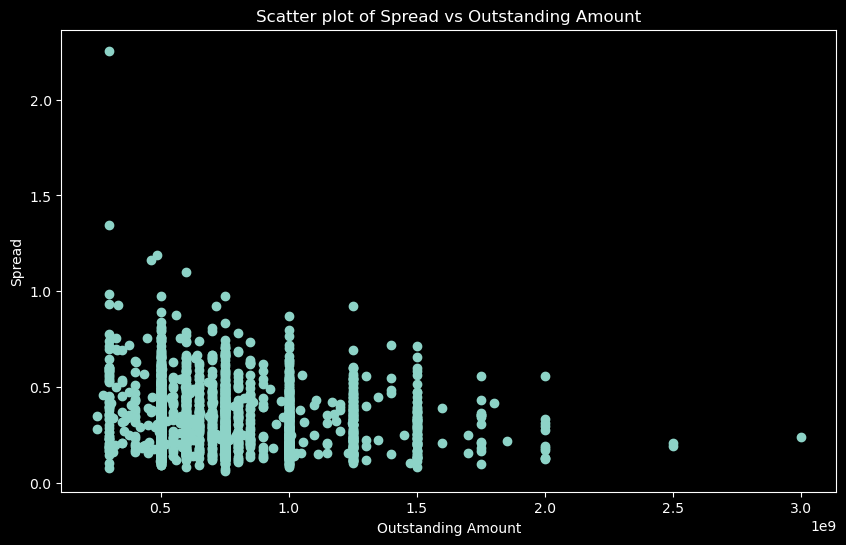

In [17]:
# Scatter plot spread vs outstanding amount
plt.figure(figsize=(10,6))
plt.scatter(df['Outstanding Amount'], df['spread'])
plt.title('Scatter plot of Spread vs Outstanding Amount')
plt.xlabel('Outstanding Amount')
plt.ylabel('Spread')
plt.show()

#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [18]:
# Cargar datos de precios históricos del universo
df_precios_universo = pd.read_csv('../data/precios_historicos_universo.csv', engine='python', sep=None, na_values=['NA', 'NaN', '', '# N/D'])

# Renombrar primera columna a ISIN
df_precios_universo = df_precios_universo.rename(columns={'Unnamed: 0': 'ISIN'})

# Función para normalizar ISIN
def normalizar_isin(isin: str, formato='sin_corp') -> str:
    """Normaliza el formato del ISIN"""
    isin_clean = isin.strip()
    
    if formato == 'sin_corp':
        return isin_clean.replace(' Corp', '')
    elif formato == 'con_corp':
        if not isin_clean.endswith(' Corp'):
            return isin_clean + ' Corp'
    return isin_clean

# Aplicar normalización: remover ' Corp' del ISIN para hacer match con df
df_precios_universo['ISIN'] = df_precios_universo['ISIN'].apply(lambda x: normalizar_isin(x, formato='sin_corp'))

print("Precios históricos del universo cargados y normalizados correctamente")
print(f"Número de bonos: {len(df_precios_universo)}")
print(f"Número de fechas: {len(df_precios_universo.columns) - 1}")  # -1 para excluir columna ISIN
print(f"\nPrimeros ISINs:\n{df_precios_universo['ISIN'].head()}")

Precios históricos del universo cargados y normalizados correctamente
Número de bonos: 2255
Número de fechas: 732

Primeros ISINs:
0    XS0161488498
1    FR0000471930
2    XS0162513211
3    XS0162869076
4    FR0010014845
Name: ISIN, dtype: object


Elimino los fines de semana

In [19]:
# me cargo todas las columnas de precios que son 0 (sin datos)
df_precios_universo = df_precios_universo.loc[:, (df_precios_universo != 0).any(axis=0)]

# Eliminar columnas cuyas fechas corresponden a fines de semana
# Convertir los nombres de las columnas (fechas) a datetime, excluyendo la primera columna que es el ISIN
columnas_fecha = df_precios_universo.columns[1:]  # Excluir la primera columna (ISIN)
fechas_datetime = pd.to_datetime(columnas_fecha, format='%d/%m/%Y', errors='coerce')

# Crear máscara para identificar días que NO son fin de semana (lunes=0, domingo=6)
# weekday: 0-4 son días de semana, 5-6 son sábado y domingo
mascara_dias_semana = fechas_datetime.weekday < 5

# Mantener la primera columna (ISIN) y solo las columnas de días de semana
columnas_mantener = [df_precios_universo.columns[0]] + list(columnas_fecha[mascara_dias_semana])
df_precios_universo = df_precios_universo[columnas_mantener]
df_precios_universo = df_precios_universo.rename(columns={'Unnamed: 0': 'ISIN'})

print(f"Columnas eliminadas (fines de semana): {sum(~mascara_dias_semana)}")
print(f"Columnas restantes: {len(df_precios_universo.columns) - 1}")  # -1 para excluir columna ISIN

Columnas eliminadas (fines de semana): 209
Columnas restantes: 523


Top de los ISINs con mayor número de #N/D

In [20]:
# detectar '#N/D' y sacar los ISIN con mayor cantidad de estos valores
df_n_d_counts = df_precios_universo.set_index('ISIN').map(lambda x: x == '#N/D').sum(axis=1)
df_n_d_counts.sort_values(ascending=False)

ISIN
XS2732952838    61
XS2694995163    58
XS2724401588    57
FR001400MLN4    56
XS2731506841    56
                ..
DE000A3MQQV5     7
XS2101349723     0
XS1562614831     0
XS1511787589     0
ES0211845310     0
Length: 2255, dtype: int64

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

In [21]:
# Cargar datos auxiliares (otros índices y curvas)
df_precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', engine='python', sep=None, na_values=['NA', 'NaN', '', '# N/D'])
df_curva = pd.read_csv('../data/curvaESTR.csv', engine='python', sep=None, na_values=['NA', 'NaN', '', '# N/D'])


Fecha inicial: 10/10/2025
Fecha final: 03/10/2075
Número de puntos: 32
Zero Rate mínimo: 1.9005%
Zero Rate máximo: 2.8694%


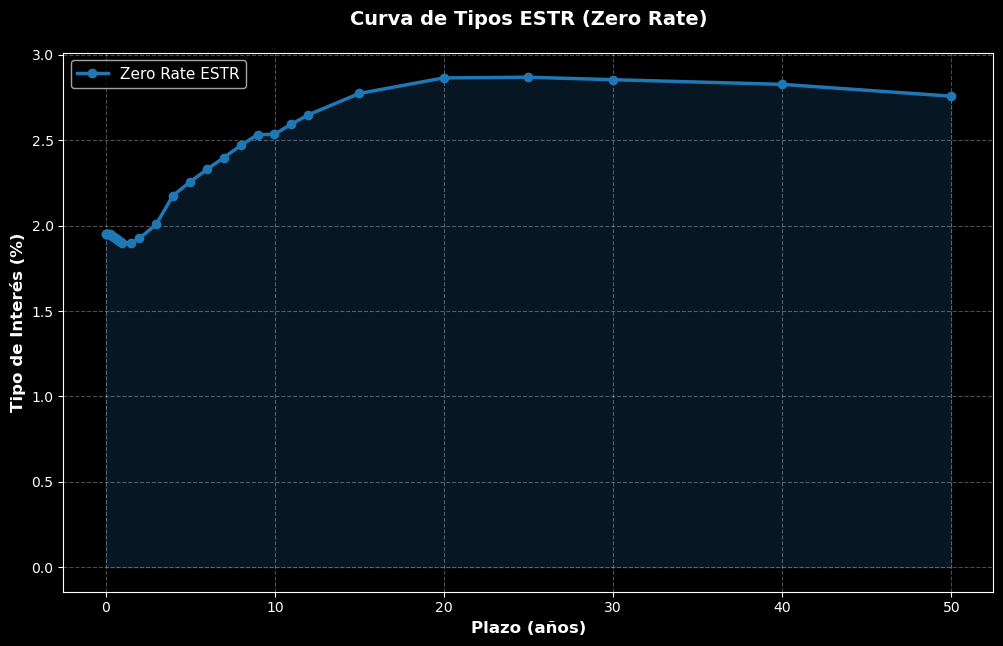

In [22]:
# Convertir la columna de fecha a datetime
df_curva['Date'] = pd.to_datetime(df_curva['Date'], format='%d/%m/%Y')

# Eliminar filas con valores nulos en las tasas
df_curva = df_curva.dropna(subset=['Market Rate', 'Zero Rate'])

# Calcular plazo en años desde la primera fecha
fecha_inicial = df_curva['Date'].iloc[0]
df_curva['Plazo (años)'] = (df_curva['Date'] - fecha_inicial).dt.days / 365.25

# Crear un gráfico adicional más simple y elegante
fig2, ax = plt.subplots(figsize=(12, 7))

ax.plot(df_curva['Plazo (años)'], df_curva['Zero Rate'], marker='o', linewidth=2.5, 
        markersize=6, color='#1f77b4', label='Zero Rate ESTR')
ax.fill_between(df_curva['Plazo (años)'], df_curva['Zero Rate'], alpha=0.2, color='#1f77b4')

ax.set_xlabel('Plazo (años)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tipo de Interés (%)', fontsize=12, fontweight='bold')
ax.set_title('Curva de Tipos ESTR (Zero Rate)', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Actualizar la leyenda para incluir ambas líneas
ax.legend(fontsize=11)

# Mostrar información adicional
print(f"\nFecha inicial: {fecha_inicial.strftime('%d/%m/%Y')}")
print(f"Fecha final: {df_curva['Date'].iloc[-1].strftime('%d/%m/%Y')}")
print(f"Número de puntos: {len(df_curva)}")
print(f"Zero Rate mínimo: {df_curva['Zero Rate'].min():.4f}%")
print(f"Zero Rate máximo: {df_curva['Zero Rate'].max():.4f}%")

plt.show()

### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
visto en la primera clase
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

#### 2.1 Flujos de caja

In [23]:
def determinar_fecha_vencimiento(row: pd.Series) -> date:
    """
    Determina la fecha de vencimiento efectiva según las reglas:
    - Si es callable (Callable = 'Y'): usa Next Call Date
    - Si es perpetuo (Maturity vacío/NaN): usa Next Call Date
    - Si no es callable: usa Maturity
    
    Especifica formato dd/mm/yyyy para evitar ambigüedades en la parseo.
    """
    callable = row['Callable']
    maturity = row['Maturity']
    next_call_date = row['Next Call Date']
    
    # Función auxiliar para parsear fechas en formato dd/mm/yyyy
    def parsear_fecha(fecha_str):
        if pd.isna(fecha_str) or fecha_str == '':
            return None
        fecha_str = str(fecha_str).strip()
        try:
            # Intentar primero con formato dd/mm/yyyy
            return pd.to_datetime(fecha_str, format='%d/%m/%Y', dayfirst=True).date()
        except:
            try:
                # Si falla, intentar con dayfirst=True para mayor flexibilidad
                return pd.to_datetime(fecha_str, dayfirst=True).date()
            except:
                # Último recurso
                return pd.to_datetime(fecha_str).date()
    
    # Si es callable, usar Next Call Date
    if callable == 'Y':
        fecha = parsear_fecha(next_call_date)
        if fecha:
            return fecha
    
    # Si maturity es NaN o está vacío (perpetuo), usar Next Call Date
    if pd.isna(maturity) or maturity == '':
        fecha = parsear_fecha(next_call_date)
        if fecha:
            return fecha
    
    # Si no es callable y tiene maturity, usar Maturity
    fecha = parsear_fecha(maturity)
    if fecha:
        return fecha
    
    # No debería llegar aquí
    raise ValueError(f"No se pudo parsear la fecha de vencimiento")

In [24]:
def limpiar_tasa_cupon(cupon_valor) -> float:
    """
    Convierte el cupón de porcentaje a decimal.
    Ej: 5.0 -> 0.05, "5%" -> 0.05
    """
    if pd.isna(cupon_valor):
        return 0.0
    
    cupon_str = str(cupon_valor).strip()
    
    # Remover símbolo de porcentaje si existe
    if '%' in cupon_str:
        cupon_str = cupon_str.replace('%', '')
    
    valor = float(cupon_str)
    
    # Convertir de porcentaje a decimal
    return valor / 100

In [25]:
def calcular_flujos_caja(
    fecha_valoracion: date,
    fecha_vencimiento: date,
    fecha_primer_cupon: date,
    nominal: float,
    tasa_cupon: float,
    frecuencia_pago: int
) -> List[Tuple[date, float]]:
    """
    Calcula los flujos de caja de un bono desde la fecha de valoración hasta el vencimiento.
    
    INCLUYE:
    - El último cupón pagado antes de la fecha de valoración (solo uno)
    - Todos los cupones >= fecha_valoracion hasta el vencimiento
    - El principal en la fecha de vencimiento (con cupón corrido si no coincide con cupón)
    
    Args:
        fecha_valoracion: Fecha desde la cual calcular flujos futuros
        fecha_vencimiento: Fecha de vencimiento o call del bono
        fecha_primer_cupon: Fecha del primer cupón (First Coupon Date)
        nominal: Outstanding Amount del bono
        tasa_cupon: Tasa de cupón anual en decimal (ej: 0.05 para 5%)
        frecuencia_pago: 1 = Anual, 2 = Semestral, 4 = Trimestral, 12 = Mensual
    
    Returns:
        Lista de tuplas (fecha, monto) ordenadas cronológicamente
    """
    
    flujos = []
    
    # Caso especial: Sin cupones (tasa = 0) - Zero coupon bond
    if tasa_cupon == 0:
        if fecha_vencimiento > fecha_valoracion:
            flujos.append((fecha_vencimiento, nominal))
        return flujos
    
    # 1. Calcular el monto de cada cupón periódico
    monto_cupon_periodico = (nominal * tasa_cupon) / frecuencia_pago
    
    # 2. Determinar el salto en meses entre pagos
    if frecuencia_pago == 1:
        meses_salto = 12
    elif frecuencia_pago == 2:
        meses_salto = 6
    elif frecuencia_pago == 4:
        meses_salto = 3
    elif frecuencia_pago == 12:
        meses_salto = 1
    else:
        raise ValueError(f"Frecuencia de pago '{frecuencia_pago}' no soportada. Use 1, 2, 4 o 12.")
    
    # 3. Usar el día del PRIMER CUPÓN como referencia
    dia_cupon = fecha_primer_cupon.day
    
    # 4. Encontrar el primer cupón >= fecha_valoracion
    fecha_flujo = fecha_primer_cupon
    fecha_cupon_previo = None
    
    while fecha_flujo < fecha_valoracion:
        fecha_cupon_previo = fecha_flujo  # Guardar el último cupón antes de la fecha de valoración
        fecha_flujo = _avanzar_fecha(fecha_flujo, meses_salto, dia_cupon)
    
    # 5. Agregar el último cupón previo a la fecha de valoración (si existe)
    if fecha_cupon_previo is not None:
        flujos.append((fecha_cupon_previo, monto_cupon_periodico))
    
    # 6. Generar todos los cupones desde el primer cupón >= fecha_valoracion hasta el vencimiento
    while fecha_flujo <= fecha_vencimiento:
        flujos.append((fecha_flujo, monto_cupon_periodico))
        fecha_flujo = _avanzar_fecha(fecha_flujo, meses_salto, dia_cupon)
    
    # 7. Agregar el principal en la fecha de vencimiento
    if flujos and flujos[-1][0] == fecha_vencimiento:
        # El último cupón coincide exactamente con el vencimiento: sumar principal
        flujos[-1] = (fecha_vencimiento, flujos[-1][1] + nominal)
    else:
        # El vencimiento no coincide con un cupón: agregar principal + cupón corrido
        
        # Buscar el último cupón antes del vencimiento recorriendo la lista
        fecha_ultimo_cupon = None
        for fecha, _ in flujos:
            if fecha < fecha_vencimiento:
                fecha_ultimo_cupon = fecha
        
        # Si no hay ningún cupón antes del vencimiento, usar fecha_primer_cupon como referencia
        if fecha_ultimo_cupon is None:
            fecha_ultimo_cupon = fecha_primer_cupon
            fecha_siguiente = _avanzar_fecha(fecha_primer_cupon, meses_salto, dia_cupon)
            while fecha_siguiente < fecha_vencimiento:
                fecha_ultimo_cupon = fecha_siguiente
                fecha_siguiente = _avanzar_fecha(fecha_siguiente, meses_salto, dia_cupon)
        
        # La fecha del siguiente cupón (teórico) después del último
        fecha_siguiente_cupon = _avanzar_fecha(fecha_ultimo_cupon, meses_salto, dia_cupon)
        
        # Calcular intereses devengados desde el último cupón hasta el vencimiento
        dias_transcurridos = (fecha_vencimiento - fecha_ultimo_cupon).days
        dias_periodo = (fecha_siguiente_cupon - fecha_ultimo_cupon).days
        
        # Calcular cupón corrido proporcional
        if dias_periodo > 0 and dias_transcurridos > 0:
            cupon_corrido = monto_cupon_periodico * (dias_transcurridos / dias_periodo)
            flujos.append((fecha_vencimiento, nominal + cupon_corrido))
        else:
            # Si no hay período válido, solo devolver el nominal
            flujos.append((fecha_vencimiento, nominal))
    
    return flujos


In [26]:
def parse_date(d) -> Optional[date]:
    """
    Parsea una fecha en formato DD/MM/YYYY a objeto date.
    
    Args:
        d: String con fecha en formato DD/MM/YYYY o valor nulo
    
    Returns:
        Objeto date o None si no se puede parsear
    """
    if pd.isna(d) or d == '' or str(d).strip() == '':
        return None
    try:
        parts = str(d).split('/')
        if len(parts) == 3:
            return date(int(parts[2]), int(parts[1]), int(parts[0]))
    except:
        pass
    return None

In [27]:
def determinar_fecha_vencimiento(row) -> date:
    """
    Determina la fecha de vencimiento efectiva del bono.
    
    Para bonos callables: usa Next Call Date si existe
    Para bonos no callables o sin Next Call Date: usa Maturity
    
    Args:
        row: Fila del DataFrame con los datos del bono
    
    Returns:
        Fecha de vencimiento efectiva
    
    Raises:
        ValueError: Si no se puede determinar la fecha de vencimiento
    """
    next_call = parse_date(row.get('Next Call Date'))
    maturity = parse_date(row.get('Maturity'))
    is_callable = row.get('Callable') == 'Y'
    
    if is_callable and next_call is not None:
        return next_call
    elif maturity is not None:
        return maturity
    else:
        raise ValueError("No se puede determinar fecha de vencimiento: Maturity vacío")


In [28]:
def _avanzar_fecha(fecha: date, meses: int, dia_objetivo: int) -> date:
    """
    Avanza una fecha por el número de meses indicado,
    intentando mantener el día del mes objetivo.
    
    Si el día objetivo no existe en el mes destino (ej: 31 en febrero),
    usa el último día del mes.
    
    Args:
        fecha: Fecha de partida
        meses: Número de meses a avanzar
        dia_objetivo: Día del mes que se quiere mantener
    
    Returns:
        Nueva fecha avanzada
    """
    fecha_temp = fecha + relativedelta(months=meses)
    
    try:
        return fecha_temp.replace(day=dia_objetivo)
    except ValueError:
        # El día no existe en ese mes (ej: 31 de febrero)
        # Usar el último día del mes
        ultimo_dia = monthrange(fecha_temp.year, fecha_temp.month)[1]
        return fecha_temp.replace(day=ultimo_dia)

In [29]:
def obtener_fecha_primer_cupon(row) -> date:
    """
    Obtiene la fecha del primer cupón del bono.
    
    Args:
        row: Fila del DataFrame con los datos del bono
    
    Returns:
        Fecha del primer cupón
    
    Raises:
        ValueError: Si no existe First Coupon Date
    """
    first_coupon = parse_date(row.get('First Coupon Date'))
    
    if first_coupon is None:
        raise ValueError("First Coupon Date es requerido para calcular flujos correctamente")
    
    return first_coupon

In [30]:
def procesar_bonos(df: pd.DataFrame, fecha_valoracion: date) -> pd.DataFrame:
    """
    Procesa el dataframe completo y calcula los flujos de caja para cada bono.
    
    Args:
        df: DataFrame con los bonos (debe contener las columnas:
            ISIN, Description, Callable, Maturity, Next Call Date,
            First Coupon Date, Outstanding Amount, Coupon, Coupon Frequency)
        fecha_valoracion: Fecha fija de valoración
    
    Returns:
        DataFrame con los resultados incluyendo flujos de caja
    """
    resultados = []
    errores = []
    
    for idx, row in df.iterrows():
        try:
            # Determinar fecha de vencimiento efectiva
            fecha_venc = determinar_fecha_vencimiento(row)
            
            # Obtener fecha del primer cupón (NUEVO - requerido para cálculo correcto)
            fecha_primer_cupon = obtener_fecha_primer_cupon(row)
            
            # Obtener parámetros del bono
            nominal = float(row['Outstanding Amount'])
            tasa_cupon = limpiar_tasa_cupon(row['Coupon'])
            frecuencia = int(row['Coupon Frequency'])
            
            # Saltar bonos con vencimiento pasado
            if fecha_venc <= fecha_valoracion:
                continue
            
            # Calcular flujos (CORREGIDO - ahora incluye fecha_primer_cupon)
            flujos = calcular_flujos_caja(
                fecha_valoracion=fecha_valoracion,
                fecha_vencimiento=fecha_venc,
                fecha_primer_cupon=fecha_primer_cupon,
                nominal=nominal,
                tasa_cupon=tasa_cupon,
                frecuencia_pago=frecuencia
            )
            
            # Calcular valor total de los flujos (suma simple, sin descontar)
            valor_total_flujos = sum([monto for _, monto in flujos])
            
            # Guardar resultado
            resultados.append({
                'ISIN': row['ISIN'],
                'Description': row['Description'],
                'Callable': row['Callable'],
                'Maturity': row['Maturity'],
                'Next_Call_Date': row.get('Next Call Date', ''),
                'First_Coupon_Date': row.get('First Coupon Date', ''),
                'Fecha_Valoracion': fecha_valoracion,
                'Fecha_Vencimiento_Efectiva': fecha_venc,
                'Outstanding_Amount': nominal,
                'Coupon_Rate': tasa_cupon,
                'Coupon_Frequency': frecuencia,
                'Numero_Flujos': len(flujos),
                'Valor_Total_Flujos': valor_total_flujos,
                'Flujos_Caja': flujos
            })
            
        except Exception as e:
            errores.append({
                'ISIN': row.get('ISIN', 'N/A'),
                'Description': row.get('Description', 'N/A'),
                'Error': str(e)
            })
            continue
    
    # Resumen de procesamiento
    print(f"Procesamiento completado:")
    print(f"  - Bonos procesados exitosamente: {len(resultados)}")
    print(f"  - Bonos con errores: {len(errores)}")
    
    if errores:
        print(f"\nErrores encontrados:")
        for err in errores[:10]:  # Mostrar solo los primeros 10
            print(f"  - {err['ISIN']}: {err['Error']}")
        if len(errores) > 10:
            print(f"  ... y {len(errores) - 10} errores más")
    
    return pd.DataFrame(resultados)

In [31]:
# Definir fecha de valoración fija
fecha_valoracion = date(2025, 10, 1)  # Ajusta según necesites

# Procesar todos los bonos
df_flujos = procesar_bonos(df, fecha_valoracion)

df_flujos

Procesamiento completado:
  - Bonos procesados exitosamente: 2255
  - Bonos con errores: 0


,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,5.000000e+08,0.07500,1,9,8.375000e+08,"[(2025-01-24, 37500000.0), (2026-01-24, 375000..."
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,NaN,28/01/2004,2025-10-01,2033-01-28,1.500000e+09,0.08125,1,9,2.596875e+09,"[(2025-01-28, 121875000.0), (2026-01-28, 12187..."
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,6.000000e+08,0.05750,1,9,9.105000e+08,"[(2025-02-14, 34500000.0), (2026-02-14, 345000..."
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,5.000000e+08,0.05875,1,9,7.643750e+08,"[(2025-02-14, 29375000.0), (2026-02-14, 293750..."
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,NaN,19/09/2004,2025-10-01,2033-09-19,6.000000e+08,0.06000,1,9,9.240000e+08,"[(2025-09-19, 36000000.0), (2026-09-19, 360000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,07/12/2027,07/12/2024,2025-10-01,2027-12-07,5.000000e+08,0.07250,1,4,6.450000e+08,"[(2024-12-07, 36250000.0), (2025-12-07, 362500..."
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,NaN,07/12/2024,2025-10-01,2031-12-07,5.000000e+08,0.03750,1,8,6.500000e+08,"[(2024-12-07, 18750000.0), (2025-12-07, 187500..."
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,11/09/2030,11/12/2024,2025-10-01,2030-09-11,7.500000e+08,0.04125,1,7,9.588493e+08,"[(2024-12-11, 30937500.0), (2025-12-11, 309375..."
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,11/09/2028,11/12/2024,2025-10-01,2028-09-11,6.000000e+08,0.03375,1,5,6.962152e+08,"[(2024-12-11, 20250000.0), (2025-12-11, 202500..."


In [32]:
isin_buscado = 'XS2193974701'  # Cambia por el ISIN que quieras
resultado = df_flujos[df_flujos['ISIN'] == isin_buscado]
resultado

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja
868,XS2193974701,WMG 2 ¾ 07/15/28,Y,15/07/2028,28/11/2025,15/01/2021,2025-10-01,2025-11-28,325000000.0,0.0275,2,2,3.327717e+08,"[(2025-07-15, 4468750.0), (2025-11-28, 3283029..."


#### 2.2 Cálculo del cupón corrido

In [33]:
def calcular_cupon_corrido(
    fecha_valoracion: date,
    flujos_caja: List[Tuple[date, float]],
    outstanding_amount: float,
    coupon_rate: float,
    frecuencia_pago: int
) -> Tuple[float, float]:
    """
    Calcula el cupón corrido (accrued interest) de un bono.

    Para bonos con FRECUENCIA ANUAL:
    Cupón Corrido = (Outstanding Amount × Coupon Rate × Días transcurridos) / 365
    
    Donde días transcurridos se calculan desde el ÚLTIMO CUPÓN PAGADO hasta la 
    FECHA DE VALORACIÓN (NO hasta el vencimiento).
    
    IMPORTANTE: flujos_caja ahora incluye como PRIMER elemento el último cupón pagado
    antes de la fecha de valoración.

    Args:
        fecha_valoracion: Fecha de valoración (ej: 2025-10-01)
        flujos_caja: Lista de tuplas (fecha, monto) - el primer elemento es el último cupón pagado
        outstanding_amount: Nominal del bono
        coupon_rate: Tasa de cupón anual (en decimal, ej: 0.0275 para 2.75%)
        frecuencia_pago: 1=Anual, 2=Semestral, 4=Trimestral, 12=Mensual

    Returns:
        Tuple[float, float]: (Cupón corrido en unidades monetarias, Cupón corrido en %)
    """
    
    # Caso especial: sin flujos futuros o cupón cero
    if not flujos_caja or coupon_rate == 0:
        return (0.0, 0.0)
    
    # El primer elemento de flujos_caja es el último cupón pagado (antes de la fecha de valoración)
    fecha_ultimo_cupon_pagado = flujos_caja[0][0]
    
    # Verificar que el primer flujo sea efectivamente anterior a la fecha de valoración
    if fecha_ultimo_cupon_pagado >= fecha_valoracion:
        # El primer flujo no es un cupón pasado, es futuro - no hay cupón corrido
        return (0.0, 0.0)
    
    # Buscar el primer cupón futuro (>= fecha_valoracion)
    fecha_primer_cupon_futuro = None
    for fecha, _ in flujos_caja:
        if fecha >= fecha_valoracion:
            fecha_primer_cupon_futuro = fecha
            break
    
    # Si no hay cupón futuro, no calculamos cupón corrido
    if fecha_primer_cupon_futuro is None:
        return (0.0, 0.0)
    
    # Verificar que la fecha de valoración está ENTRE el último cupón pagado y el próximo
    if fecha_valoracion >= fecha_primer_cupon_futuro:
        # Fecha de valoración posterior al próximo cupón (Ex-Cupón)
        return (0.0, 0.0)
    
    # Cálculo de Días Transcurridos
    # DÍAS ENTRE: ÚLTIMO CUPÓN PAGADO → FECHA VALORACIÓN
    dias_transcurridos = (fecha_valoracion - fecha_ultimo_cupon_pagado).days
    
    if dias_transcurridos <= 0:
        return (0.0, 0.0)
    
    # Cálculo del Cupón Corrido (Base ACT/365)
    cupon_corrido = (outstanding_amount * coupon_rate * dias_transcurridos) / 365.0
    cupon_corrido_pct = (coupon_rate * (dias_transcurridos / 365.0)) * 100

    cupon_corrido_redondeado = round(cupon_corrido, 6)
    cupon_corrido_pct_redondeado = round(cupon_corrido_pct, 6)

    print(f"dias_transcurridos: {dias_transcurridos}, fecha_ultimo_cupon_pagado: {fecha_ultimo_cupon_pagado}, fecha_valoracion: {fecha_valoracion}, fecha_primer_cupon_futuro: {fecha_primer_cupon_futuro}")

    return (cupon_corrido_redondeado, cupon_corrido_pct_redondeado)


In [34]:
# Aplicar la función al DataFrame df_flujos para crear la columna Cupon_Corrido
df_flujos[['Cupon_Corrido', 'Cupon_Corrido_Pct']] = df_flujos.apply(
    lambda row: calcular_cupon_corrido(
        fecha_valoracion=row['Fecha_Valoracion'],
        flujos_caja=row['Flujos_Caja'],
        outstanding_amount=row['Outstanding_Amount'],
        coupon_rate=row['Coupon_Rate'],
        frecuencia_pago=row['Coupon_Frequency']
    ),
    axis=1,
    result_type='expand'
)
df_flujos

dias_transcurridos: 250, fecha_ultimo_cupon_pagado: 2025-01-24, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-01-24
dias_transcurridos: 246, fecha_ultimo_cupon_pagado: 2025-01-28, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-01-28
dias_transcurridos: 229, fecha_ultimo_cupon_pagado: 2025-02-14, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-02-14
dias_transcurridos: 229, fecha_ultimo_cupon_pagado: 2025-02-14, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-02-14
dias_transcurridos: 12, fecha_ultimo_cupon_pagado: 2025-09-19, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-09-19
dias_transcurridos: 310, fecha_ultimo_cupon_pagado: 2024-11-25, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2025-11-25
dias_transcurridos: 12, fecha_ultimo_cupon_pagado: 2025-09-19, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-09-19
dias_transcurridos: 143, fecha_ultimo_cupon_pagado: 2025-05-11, fecha_valoraci

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja,Cupon_Corrido,Cupon_Corrido_Pct
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,5.000000e+08,0.07500,1,9,8.375000e+08,"[(2025-01-24, 37500000.0), (2026-01-24, 375000...",2.568493e+07,5.136986
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,NaN,28/01/2004,2025-10-01,2033-01-28,1.500000e+09,0.08125,1,9,2.596875e+09,"[(2025-01-28, 121875000.0), (2026-01-28, 12187...",8.214041e+07,5.476027
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,6.000000e+08,0.05750,1,9,9.105000e+08,"[(2025-02-14, 34500000.0), (2026-02-14, 345000...",2.164521e+07,3.607534
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,5.000000e+08,0.05875,1,9,7.643750e+08,"[(2025-02-14, 29375000.0), (2026-02-14, 293750...",1.842979e+07,3.685959
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,NaN,19/09/2004,2025-10-01,2033-09-19,6.000000e+08,0.06000,1,9,9.240000e+08,"[(2025-09-19, 36000000.0), (2026-09-19, 360000...",1.183562e+06,0.197260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,07/12/2027,07/12/2024,2025-10-01,2027-12-07,5.000000e+08,0.07250,1,4,6.450000e+08,"[(2024-12-07, 36250000.0), (2025-12-07, 362500...",2.959589e+07,5.919178
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,NaN,07/12/2024,2025-10-01,2031-12-07,5.000000e+08,0.03750,1,8,6.500000e+08,"[(2024-12-07, 18750000.0), (2025-12-07, 187500...",1.530822e+07,3.061644
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,11/09/2030,11/12/2024,2025-10-01,2030-09-11,7.500000e+08,0.04125,1,7,9.588493e+08,"[(2024-12-11, 30937500.0), (2025-12-11, 309375...",2.491952e+07,3.322603
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,11/09/2028,11/12/2024,2025-10-01,2028-09-11,6.000000e+08,0.03375,1,5,6.962152e+08,"[(2024-12-11, 20250000.0), (2025-12-11, 202500...",1.631096e+07,2.718493


In [35]:
# Filtrar solo el ISIN específico
isin_buscado = 'XS2193974701'
df_filtrado = df_flujos[df_flujos['ISIN'] == isin_buscado].copy()

# Recalcular cupón corrido sin prints de debug
df_filtrado[['Cupon_Corrido', 'Cupon_Corrido_Pct']] = df_filtrado.apply(
    lambda row: calcular_cupon_corrido(
        fecha_valoracion=row['Fecha_Valoracion'],
        flujos_caja=row['Flujos_Caja'],
        outstanding_amount=row['Outstanding_Amount'],
        coupon_rate=row['Coupon_Rate'],
        frecuencia_pago=row['Coupon_Frequency']
    ),
    axis=1,
    result_type='expand'
)

df_filtrado

dias_transcurridos: 78, fecha_ultimo_cupon_pagado: 2025-07-15, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2025-11-28


,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja,Cupon_Corrido,Cupon_Corrido_Pct
868,XS2193974701,WMG 2 ¾ 07/15/28,Y,15/07/2028,28/11/2025,15/01/2021,2025-10-01,2025-11-28,325000000.0,0.0275,2,2,3.327717e+08,"[(2025-07-15, 4468750.0), (2025-11-28, 3283029...",1.909932e+06,0.587671


In [36]:
# Filtrar solo el ISIN específico
isin_buscado = 'XS0161488498'
df_filtrado = df_flujos[df_flujos['ISIN'] == isin_buscado].copy()

# Recalcular cupón corrido sin prints de debug
df_filtrado[['Cupon_Corrido', 'Cupon_Corrido_Pct']] = df_filtrado.apply(
    lambda row: calcular_cupon_corrido(
        fecha_valoracion=row['Fecha_Valoracion'],
        flujos_caja=row['Flujos_Caja'],
        outstanding_amount=row['Outstanding_Amount'],
        coupon_rate=row['Coupon_Rate'],
        frecuencia_pago=row['Coupon_Frequency']
    ),
    axis=1,
    result_type='expand'
)

df_filtrado

dias_transcurridos: 250, fecha_ultimo_cupon_pagado: 2025-01-24, fecha_valoracion: 2025-10-01, fecha_primer_cupon_futuro: 2026-01-24


,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja,Cupon_Corrido,Cupon_Corrido_Pct
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,500000000.0,0.075,1,9,837500000.0,"[(2025-01-24, 37500000.0), (2026-01-24, 375000...",2.568493e+07,5.136986


#### 2.3 Descuento de los flujos

In [37]:
# Cargar la curva ESTR
# Nota: El archivo tiene formato semicolon-separated
df_curva_estr = pd.read_csv('../data/curvaESTR.csv', sep=';')

# Convertir la columna Date a datetime
df_curva_estr['Date'] = pd.to_datetime(df_curva_estr['Date'], format='%d/%m/%Y', errors='coerce')

# Eliminar filas con fechas NaN o valores nulos
df_curva_estr = df_curva_estr.dropna(subset=['Date', 'Discount'])

# Convertir tipos de datos
df_curva_estr['Zero Rate'] = pd.to_numeric(df_curva_estr['Zero Rate'], errors='coerce')
df_curva_estr['Discount'] = pd.to_numeric(df_curva_estr['Discount'], errors='coerce')

# Resetear el índice
df_curva_estr = df_curva_estr.reset_index(drop=True)

print("Curva ESTR cargada correctamente")
print(f"Número de puntos en la curva: {len(df_curva_estr)}")
print("\nPrimeros puntos de la curva:")
print(df_curva_estr.head(10))
print("\nÚltimos puntos de la curva:")
print(df_curva_estr.tail(5))

Curva ESTR cargada correctamente
Número de puntos en la curva: 33

Primeros puntos de la curva:
        Date  Market Rate  Zero Rate  Discount
0 2025-10-01          NaN        NaN  1.000000
1 2025-10-10      1.92700    1.95350  0.999518
2 2025-10-17      1.92800    1.95402  0.999144
3 2025-11-03      1.92800    1.95320  0.998236
4 2025-12-03      1.92900    1.95264  0.996635
5 2026-01-05      1.92710    1.94907  0.994887
6 2026-02-03      1.92745    1.94523  0.993360
7 2026-03-03      1.92210    1.94115  0.991896
8 2026-04-07      1.91720    1.93447  0.990086
9 2026-05-04      1.91180    1.92772  0.988709

Últimos puntos de la curva:
         Date  Market Rate  Zero Rate  Discount
28 2045-10-03      2.80180    2.86536  0.563481
29 2050-10-03      2.81430    2.86943  0.487733
30 2055-10-04      2.81090    2.85489  0.424328
31 2065-10-05      2.80175    2.82775  0.322328
32 2075-10-03      2.76800    2.75841  0.251512


In [38]:
def descontar_flujos(
    flujos_caja: List[Tuple[date, float]],
    df_curva: pd.DataFrame,
    fecha_valoracion: date,
    spread_credito: float = 0.0
) -> float:
    """
    Descuenta los flujos de caja utilizando la curva ESTR y un spread de crédito opcional.
    
    NOTA: Esta función es un wrapper de calcular_valor_presente() para mantener
    compatibilidad con código existente. Para nuevos desarrollos, usar directamente
    calcular_valor_presente() con MetodoDescuento.CURVA.
    
    Utiliza capitalización continua:
    Precio = Σ [Flujo_i × DF(T_i) × exp(-spread × T_i)]
    
    Args:
        flujos_caja: Lista de tuplas (fecha, monto)
        df_curva: DataFrame con la curva ESTR
        fecha_valoracion: Fecha de valoración
        spread_credito: Spread de crédito en decimal (ej: 0.01 para 100 bps)
    
    Returns:
        float: Valor presente de los flujos (precio sucio)
    """
    return calcular_valor_presente(
        flujos_caja=flujos_caja,
        fecha_valoracion=fecha_valoracion,
        metodo=MetodoDescuento.CURVA,
        df_curva=df_curva,
        spread_credito=spread_credito
    )

In [39]:
# Calcular precio sucio (valor presente de todos los flujos)
df_flujos['Precio_Sucio'] = df_flujos.apply(
    lambda row: calcular_valor_presente(
        flujos_caja=row['Flujos_Caja'],
        fecha_valoracion=row['Fecha_Valoracion'],
        metodo=MetodoDescuento.CURVA,
        df_curva=df_curva_estr,
        spread_credito=0.0  # Spread de crédito = 0 por ahora
    ),
    axis=1
)

# Calcular precio limpio (precio sucio - cupón corrido)
df_flujos['Precio_Limpio'] = df_flujos['Precio_Sucio'] - df_flujos['Cupon_Corrido']

# Convertir a precio por unidad de nominal (100 = par)
df_flujos['Precio_Limpio_Pct'] = (df_flujos['Precio_Limpio'] / df_flujos['Outstanding_Amount']) * 100
df_flujos['Precio_Sucio_Pct'] = (df_flujos['Precio_Sucio'] / df_flujos['Outstanding_Amount']) * 100

In [40]:
df_flujos

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja,Cupon_Corrido,Cupon_Corrido_Pct,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,5.000000e+08,0.07500,1,9,8.375000e+08,"[(2025-01-24, 37500000.0), (2026-01-24, 375000...",2.568493e+07,5.136986,6.944742e+08,6.687892e+08,133.757847,138.894833
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,NaN,28/01/2004,2025-10-01,2033-01-28,1.500000e+09,0.08125,1,9,2.596875e+09,"[(2025-01-28, 121875000.0), (2026-01-28, 12187...",8.214041e+07,5.476027,2.151706e+09,2.069565e+09,137.971025,143.447053
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,6.000000e+08,0.05750,1,9,9.105000e+08,"[(2025-02-14, 34500000.0), (2026-02-14, 345000...",2.164521e+07,3.607534,7.549505e+08,7.333053e+08,122.217546,125.825080
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,5.000000e+08,0.05875,1,9,7.643750e+08,"[(2025-02-14, 29375000.0), (2026-02-14, 293750...",1.842979e+07,3.685959,6.337144e+08,6.152846e+08,123.056925,126.742884
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,NaN,19/09/2004,2025-10-01,2033-09-19,6.000000e+08,0.06000,1,9,9.240000e+08,"[(2025-09-19, 36000000.0), (2026-09-19, 360000...",1.183562e+06,0.197260,7.533621e+08,7.521785e+08,125.363091,125.560351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,07/12/2027,07/12/2024,2025-10-01,2027-12-07,5.000000e+08,0.07250,1,4,6.450000e+08,"[(2024-12-07, 36250000.0), (2025-12-07, 362500...",2.959589e+07,5.919178,5.855167e+08,5.559208e+08,111.184167,117.103346
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,NaN,07/12/2024,2025-10-01,2031-12-07,5.000000e+08,0.03750,1,8,6.500000e+08,"[(2024-12-07, 18750000.0), (2025-12-07, 187500...",1.530822e+07,3.061644,5.550763e+08,5.397681e+08,107.953612,111.015256
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,11/09/2030,11/12/2024,2025-10-01,2030-09-11,7.500000e+08,0.04125,1,7,9.588493e+08,"[(2024-12-11, 30937500.0), (2025-12-11, 309375...",2.491952e+07,3.322603,8.395963e+08,8.146768e+08,108.623572,111.946175
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,11/09/2028,11/12/2024,2025-10-01,2028-09-11,6.000000e+08,0.03375,1,5,6.962152e+08,"[(2024-12-11, 20250000.0), (2025-12-11, 202500...",1.631096e+07,2.718493,6.392935e+08,6.229825e+08,103.830416,106.548909


In [41]:
isin_buscado = 'XS2193974701'  # Cambia por el ISIN que quieras
resultado = df_flujos[df_flujos['ISIN'] == isin_buscado]
resultado

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Valor_Total_Flujos,Flujos_Caja,Cupon_Corrido,Cupon_Corrido_Pct,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct
868,XS2193974701,WMG 2 ¾ 07/15/28,Y,15/07/2028,28/11/2025,15/01/2021,2025-10-01,2025-11-28,325000000.0,0.0275,2,2,3.327717e+08,"[(2025-07-15, 4468750.0), (2025-11-28, 3283029...",1.909932e+06,0.587671,3.272858e+08,3.253759e+08,100.11565,100.703321


### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 

Z SPREAD
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

#### 3.1 Brent

In [42]:
def calcular_z_spread(
    precio_mercado_limpio: float,
    flujos_caja: List[Tuple[date, float]],
    cupon_corrido: float,
    df_curva: pd.DataFrame,
    fecha_valoracion: date,
    outstanding_amount: float
) -> float:
    """
    Calcula el Z-spread de un bono usando el método de Brent.
    """

    if not flujos_caja or outstanding_amount == 0:
        return np.nan

    precio_mercado_limpio_abs = (precio_mercado_limpio / 100.0) * outstanding_amount
    precio_mercado_sucio = precio_mercado_limpio_abs + cupon_corrido

    # Definir función raíz: VP(spread) - PrecioMercadoSucio = 0
    def funcion_raiz(spread):
        vp = descontar_flujos(
            flujos_caja=flujos_caja,
            df_curva=df_curva,
            fecha_valoracion=fecha_valoracion,
            spread_credito=spread
        )
        return vp - precio_mercado_sucio

    try:
        f_a = funcion_raiz(-0.05)
        f_b = funcion_raiz(0.20)

        # Verificar que exista cambio de signo
        if f_a * f_b > 0:
            return np.nan

        # Ejecutar método de Brent
        resultado = brentq(funcion_raiz, -0.05, 0.20, xtol=1e-10, rtol=1e-8, maxiter=100, full_output=False)
        spread_opt = float(resultado)
        return spread_opt * 10000  # convertir a bps

    except Exception as e:
        print(f"Error en cálculo de Z-spread: {e}")
        return np.nan


In [43]:
print("Calculando Z-spread para todos los bonos...")
print("Esto puede tardar algunos minutos debido a la optimización numérica...\n")

# Obtener precios de mercado del DataFrame base
precio_mercado_dict = dict(zip(df['ISIN'], df['Price']))

# Añadir precio de mercado al DataFrame de flujos
df_flujos['Precio_Mercado'] = df_flujos['ISIN'].map(precio_mercado_dict)

# Calcular Z-Spread para cada bono
df_flujos['Z_Spread_bps'] = df_flujos.apply(
    lambda row: calcular_z_spread(
        precio_mercado_limpio=row['Precio_Mercado'],
        flujos_caja=row['Flujos_Caja'],
        cupon_corrido=row['Cupon_Corrido'],
        df_curva=df_curva_estr,
        fecha_valoracion=row['Fecha_Valoracion'],
        outstanding_amount=row['Outstanding_Amount']
    ) if not pd.isna(row['Precio_Mercado']) else np.nan,
    axis=1
)

print("✅ Cálculo de Z-spread completado.\n")

Calculando Z-spread para todos los bonos...
Esto puede tardar algunos minutos debido a la optimización numérica...

✅ Cálculo de Z-spread completado.

✅ Cálculo de Z-spread completado.



In [44]:
def calcular_precio_con_spread(row):
    if pd.isna(row['Z_Spread_bps']):
        return np.nan

    precio_sucio = descontar_flujos(
        flujos_caja=row['Flujos_Caja'],
        df_curva=df_curva_estr,
        fecha_valoracion=row['Fecha_Valoracion'],
        spread_credito=row['Z_Spread_bps'] / 10000
    )
    precio_limpio = precio_sucio - row['Cupon_Corrido']
    return (precio_limpio / row['Outstanding_Amount']) * 100

df_flujos['Precio_con_ZSpread'] = df_flujos.apply(calcular_precio_con_spread, axis=1)
df_flujos['Diferencia_Precio'] = df_flujos['Precio_con_ZSpread'] - df_flujos['Precio_Mercado']

In [45]:
df_flujos

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,...,Cupon_Corrido,Cupon_Corrido_Pct,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct,Precio_Mercado,Z_Spread_bps,Precio_con_ZSpread,Diferencia_Precio
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,5.000000e+08,0.07500,...,2.568493e+07,5.136986,6.944742e+08,6.687892e+08,133.757847,138.894833,127.8353,74.378485,127.8353,9.947598e-14
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,NaN,28/01/2004,2025-10-01,2033-01-28,1.500000e+09,0.08125,...,8.214041e+07,5.476027,2.151706e+09,2.069565e+09,137.971025,143.447053,131.3195,81.904379,131.3195,1.136868e-13
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,6.000000e+08,0.05750,...,2.164521e+07,3.607534,7.549505e+08,7.333053e+08,122.217546,125.825080,115.7800,85.550665,115.7800,3.268497e-13
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,5.000000e+08,0.05875,...,1.842979e+07,3.685959,6.337144e+08,6.152846e+08,123.056925,126.742884,116.3000,89.516733,116.3000,3.410605e-13
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,NaN,19/09/2004,2025-10-01,2033-09-19,6.000000e+08,0.06000,...,1.183562e+06,0.197260,7.533621e+08,7.521785e+08,125.363091,125.560351,112.3887,163.401057,112.3887,1.510614e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,07/12/2027,07/12/2024,2025-10-01,2027-12-07,5.000000e+08,0.07250,...,2.959589e+07,5.919178,5.855167e+08,5.559208e+08,111.184167,117.103346,107.8130,146.225277,107.8130,-3.268497e-13
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,NaN,07/12/2024,2025-10-01,2031-12-07,5.000000e+08,0.03750,...,1.530822e+07,3.061644,5.550763e+08,5.397681e+08,107.953612,111.015256,103.2010,79.658551,103.2010,0.000000e+00
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,11/09/2030,11/12/2024,2025-10-01,2030-09-11,7.500000e+08,0.04125,...,2.491952e+07,3.322603,8.395963e+08,8.146768e+08,108.623572,111.946175,104.4336,85.743390,104.4336,1.841993e-08
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,11/09/2028,11/12/2024,2025-10-01,2028-09-11,6.000000e+08,0.03375,...,1.631096e+07,2.718493,6.392935e+08,6.229825e+08,103.830416,106.548909,102.2970,52.087571,102.2970,-8.199663e-12


Media del Z-spread por Rating (bps):
        Z-spread medio (bps)  Número de bonos
Rating                                       
AAA                42.711583                4
AA                 44.298441               22
AA+                46.603035                7
AA-                49.907663              100
A+                 63.135504              185
A                  66.585425              230
A-                 72.565781              374
BBB+               83.473299              439
BBB                86.492440              310
NR                 89.354047              389
BBB-              105.403536              184
BB+               107.681808               10


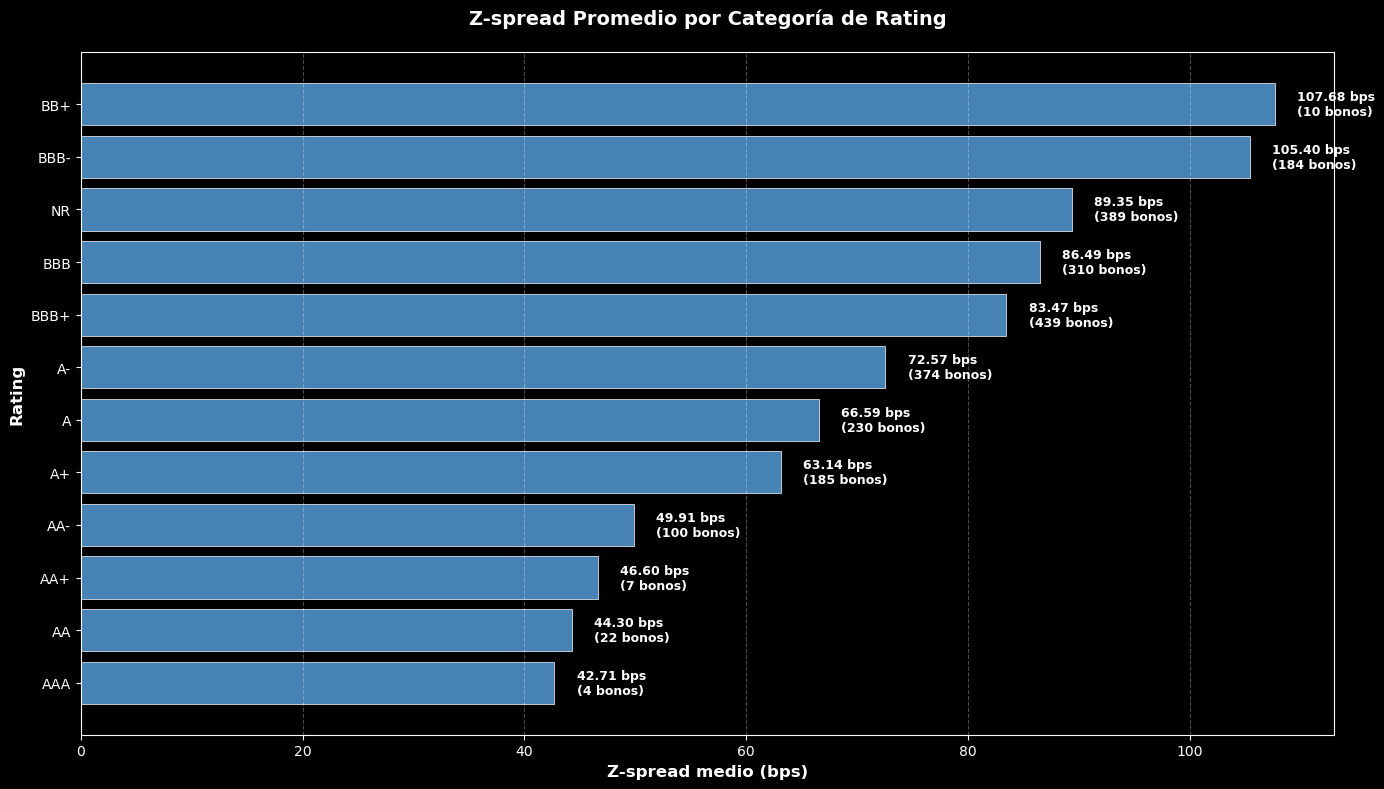


ANÁLISIS DEL Z-SPREAD POR RATING

INTERPRETACIÓN:

1. RELACIÓN RATING - Z-SPREAD:
   - Mejor rating (AAA, AA) → Menor Z-spread
   - Peor rating (BB, B, NR) → Mayor Z-spread
   - Esto refleja la prima de riesgo crediticio

2. BONOS SIN RATING (NR):
   - Z-spread: 89.35 bps
   - El mercado los trata como alto riesgo

3. SALTOS SIGNIFICATIVOS:
   - De BBB a BBB-: Umbral Investment Grade
   - De BBB- a BB+: Paso a High Yield (mayor spread)

4. CONSISTENCIA:
   - ¿Hay outliers? (bonos con spread muy diferente a su rating)
   - Posibles causas: liquidez, sector, vencimiento



In [61]:
# Primero hacer merge con el universo para obtener Rating
df_flujos_con_rating = df_flujos.merge(
    df[['ISIN', 'Rating']], 
    on='ISIN', 
    how='left'
)

# Calcular media del Z-spread por Rating
z_spread_por_rating = df_flujos_con_rating.groupby('Rating')['Z_Spread_bps'].agg(['mean', 'count']).round(6)
z_spread_por_rating = z_spread_por_rating.sort_values('mean')
z_spread_por_rating.columns = ['Z-spread medio (bps)', 'Número de bonos']

# Mostrar tabla
print('='*60)
print('Media del Z-spread por Rating (bps):')
print('='*60)
print(z_spread_por_rating.to_string())
print('='*60)

# Crear visualización adicional
fig, ax = plt.subplots(figsize=(14, 8))

# Gráfico de barras
ratings_ordenados = z_spread_por_rating.index
spreads = z_spread_por_rating['Z-spread medio (bps)']

bars = ax.barh(ratings_ordenados, spreads, color='steelblue', edgecolor='white', linewidth=0.5)

# Personalización
ax.set_xlabel('Z-spread medio (bps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Rating', fontsize=12, fontweight='bold')
ax.set_title('Z-spread Promedio por Categoría de Rating', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Añadir valores en las barras
for i, (rating, spread) in enumerate(zip(ratings_ordenados, spreads)):
    num_bonos = z_spread_por_rating.loc[rating, 'Número de bonos']
    ax.text(spread + 2, i, f'{spread:.2f} bps\n({int(num_bonos)} bonos)', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis adicional
print('\n' + '='*60)
print('ANÁLISIS DEL Z-SPREAD POR RATING')
print('='*60)

# Verificar si NR existe antes de acceder
if 'NR' in z_spread_por_rating.index:
    nr_spread = z_spread_por_rating.loc['NR', 'Z-spread medio (bps)']
    nr_text = f'{nr_spread:.2f} bps'
else:
    nr_text = 'No hay bonos NR en la cartera'

print(f'''
INTERPRETACIÓN:

1. RELACIÓN RATING - Z-SPREAD:
   - Mejor rating (AAA, AA) → Menor Z-spread
   - Peor rating (BB, B, NR) → Mayor Z-spread
   - Esto refleja la prima de riesgo crediticio

2. BONOS SIN RATING (NR):
   - Z-spread: {nr_text}
   - El mercado los trata como alto riesgo

3. SALTOS SIGNIFICATIVOS:
   - De BBB a BBB-: Umbral Investment Grade
   - De BBB- a BB+: Paso a High Yield (mayor spread)

4. CONSISTENCIA:
   - ¿Hay outliers? (bonos con spread muy diferente a su rating)
   - Posibles causas: liquidez, sector, vencimiento
''')

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

#### 4.1 Yield

In [46]:
def calcular_yield(precio_sucio_mercado, flujos, frecuencia=2, guess=0.03):
    """
    Calcula el Yield to Maturity (YTM) de un bono a partir del precio de mercado.
    
    El YTM es la tasa interna de retorno (TIR) que iguala el valor presente 
    de todos los flujos de caja futuros con el precio de mercado del bono.
    
    Args:
        precio_sucio_mercado (float): Precio objetivo (Dirty Price) del bono en el mercado.
                                       Puede ser en términos absolutos o como % del nominal.
        flujos (list): Lista de tuplas [(tiempo_en_años, monto)] con los flujos de caja del bono.
                      - tiempo_en_años: Tiempo hasta el flujo en años (fracción de año)
                      - monto: Cantidad del flujo de caja
        frecuencia (int): Frecuencia de composición anual. Por defecto 2 (semestral).
                         Usualmente coincide con la frecuencia de pago de cupones.
        guess (float): Estimación inicial del yield como tasa anual (ej: 0.03 = 3%).
    
    Returns:
        float: Yield to Maturity como tasa anual (ej: 0.0325 = 3.25%)
               o np.nan si no se encuentra solución.
    
    Ejemplo:
        >>> flujos = [(0.5, 2.5), (1.0, 2.5), (1.5, 2.5), (2.0, 102.5)]
        >>> precio = 100.0
        >>> ytm = calcular_yield(precio, flujos, frecuencia=2)
        >>> print(f"YTM: {ytm*100:.4f}%")
    """
    
    # Validación de inputs
    if not flujos or len(flujos) == 0:
        return np.nan
    
    if precio_sucio_mercado <= 0:
        return np.nan
    
    def valor_presente_flujos(yield_anual):
        """
        Calcula el valor presente de todos los flujos dado un yield.
        
        NOTA: Utiliza la función unificada calcular_valor_presente() 
        con método YIELD y formato de flujos como tiempo en años.
        """
        return calcular_valor_presente(
            flujos_caja=flujos,
            metodo=MetodoDescuento.YIELD,
            yield_anual=yield_anual,
            frecuencia=frecuencia,
            flujos_como_fechas=False
        )
    
    def diferencia_precio(yield_anual):
        """
        Función objetivo: diferencia entre el VP de flujos y el precio de mercado.
        Buscamos el yield que haga esta diferencia = 0
        """
        return valor_presente_flujos(yield_anual) - precio_sucio_mercado # cambiar el precio sucio de mercado
        
    try:
        # Determinar rango de búsqueda basado en la estimación inicial
        # Amplio rango: desde -2% hasta +50% anual
        lower_bound = -0.02
        upper_bound = 0.50
        
        # Verificar que hay un cambio de signo en el rango
        diff_lower = diferencia_precio(lower_bound)
        diff_upper = diferencia_precio(upper_bound)
        
        if diff_lower * diff_upper > 0:
            # No hay cambio de signo, intentar con rango más amplio
            if diff_lower > 0:  # Precio muy bajo, necesitamos yields más altos
                upper_bound = 1.0
            else:  # Precio muy alto, necesitamos yields más bajos (incluso negativos)
                lower_bound = -0.10
            
            diff_lower = diferencia_precio(lower_bound)
            diff_upper = diferencia_precio(upper_bound)
            
            if diff_lower * diff_upper > 0:
                # Aún no hay solución en el rango
                return np.nan
        
        # Usar el método de Brent para encontrar la raíz
        ytm = brentq(
            diferencia_precio,
            lower_bound,
            upper_bound,
            xtol=1e-10,      # Tolerancia absoluta
            rtol=1e-8,       # Tolerancia relativa
            maxiter=100      # Máximo de iteraciones
        )
        
        return ytm
        
    except Exception as e:
        print(f"Error en cálculo de YTM: {e}")
        return np.nan

In [47]:
def convertir_flujos_a_tiempo_pct(flujos_caja, fecha_valoracion, outstanding_amount):
    """
    Convierte flujos de caja (fecha, monto) a (tiempo_años, monto_porcentaje).

    Args:
        flujos_caja: Lista de tuplas (fecha, monto_absoluto)
        fecha_valoracion: Fecha de valoración
        outstanding_amount: Importe nominal del bono

    Returns:
        Lista de tuplas (tiempo_años, monto_como_porcentaje_del_nominal)
    """
    flujos_tiempo = []
    for fecha_flujo, monto in flujos_caja:
        tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.0
        # Convertir monto absoluto a porcentaje del nominal
        monto_pct = (monto / outstanding_amount) * 100
        flujos_tiempo.append((tiempo_anos, monto_pct))
    return flujos_tiempo


In [48]:
def calcular_ytm_bono(row):
    """
    Calcula YTM de un bono usando el precio de mercado.

    OPCIÓN 2: Trabaja todo en porcentaje del nominal.
    - Precio de mercado: ya está en % (ej: 102.5)
    - Cupón corrido: convertido a % usando Cupon_Corrido_Pct
    - Flujos: convertidos a % del nominal
    """
    if pd.isna(row['Precio_Mercado']):
        return np.nan

    # Convertir flujos a formato de tiempo Y a porcentaje del nominal
    flujos_tiempo_pct = convertir_flujos_a_tiempo_pct(
        row['Flujos_Caja'],
        row['Fecha_Valoracion'],
        row['Outstanding_Amount']
    )

    # Calcular precio sucio de MERCADO en porcentaje
    # Precio limpio (%) + Cupón corrido (%) = Precio sucio (%)
    precio_sucio_mercado_pct = row['Precio_Mercado'] + row['Cupon_Corrido_Pct']

    # Calcular YTM
    ytm = calcular_yield(
        precio_sucio_mercado=precio_sucio_mercado_pct,
        flujos=flujos_tiempo_pct,
        frecuencia=int(row['Coupon_Frequency']),
        guess=0.03
    )

    return ytm

In [49]:
# Aplicar el cálculo de YTM a todo el DataFrame
print("Calculando YTM para todos los bonos usando precio de mercado...")
df_flujos['YTM'] = df_flujos.apply(calcular_ytm_bono, axis=1)
df_flujos['YTM_pct'] = df_flujos['YTM'] * 100

print("✅ Cálculo de YTM completado correctamente.\n")

# Verificación: Mostrar bonos con YTM calculado
bonos_con_ytm = df_flujos[~df_flujos['YTM'].isna()]
print(f"Bonos con YTM calculado: {len(bonos_con_ytm)}/{len(df_flujos)}")
print("\nEstadísticas de YTM:")
print(df_flujos['YTM_pct'].describe())

Calculando YTM para todos los bonos usando precio de mercado...
✅ Cálculo de YTM completado correctamente.

Bonos con YTM calculado: 2255/2255

Estadísticas de YTM:
count    2255.000000
mean        2.966110
std         0.608278
min         2.019202
25%         2.608222
50%         2.895280
75%         3.207835
max        21.283699
Name: YTM_pct, dtype: float64


In [50]:
df_flujos

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,...,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct,Precio_Mercado,Z_Spread_bps,Precio_con_ZSpread,Diferencia_Precio,YTM,YTM_pct
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,5.000000e+08,0.07500,...,6.944742e+08,6.687892e+08,133.757847,138.894833,127.8353,74.378485,127.8353,9.947598e-14,0.031703,3.170252
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,NaN,28/01/2004,2025-10-01,2033-01-28,1.500000e+09,0.08125,...,2.151706e+09,2.069565e+09,137.971025,143.447053,131.3195,81.904379,131.3195,1.136868e-13,0.032457,3.245671
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,6.000000e+08,0.05750,...,7.549505e+08,7.333053e+08,122.217546,125.825080,115.7800,85.550665,115.7800,3.268497e-13,0.032980,3.298011
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,5.000000e+08,0.05875,...,6.337144e+08,6.152846e+08,123.056925,126.742884,116.3000,89.516733,116.3000,3.410605e-13,0.033383,3.338268
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,NaN,19/09/2004,2025-10-01,2033-09-19,6.000000e+08,0.06000,...,7.533621e+08,7.521785e+08,125.363091,125.560351,112.3887,163.401057,112.3887,1.510614e-11,0.041393,4.139256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,07/12/2027,07/12/2024,2025-10-01,2027-12-07,5.000000e+08,0.07250,...,5.855167e+08,5.559208e+08,111.184167,117.103346,107.8130,146.225277,107.8130,-3.268497e-13,0.034643,3.464290
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,NaN,07/12/2024,2025-10-01,2031-12-07,5.000000e+08,0.03750,...,5.550763e+08,5.397681e+08,107.953612,111.015256,103.2010,79.658551,103.2010,0.000000e+00,0.031688,3.168771
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,11/09/2030,11/12/2024,2025-10-01,2030-09-11,7.500000e+08,0.04125,...,8.395963e+08,8.146768e+08,108.623572,111.946175,104.4336,85.743390,104.4336,1.841993e-08,0.031413,3.141291
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,11/09/2028,11/12/2024,2025-10-01,2028-09-11,6.000000e+08,0.03375,...,6.392935e+08,6.229825e+08,103.830416,106.548909,102.2970,52.087571,102.2970,-8.199663e-12,0.025541,2.554146


In [51]:
isin_buscado = 'XS2193974701'  # Cambia por el ISIN que quieras
resultado = df_flujos[df_flujos['ISIN'] == isin_buscado]
resultado

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,...,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct,Precio_Mercado,Z_Spread_bps,Precio_con_ZSpread,Diferencia_Precio,YTM,YTM_pct
868,XS2193974701,WMG 2 ¾ 07/15/28,Y,15/07/2028,28/11/2025,15/01/2021,2025-10-01,2025-11-28,325000000.0,0.0275,...,3.272858e+08,3.253759e+08,100.11565,100.703321,99.587,331.231428,99.587,8.925838e-11,0.053351,5.33508


#### 4.2 Duración

In [52]:
def calcular_duraciones(
    flujos_caja: list,
    fecha_valoracion: date,
    df_curva: pd.DataFrame = None,  # Se mantiene por compatibilidad, pero NO se usa
    ytm: float = None,
    precio_sucio: float = None,  # NOTA: Debería ser el Precio SUCIO
    frecuencia_pago: int = 2  # Frecuencia de pago de cupones del bono
) -> tuple:
    """
    Calcula la Duración de Macaulay y Duración Modificada de un bono usando YTM.

    Utiliza calcular_valor_presente() de descuento.py para descontar flujos.

    Parámetros:
        flujos_caja: Lista de tuplas (fecha, monto) o (tiempo_años, monto) con los flujos futuros
                     IMPORTANTE: Si monto está en EUR absolutos, precio_sucio debe estar en EUR absolutos
                     Si monto está en % del nominal, precio_sucio debe estar en % del nominal
        fecha_valoracion: Fecha de valoración
        df_curva: [No usado] Se mantiene por compatibilidad de firma
        ytm: Yield to Maturity (tasa única de descuento). Si None, usa 3%.
        precio_sucio: Precio Sucio usado como denominador. Si None, se calcula.
        frecuencia_pago: Frecuencia de pago de cupones (1=anual, 2=semestral, 4=trimestral, 12=mensual)

    Retorna:
        tuple: (duracion_macaulay, duracion_modificada, precio_sucio_usado)
    """
    if not flujos_caja:
        return np.nan, np.nan, np.nan

    # Validar YTM
    if ytm is None:
        ytm = 0.03  # Aproximación por defecto 3%

    # Usar la frecuencia REAL del bono
    factor_base = 1 + (ytm / frecuencia_pago)

    # Determinar si flujos están como fechas o tiempos
    flujos_como_fechas = isinstance(flujos_caja[0][0], date) if flujos_caja else True

    if precio_sucio <= 0:
        return np.nan, np.nan, np.nan
    
    # Preparar lista de flujos futuros con sus tiempos y VPs para la duración
    vp_flujos = []
    tiempos_anos = []
    
    for flujo in flujos_caja:
        if flujos_como_fechas:
            fecha_flujo, monto_flujo = flujo
            # Saltar flujos pasados
            if fecha_flujo < fecha_valoracion:
                continue
            tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.0
        else:
            tiempo_anos, monto_flujo = flujo
            # Saltar flujos pasados
            if tiempo_anos <= 0:
                continue
        
        # Calcular VP de este flujo usando la frecuencia real
        t_periodos = tiempo_anos * frecuencia_pago
        vp_flujo = monto_flujo / (factor_base ** t_periodos)
        
        tiempos_anos.append(tiempo_anos)
        vp_flujos.append(vp_flujo)

    # Calcular Duración de Macaulay
    # D_Mac = Sum(VP * t) / Precio_Sucio
    suma_ponderada_tiempo = sum(vp * t for vp, t in zip(vp_flujos, tiempos_anos))
    duracion_macaulay = suma_ponderada_tiempo / precio_sucio

    # Duración Modificada (ajustada por frecuencia)
    # D_Mod = D_Mac / (1 + YTM/f)
    duracion_modificada = duracion_macaulay / factor_base

    return duracion_macaulay, duracion_modificada, precio_sucio

#### 4.3 Convexidad

In [53]:
def calcular_convexidad(
    flujos_caja: list,
    fecha_valoracion: date,
    df_curva: pd.DataFrame = None,  # Se mantiene por compatibilidad, pero NO se usa
    precio_sucio: float = None,  # NOTA: Debería ser el Precio SUCIO
    ytm: float = None,
    frecuencia_pago: int = 2  # Frecuencia de pago de cupones del bono
) -> float:
    """
    Calcula la Convexidad de un bono usando YTM.

    Utiliza calcular_valor_presente() de descuento.py para descontar flujos.

    Parámetros:
        flujos_caja: Lista de tuplas (fecha, monto) o (tiempo_años, monto) con los flujos futuros
                     IMPORTANTE: Si monto está en EUR absolutos, precio_sucio debe estar en EUR absolutos
                     Si monto está en % del nominal, precio_sucio debe estar en % del nominal
        fecha_valoracion: Fecha de valoración
        df_curva: [No usado] Se mantiene por compatibilidad de firma
        precio_sucio: Precio Sucio usado como denominador. Si None, se calcula.
        ytm: Yield to Maturity (tasa única de descuento). Si None, usa 3%.
        frecuencia_pago: Frecuencia de pago de cupones (1=anual, 2=semestral, 4=trimestral, 12=mensual)

    Retorna:
        float: convexidad
    """
    if not flujos_caja:
        return np.nan

    # Validar YTM
    if ytm is None:
        ytm = 0.03  # Aproximación por defecto 3%

    # Usar la frecuencia REAL del bono
    factor_base = 1 + (ytm / frecuencia_pago)

    # Determinar si flujos están como fechas o tiempos
    flujos_como_fechas = isinstance(flujos_caja[0][0], date) if flujos_caja else True

    if precio_sucio <= 0:
        return np.nan
    
    # Preparar lista de flujos futuros con sus tiempos y VPs para la convexidad
    vp_flujos = []
    tiempos_anos = []
    
    for flujo in flujos_caja:
        if flujos_como_fechas:
            fecha_flujo, monto_flujo = flujo
            # Saltar flujos pasados
            if fecha_flujo < fecha_valoracion:
                continue
            tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.0
        else:
            tiempo_anos, monto_flujo = flujo
            # Saltar flujos pasados
            if tiempo_anos <= 0:
                continue
        
        # Calcular VP de este flujo usando la frecuencia real
        t_periodos = tiempo_anos * frecuencia_pago
        vp_flujo = monto_flujo / (factor_base ** t_periodos)
        
        tiempos_anos.append(tiempo_anos)
        vp_flujos.append(vp_flujo)

    # Calcular suma ponderada para convexidad
    # Convexidad = Sum(VP * t * (t+1)) / (Precio_Sucio * (1 + YTM/f)^2)
    suma_ponderada_convexidad = sum(
        vp * t * (t + 1) for vp, t in zip(vp_flujos, tiempos_anos)
    )

    convexidad = suma_ponderada_convexidad / (precio_sucio * factor_base ** 2)

    return convexidad

In [54]:
# Aplicar el cálculo a todos los bonos de forma optimizada
print("Calculando Duración de Macaulay, Duración Modificada y Convexidad...")

# Calcular duraciones (reutilizando YTM ya calculado)
# IMPORTANTE: Convertir flujos a porcentaje del nominal para que sea consistente con el precio
resultados_duraciones = df_flujos.apply(
    lambda row: calcular_duraciones(
        flujos_caja=convertir_flujos_a_tiempo_pct(
            row['Flujos_Caja'],
            row['Fecha_Valoracion'],
            row['Outstanding_Amount']
        ),  # ← Flujos convertidos a (tiempo_años, monto_pct)
        fecha_valoracion=row['Fecha_Valoracion'],
        df_curva=df_curva_estr,
        ytm=row['YTM'],  # Usar el YTM ya calculado
        precio_sucio=row['Precio_Mercado'] + row['Cupon_Corrido_Pct'],  # ← Precio Sucio en %
        frecuencia_pago=int(row['Coupon_Frequency'])  # ← Usar frecuencia REAL del bono
    ),
    axis=1
)

# Separar los resultados de duración en columnas individuales
df_flujos['Duracion_Macaulay'] = resultados_duraciones.apply(lambda x: x[0])
df_flujos['Duracion_Modificada'] = resultados_duraciones.apply(lambda x: x[1])

# Calcular convexidad (reutilizando YTM ya calculado)
# IMPORTANTE: Convertir flujos a porcentaje del nominal para que sea consistente con el precio
df_flujos['Convexidad'] = df_flujos.apply(
    lambda row: calcular_convexidad(
        flujos_caja=convertir_flujos_a_tiempo_pct(
            row['Flujos_Caja'],
            row['Fecha_Valoracion'],
            row['Outstanding_Amount']
        ),  # ← Flujos convertidos a (tiempo_años, monto_pct)
        fecha_valoracion=row['Fecha_Valoracion'],
        df_curva=df_curva_estr,
        precio_sucio=row['Precio_Mercado'] + row['Cupon_Corrido_Pct'],  # ← Precio Sucio en %
        ytm=row['YTM'],  # Usar el YTM ya calculado
        frecuencia_pago=int(row['Coupon_Frequency'])  # ← Usar frecuencia REAL del bono
    ),
    axis=1
)

print("✅ Cálculo de Duración y Convexidad completado.\n")

# Añadir columnas con porcentajes/multiplicadores interpretativos
# Duración Modificada en %: indica el cambio porcentual del precio ante cambio de 1% en yield
df_flujos['Duracion_Modificada_Pct'] = df_flujos['Duracion_Modificada'] * 100

# Convexidad en %: ajuste de segundo orden (multiplicar por 100 para expresar en %)
df_flujos['Convexidad_Pct'] = df_flujos['Convexidad'] * 100

print("📊 Columnas adicionales creadas:")
print("  - Duracion_Modificada_Pct: Sensibilidad del precio a cambios en yield (en %)")
print("  - Convexidad_Pct: Ajuste de curvatura (en %)\n")

# Mostrar estadísticas
print("Estadísticas de las métricas calculadas:\n")
print("Duración de Macaulay (años):")
print(df_flujos['Duracion_Macaulay'].describe())
print("\nDuración Modificada (años):")
print(df_flujos['Duracion_Modificada'].describe())
print("\nConvexidad:")
print(df_flujos['Convexidad'].describe())

df_flujos

Calculando Duración de Macaulay, Duración Modificada y Convexidad...
✅ Cálculo de Duración y Convexidad completado.

📊 Columnas adicionales creadas:
  - Duracion_Modificada_Pct: Sensibilidad del precio a cambios en yield (en %)
  - Convexidad_Pct: Ajuste de curvatura (en %)

Estadísticas de las métricas calculadas:

Duración de Macaulay (años):
count    2255.000000
mean        3.935669
std         2.750615
min         0.158904
25%         1.999304
50%         3.284118
75%         5.195313
max        24.283120
Name: Duracion_Macaulay, dtype: float64

Duración Modificada (años):
count    2255.000000
mean        3.813732
std         2.644417
min         0.154775
25%         1.948141
50%         3.192684
75%         5.036632
max        23.298277
Name: Duracion_Modificada, dtype: float64

Convexidad:
count    2255.000000
mean       26.812617
std        45.860917
min         0.174709
25%         5.759591
50%        13.542736
75%        31.095196
max       716.347177
Name: Convexidad, dtype: 

,ISIN,Description,Callable,Maturity,Next_Call_Date,First_Coupon_Date,Fecha_Valoracion,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,...,Z_Spread_bps,Precio_con_ZSpread,Diferencia_Precio,YTM,YTM_pct,Duracion_Macaulay,Duracion_Modificada,Convexidad,Duracion_Modificada_Pct,Convexidad_Pct
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,NaN,24/01/2004,2025-10-01,2033-01-24,5.000000e+08,0.07500,...,74.378485,127.8353,9.947598e-14,0.031703,3.170252,5.847850,5.668155,42.635654,566.815535,4263.565360
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,NaN,28/01/2004,2025-10-01,2033-01-28,1.500000e+09,0.08125,...,81.904379,131.3195,1.136868e-13,0.032457,3.245671,5.783733,5.601914,41.962901,560.191355,4196.290102
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,6.000000e+08,0.05750,...,85.550665,115.7800,3.268497e-13,0.032980,3.298011,6.126333,5.930737,45.429389,593.073709,4542.938901
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,NaN,14/02/2004,2025-10-01,2033-02-14,5.000000e+08,0.05875,...,89.516733,116.3000,3.410605e-13,0.033383,3.338268,6.106629,5.909359,45.198722,590.935887,4519.872181
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,NaN,19/09/2004,2025-10-01,2033-09-19,6.000000e+08,0.06000,...,163.401057,112.3887,1.510614e-11,0.041393,4.139256,6.645418,6.381280,51.493913,638.128008,5149.391332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,07/12/2027,07/12/2024,2025-10-01,2027-12-07,5.000000e+08,0.07250,...,146.225277,107.8130,-3.268497e-13,0.034643,3.464290,1.995636,1.928816,5.845482,192.881602,584.548153
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,NaN,07/12/2024,2025-10-01,2031-12-07,5.000000e+08,0.03750,...,79.658551,103.2010,0.000000e+00,0.031688,3.168771,5.485764,5.317272,35.864826,531.727180,3586.482619
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,11/09/2030,11/12/2024,2025-10-01,2030-09-11,7.500000e+08,0.04125,...,85.743390,104.4336,1.841993e-08,0.031413,3.141291,4.444167,4.308814,24.174284,430.881423,2417.428393
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,11/09/2028,11/12/2024,2025-10-01,2028-09-11,6.000000e+08,0.03375,...,52.087571,102.2970,-8.199663e-12,0.025541,2.554146,2.782299,2.713005,10.317847,271.300499,1031.784683


#### Relacion TIR con ZSpread

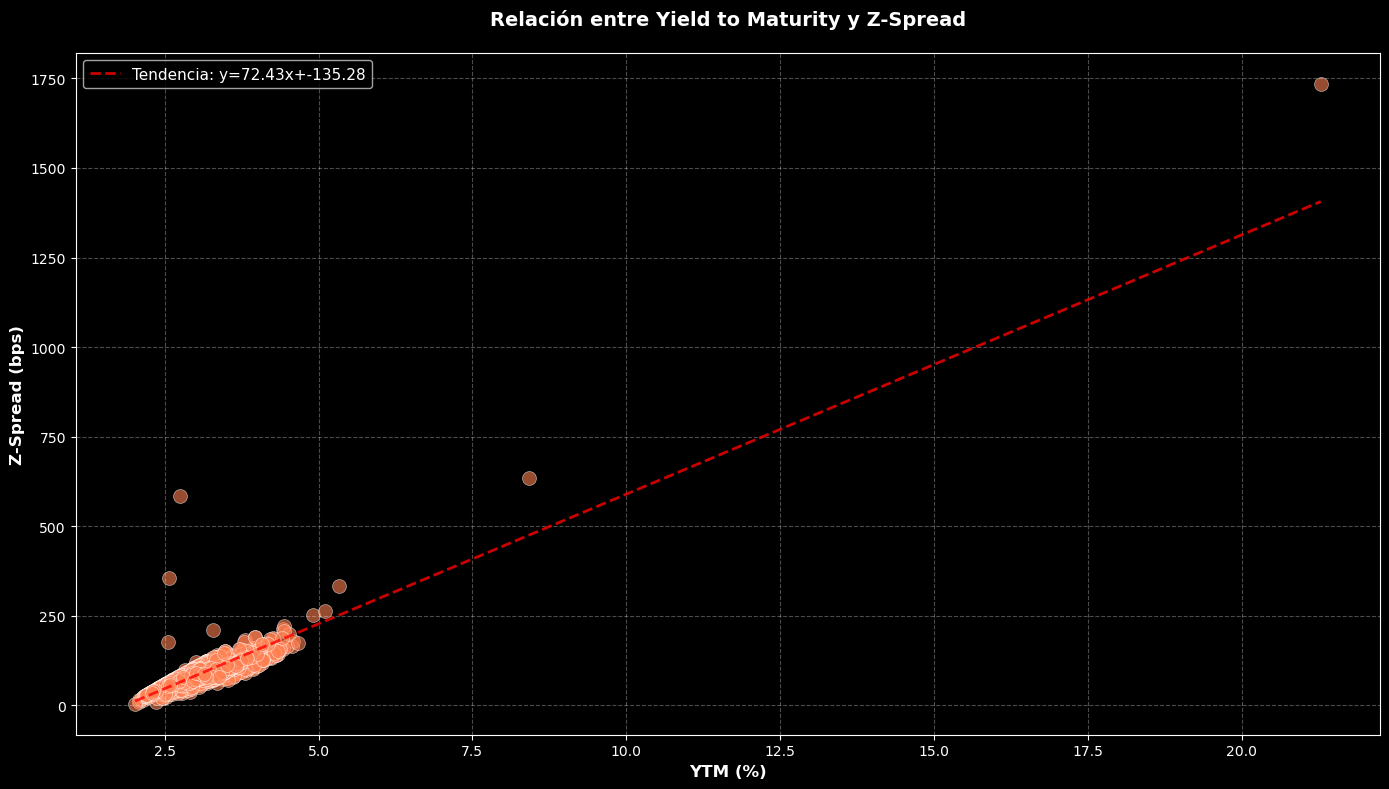


ANÁLISIS DE LA RELACIÓN YTM - Z-SPREAD

Correlación entre YTM y Z-Spread: 0.9023

Promedio YTM: 2.97%
Promedio Z-Spread: 79.55 bps

INTERPRETACIÓN

RELACIÓN YTM vs Z-SPREAD:

1. YTM (Yield to Maturity):
   - Tasa ÚNICA que descuenta todos los flujos del bono
   - Incluye TANTO tasa libre de riesgo COMO spread de crédito
   - YTM = Tasa libre de riesgo implícita + Spread de crédito

2. Z-SPREAD:
   - Spread CONSTANTE que se SUMA a la curva libre de riesgo (ESTR)
   - Aísla el componente de CRÉDITO del yield total
   - Mide la prima por riesgo crediticio y liquidez

3. RELACIÓN ESPERADA:
   - Correlación POSITIVA: Mayor YTM → Mayor Z-Spread
   - YTM incorpora el nivel de la curva libre de riesgo
   - Z-Spread aísla solo la prima de crédito

4. DIFERENCIAS CLAVE:
   - Bonos con MISMO Z-Spread pueden tener DIFERENTE YTM
     (si tienen diferente vencimiento → diferente tasa libre de riesgo)
   - Z-Spread es mejor para COMPARAR bonos con diferentes vencimientos
   - YTM es mejor para calcu

In [59]:
# Crear scatter plot entre YTM y Z-Spread
plt.figure(figsize=(14, 8))

# Filtrar valores válidos (no NaN)
datos_validos = df_flujos[['YTM_pct', 'Z_Spread_bps']].dropna()

# Crear scatter plot
plt.scatter(datos_validos['YTM_pct'], 
            datos_validos['Z_Spread_bps'],
            alpha=0.6, 
            s=100, 
            c='coral',
            edgecolors='white',
            linewidth=0.5)

# Añadir línea de tendencia
z = np.polyfit(datos_validos['YTM_pct'], datos_validos['Z_Spread_bps'], 1)
p = np.poly1d(z)
plt.plot(datos_validos['YTM_pct'].sort_values(), 
         p(datos_validos['YTM_pct'].sort_values()),
         "r--", 
         alpha=0.8, 
         linewidth=2,
         label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('YTM (%)', fontsize=12, fontweight='bold')
plt.ylabel('Z-Spread (bps)', fontsize=12, fontweight='bold')
plt.title('Relación entre Yield to Maturity y Z-Spread', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print(f'\n{"="*80}')
print('ANÁLISIS DE LA RELACIÓN YTM - Z-SPREAD')
print('='*80)
print(f'\nCorrelación entre YTM y Z-Spread: {datos_validos[["YTM_pct", "Z_Spread_bps"]].corr().iloc[0,1]:.4f}')
print(f'\nPromedio YTM: {datos_validos["YTM_pct"].mean():.2f}%')
print(f'Promedio Z-Spread: {datos_validos["Z_Spread_bps"].mean():.2f} bps')

# Interpretación
print(f'\n{"="*80}')
print('INTERPRETACIÓN')
print('='*80)
print('''
RELACIÓN YTM vs Z-SPREAD:

1. YTM (Yield to Maturity):
   - Tasa ÚNICA que descuenta todos los flujos del bono
   - Incluye TANTO tasa libre de riesgo COMO spread de crédito
   - YTM = Tasa libre de riesgo implícita + Spread de crédito

2. Z-SPREAD:
   - Spread CONSTANTE que se SUMA a la curva libre de riesgo (ESTR)
   - Aísla el componente de CRÉDITO del yield total
   - Mide la prima por riesgo crediticio y liquidez

3. RELACIÓN ESPERADA:
   - Correlación POSITIVA: Mayor YTM → Mayor Z-Spread
   - YTM incorpora el nivel de la curva libre de riesgo
   - Z-Spread aísla solo la prima de crédito
   
4. DIFERENCIAS CLAVE:
   - Bonos con MISMO Z-Spread pueden tener DIFERENTE YTM
     (si tienen diferente vencimiento → diferente tasa libre de riesgo)
   - Z-Spread es mejor para COMPARAR bonos con diferentes vencimientos
   - YTM es mejor para calcular RETORNO esperado si mantienes hasta vencimiento

La pendiente positiva indica que bonos de mayor riesgo (mayor spread)
también ofrecen mayor YTM total.
''')

Relacion entre duracion y vencimiento

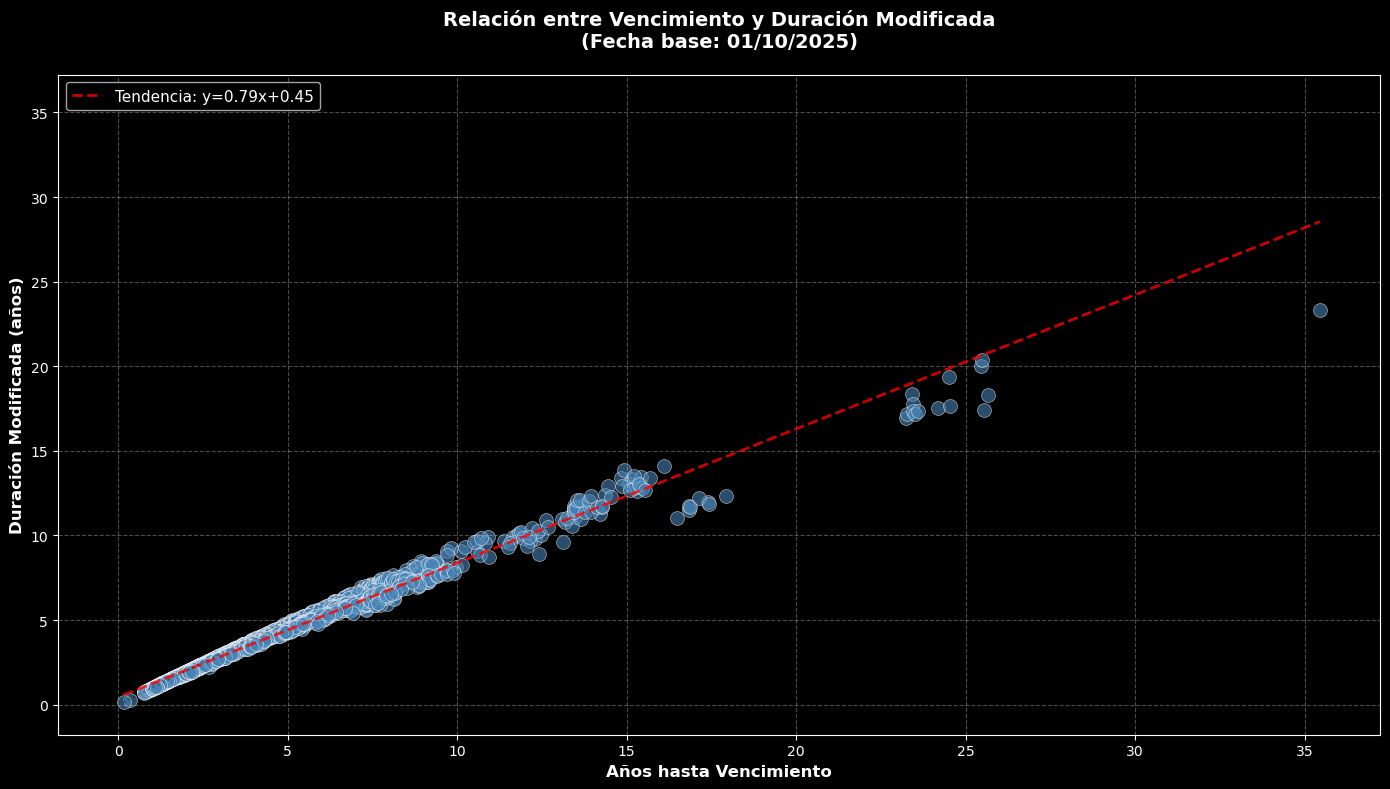


ANÁLISIS DE LA RELACIÓN VENCIMIENTO-DURACIÓN

Correlación entre Vencimiento y Duración: 0.9917

Promedio Años hasta Vencimiento: 4.24 años
Promedio Duración Modificada: 3.81 años

Ratio Duración/Vencimiento promedio: 92.77%

INTERPRETACIÓN

La duración modificada SIEMPRE es menor que el plazo hasta vencimiento porque:

1. CUPONES INTERMEDIOS: Los bonos pagan cupones antes del vencimiento,
   reduciendo el "tiempo promedio ponderado" de los flujos de caja.

2. EFECTO MATEMÁTICO: Duración ≈ Vencimiento solo para bonos cupón cero.
   Para bonos con cupón, Duración = f(Vencimiento, Cupón, YTM)

3. RELACIÓN TÍPICA: Duración ≈ 70-90% del Vencimiento para bonos corporativos

La pendiente de la línea de tendencia indica cuánto aumenta la duración
por cada año adicional de vencimiento en este universo de bonos.



In [58]:
# Crear scatter plot entre Fecha de Vencimiento Efectiva y Duración
plt.figure(figsize=(14, 8))

# Convertir fechas a años desde hoy para mejor visualización
fecha_hoy = pd.to_datetime('2025-10-01')
df_flujos['Anos_hasta_Vencimiento'] = (pd.to_datetime(df_flujos['Fecha_Vencimiento_Efectiva']) - fecha_hoy).dt.days / 365.25

# Crear scatter plot
plt.scatter(df_flujos['Anos_hasta_Vencimiento'], 
            df_flujos['Duracion_Modificada'],
            alpha=0.6, 
            s=100, 
            c='steelblue',
            edgecolors='white',
            linewidth=0.5)

# Añadir línea de tendencia
z = np.polyfit(df_flujos['Anos_hasta_Vencimiento'].dropna(), 
               df_flujos['Duracion_Modificada'].dropna(), 1)
p = np.poly1d(z)
plt.plot(df_flujos['Anos_hasta_Vencimiento'].sort_values(), 
         p(df_flujos['Anos_hasta_Vencimiento'].sort_values()),
         "r--", 
         alpha=0.8, 
         linewidth=2,
         label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('Años hasta Vencimiento', fontsize=12, fontweight='bold')
plt.ylabel('Duración Modificada (años)', fontsize=12, fontweight='bold')
plt.title('Relación entre Vencimiento y Duración Modificada\n(Fecha base: 01/10/2025)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='upper left')

# Añadir línea diagonal de referencia (Duración = Vencimiento)
max_val = max(df_flujos['Anos_hasta_Vencimiento'].max(), df_flujos['Duracion_Modificada'].max())
plt.plot([0, max_val], [0, max_val], 'k:', alpha=0.3, linewidth=1.5, label='Duración = Vencimiento')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print(f'\n{"="*80}')
print('ANÁLISIS DE LA RELACIÓN VENCIMIENTO-DURACIÓN')
print('='*80)
print(f'\nCorrelación entre Vencimiento y Duración: {df_flujos[["Anos_hasta_Vencimiento", "Duracion_Modificada"]].corr().iloc[0,1]:.4f}')
print(f'\nPromedio Años hasta Vencimiento: {df_flujos["Anos_hasta_Vencimiento"].mean():.2f} años')
print(f'Promedio Duración Modificada: {df_flujos["Duracion_Modificada"].mean():.2f} años')
print(f'\nRatio Duración/Vencimiento promedio: {(df_flujos["Duracion_Modificada"] / df_flujos["Anos_hasta_Vencimiento"]).mean():.2%}')

# Interpretación
print(f'\n{"="*80}')
print('INTERPRETACIÓN')
print('='*80)
print('''
La duración modificada SIEMPRE es menor que el plazo hasta vencimiento porque:

1. CUPONES INTERMEDIOS: Los bonos pagan cupones antes del vencimiento,
   reduciendo el "tiempo promedio ponderado" de los flujos de caja.

2. EFECTO MATEMÁTICO: Duración ≈ Vencimiento solo para bonos cupón cero.
   Para bonos con cupón, Duración = f(Vencimiento, Cupón, YTM)

3. RELACIÓN TÍPICA: Duración ≈ 70-90% del Vencimiento para bonos corporativos

La pendiente de la línea de tendencia indica cuánto aumenta la duración
por cada año adicional de vencimiento en este universo de bonos.
''')

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

Rango de fechas común: 02/10/2023 - 01/10/2025
Fechas en precios_bonos: 523
Fechas en benchmark: 514

Total de fechas de rebalanceo: 25

Iniciando backtest con Total Return (precio + cupones)...
Periodos de rebalanceo: 24

RESULTADOS DEL BACKTEST
Retorno Total Cartera (Total Return): 14.67%
Retorno Total Benchmark (Total Return): 13.13%
Diferencia (Alpha): 1.54%


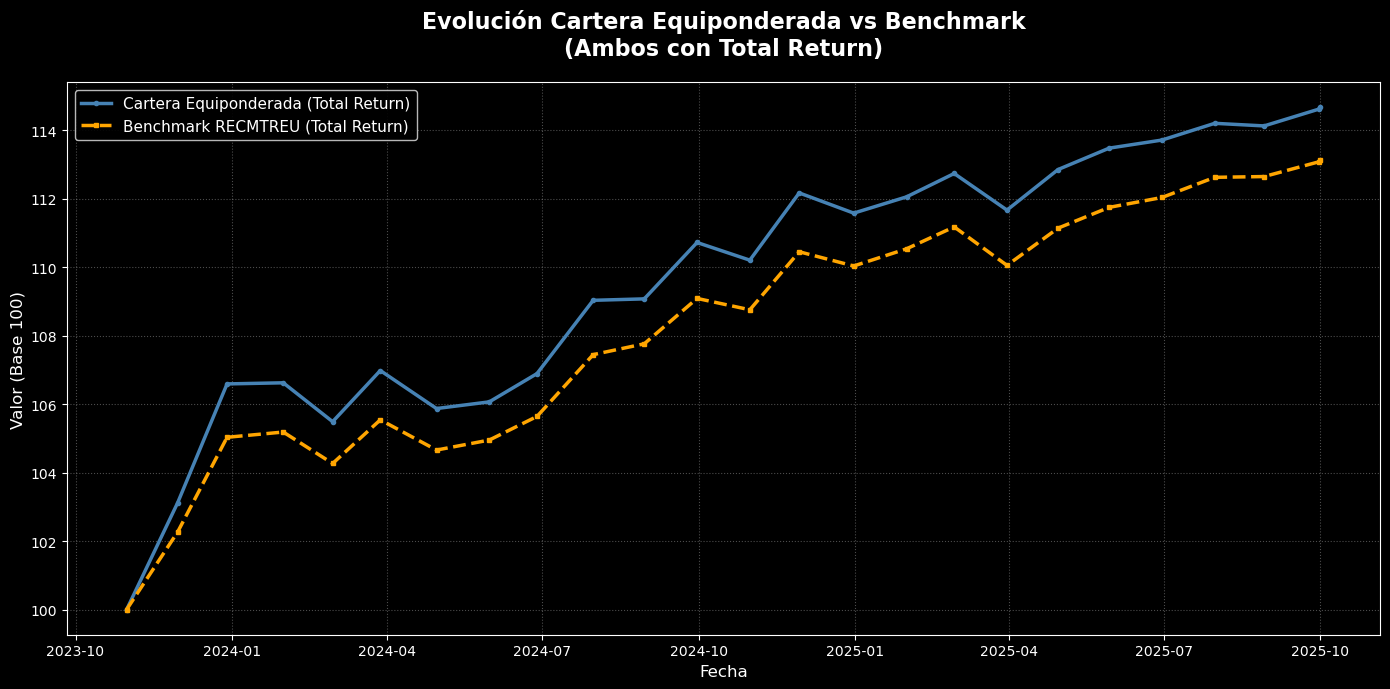

In [62]:
# ============================================================================
# BACKTEST CARTERA EQUIPONDERADA CON TOTAL RETURN
# ============================================================================
# Usar el DataFrame de universo cargado anteriormente
universo = df.copy()

# ----------------------------------------------------------------------------
# 0. FUNCION AUXILIAR PARA PARSEAR FECHAS
# ----------------------------------------------------------------------------
# 0. FUNCIÓN AUXILIAR PARA PARSEAR FECHAS
# ----------------------------------------------------------------------------
def _parsear_fecha(fecha_str):
    """
    Convierte una fecha en formato string a datetime.
    Intenta varios formatos comunes.
    """
    if fecha_str is None or (isinstance(fecha_str, str) and not fecha_str.strip()):
        return None
    
    if isinstance(fecha_str, pd.Timestamp):
        return fecha_str
    
    if isinstance(fecha_str, str):
        formatos = ['%d/%m/%Y', '%d/%m/%y', '%Y-%m-%d', '%d-%m-%Y']
        for fmt in formatos:
            try:
                return pd.to_datetime(fecha_str, format=fmt)
            except:
                continue
    
    try:
        return pd.to_datetime(fecha_str)
    except:
        return None

# ----------------------------------------------------------------------------
# 1. FUNCIÓN PARA GENERAR FECHAS DE CUPÓN
# ----------------------------------------------------------------------------

def generar_fechas_cupon(bono_caracteristicas, fecha_inicio, fecha_fin):
    """
    Genera las fechas de pago de cupón de un bono entre dos fechas.
    
    Args:
        bono_caracteristicas: Diccionario con las características del bono
        fecha_inicio: Fecha inicial del período (exclusivo)
        fecha_fin: Fecha final del período (inclusivo)
    
    Returns:
        Lista de fechas de cupón que caen en el período
    """
    
    coupon_freq = int(bono_caracteristicas.get('Coupon Frequency', 0))
    if coupon_freq == 0:
        return []
    
    callable_flag = bono_caracteristicas.get('Callable', 'N')
    maturity = bono_caracteristicas.get('Maturity')
    fecha_vencimiento = _parsear_fecha(maturity)
    
    # Bono perpetuo: usar próxima fecha call como vencimiento
    if fecha_vencimiento is None or (isinstance(maturity, str) and not maturity.strip()):
        next_call_date = bono_caracteristicas.get('Next Call Date')
        if callable_flag == 'Y' and next_call_date:
            fecha_vencimiento = _parsear_fecha(next_call_date)
        else:
            return []
    
    # Si es callable, usar fecha call si es anterior al vencimiento
    if callable_flag == 'Y':
        next_call_date = bono_caracteristicas.get('Next Call Date')
        if next_call_date:
            fecha_call = _parsear_fecha(next_call_date)
            if fecha_call and fecha_call < fecha_vencimiento:
                fecha_vencimiento = fecha_call
    
    # Generar fechas de cupón
    fecha_primer_cupon = _parsear_fecha(bono_caracteristicas.get('First Coupon Date')) or fecha_vencimiento
    
    meses_por_periodo = {1: 12, 2: 6, 4: 3, 12: 1}.get(coupon_freq)
    if meses_por_periodo:
        periodo = pd.DateOffset(months=meses_por_periodo)
    else:
        periodo = timedelta(days=int(365 / coupon_freq))
    
    fechas_cupon = []
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        fecha_actual += periodo
        if fecha_actual > fecha_vencimiento:
            break
    
    # Asegurar que el vencimiento está incluido
    if fechas_cupon and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento
    
    # Filtrar solo las fechas que caen en el período de interés
    fechas_en_periodo = [f for f in fechas_cupon if fecha_inicio < f <= fecha_fin]
    
    return fechas_en_periodo

# ----------------------------------------------------------------------------
# 2. PREPARACIÓN DE DATOS
# ----------------------------------------------------------------------------

# Copiar y preparar precios de bonos
precios_bonos = df_precios_universo.set_index('ISIN').copy()
precios_bonos.index.name = None
precios_bonos.columns = pd.to_datetime(precios_bonos.columns, format='%d/%m/%Y', errors='coerce')
precios_bonos = precios_bonos.sort_index(axis=1)
precios_bonos = precios_bonos.T

# Convertir a numérico para evitar errores de tipo
for col in precios_bonos.columns:
    precios_bonos[col] = pd.to_numeric(precios_bonos[col], errors='coerce')

# Preparar benchmark (RECMTREU es un índice Total Return)
benchmark_series = df_precios_varios.set_index('Unnamed: 0')['RECMTREU Index'].copy()
benchmark_series.index = pd.to_datetime(benchmark_series.index, format='%d/%m/%Y')
benchmark_series = benchmark_series.sort_index()
benchmark_series = pd.to_numeric(benchmark_series, errors='coerce')
benchmark_series = benchmark_series.sort_index()
benchmark_series = pd.to_numeric(benchmark_series, errors='coerce')

# ----------------------------------------------------------------------------
# 3. ALINEAR FECHAS ENTRE CARTERA Y BENCHMARK
# ----------------------------------------------------------------------------

# Encontrar el rango de fechas común
fecha_inicio_comun = max(precios_bonos.index.min(), benchmark_series.index.min())
fecha_fin_comun = min(precios_bonos.index.max(), benchmark_series.index.max())

# Filtrar ambos DataFrames al rango común
precios_bonos = precios_bonos[(precios_bonos.index >= fecha_inicio_comun) &
                               (precios_bonos.index <= fecha_fin_comun)]
benchmark_series = benchmark_series[(benchmark_series.index >= fecha_inicio_comun) &
                                     (benchmark_series.index <= fecha_fin_comun)]

print(f'Rango de fechas común: {fecha_inicio_comun.strftime("%d/%m/%Y")} - {fecha_fin_comun.strftime("%d/%m/%Y")}')
print(f'Fechas en precios_bonos: {len(precios_bonos)}')
print(f'Fechas en benchmark: {len(benchmark_series)}')

# ----------------------------------------------------------------------------
# 4. GENERAR FECHAS DE REBALANCEO MENSUAL
# ----------------------------------------------------------------------------

# Obtener últimos días de cada mes
fechas_mensuales = precios_bonos.index.to_series().resample('ME').last().index
fechas_rebalanceo = []

for fecha in fechas_mensuales:
    # Buscar fechas disponibles en ambas series
    disponibles_bonos = precios_bonos.index[precios_bonos.index <= fecha]
    disponibles_benchmark = benchmark_series.index[benchmark_series.index <= fecha]
    
    if not disponibles_bonos.empty and not disponibles_benchmark.empty:
        fecha_bonos = disponibles_bonos[-1]
        fecha_benchmark = disponibles_benchmark[-1]
        
        # Usar la fecha que esté disponible en ambas series
        if fecha_bonos in benchmark_series.index:
            fechas_rebalanceo.append(fecha_bonos)
        elif fecha_benchmark in precios_bonos.index:
            fechas_rebalanceo.append(fecha_benchmark)
            
fechas_rebalanceo = sorted(list(set(fechas_rebalanceo)))
print(f'\nTotal de fechas de rebalanceo: {len(fechas_rebalanceo)}')

# ----------------------------------------------------------------------------
# 5. CREAR DICCIONARIO DE BONOS PARA ACCESO RÁPIDO
# ----------------------------------------------------------------------------

bonos_dict = {}
for _, bono in universo.iterrows():
    isin = bono['ISIN']
    bonos_dict[isin] = bono.to_dict()

# ----------------------------------------------------------------------------
# 6. EJECUTAR BACKTEST
# ----------------------------------------------------------------------------

capital_inicial = 100
valor_cartera = [capital_inicial]
fechas_cartera = [fechas_rebalanceo[0]]

print(f'\nIniciando backtest con Total Return (precio + cupones)...')
print(f'Periodos de rebalanceo: {len(fechas_rebalanceo)-1}')

for i in range(len(fechas_rebalanceo) - 1):
    fecha_inicio = fechas_rebalanceo[i]
    fecha_fin = fechas_rebalanceo[i+1]
    
    # Precios actuales y futuros
    precios_t0 = precios_bonos.loc[fecha_inicio].dropna()
    precios_t1 = precios_bonos.loc[fecha_fin]
    
    # Bonos vivos (disponibles en ambas fechas)
    bonos_cartera = precios_t0.index.intersection(precios_t1.dropna().index)
    
    if len(bonos_cartera) > 0:
        retornos_totales = []
        
        for isin in bonos_cartera:
            p0 = precios_t0[isin]
            p1 = precios_t1[isin]
            
            # Calcular cupones recibidos en el período
            cupones_recibidos = 0
            
            # Extraer el ISIN sin el sufijo ' Corp'
            isin_limpio = isin.replace(' Corp', '')
            
            if isin_limpio in bonos_dict:
                bono_info = bonos_dict[isin_limpio]
                fechas_cupon_periodo = generar_fechas_cupon(bono_info, fecha_inicio, fecha_fin)
                
                if fechas_cupon_periodo:
                    coupon_rate = float(bono_info.get('Coupon', 0))
                    coupon_freq = int(bono_info.get('Coupon Frequency', 1))
                    
                    # Cada fecha de cupón representa un pago
                    # Cupón anual / frecuencia = cupón por pago
                    cupon_por_pago = (coupon_rate / 100) * 100 / coupon_freq
                    cupones_recibidos = len(fechas_cupon_periodo) * cupon_por_pago
            
            # Retorno total = (precio_final - precio_inicial + cupones) / precio_inicial
            retorno_total = ((p1 - p0) + cupones_recibidos) / p0
            retornos_totales.append(retorno_total)
        
        # Retorno promedio de la cartera equiponderada
        retorno_promedio = np.mean(retornos_totales) if retornos_totales else 0.0
    else:
        retorno_promedio = 0.0
        
    # Actualizar valor de la cartera
    nuevo_valor = valor_cartera[-1] * (1 + retorno_promedio)
    valor_cartera.append(nuevo_valor)
    fechas_cartera.append(fecha_fin)

# Crear serie temporal de la cartera
serie_cartera = pd.Series(valor_cartera, index=fechas_cartera)

# ----------------------------------------------------------------------------
# 7. PREPARAR BENCHMARK PARA COMPARACIÓN
# ----------------------------------------------------------------------------

benchmark_cut = benchmark_series.loc[benchmark_series.index.isin(fechas_cartera)]

# Si faltan fechas en el benchmark, rellenar con el último valor disponible
if len(benchmark_cut) < len(fechas_cartera):
    benchmark_completo = pd.Series(index=fechas_cartera, dtype=float)
    
    for fecha in fechas_cartera:
        if fecha in benchmark_series.index:
            benchmark_completo[fecha] = benchmark_series[fecha]
        else:
            fechas_anteriores = benchmark_series.index[benchmark_series.index < fecha]
            if len(fechas_anteriores) > 0:
                fecha_anterior = fechas_anteriores[-1]
                benchmark_completo[fecha] = benchmark_series[fecha_anterior]
    
    benchmark_cut = benchmark_completo

# Normalizar benchmark a base 100
benchmark_base100 = benchmark_cut / benchmark_cut.iloc[0] * 100

# ----------------------------------------------------------------------------
# 8. CALCULAR MÉTRICAS DE RENDIMIENTO
# ----------------------------------------------------------------------------

retorno_total_cartera = (serie_cartera.iloc[-1] / serie_cartera.iloc[0]) - 1
retorno_total_benchmark = (benchmark_base100.iloc[-1] / benchmark_base100.iloc[0]) - 1

print(f'\n{"="*60}')
print('RESULTADOS DEL BACKTEST')
print("="*60)
print(f'Retorno Total Cartera (Total Return): {retorno_total_cartera:.2%}')
print(f'Retorno Total Benchmark (Total Return): {retorno_total_benchmark:.2%}')
print(f'Diferencia (Alpha): {(retorno_total_cartera - retorno_total_benchmark):.2%}')
print("="*60)

# ----------------------------------------------------------------------------
# 9. VISUALIZACIÓN
# ----------------------------------------------------------------------------

plt.figure(figsize=(14, 7))
plt.plot(serie_cartera, label='Cartera Equiponderada (Total Return)', 
         linewidth=2.5, color='steelblue', marker='o', markersize=3)
plt.plot(benchmark_base100, label='Benchmark RECMTREU (Total Return)', 
         linewidth=2.5, linestyle='--', color='orange', marker='s', markersize=3)
plt.title('Evolución Cartera Equiponderada vs Benchmark\n(Ambos con Total Return)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor (Base 100)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
plt.legend(fontsize=11, loc='best', framealpha=0.9)
plt.tight_layout()
plt.show()

In [63]:
# ============================================================================
# RESPUESTAS A LAS PREGUNTAS
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS Y REFLEXIONES")
print("="*80)

print("\n📌 ¿Qué sería lo más correcto en lugar de utilizar los precios MID?")
print("-" * 80)
print("""
Lo más correcto sería utilizar:
- Precios BID para las valoraciones de SALIDA (cuando vendemos el bono)
- Precios ASK para las valoraciones de ENTRADA (cuando compramos el bono)

Esto incorporaría los costes de transacción implícitos (bid-ask spread) y 
reflejaría de manera más realista los costes de trading. El spread bid-ask
es un coste oculto pero real que afecta significativamente al rendimiento,
especialmente en bonos menos líquidos.

En el contexto de este backtest:
- Al REBALANCEAR (comprar nuevos bonos): usar precio ASK
- Al VALORAR la cartera (calcular retornos): usar precio BID
- Esto reduciría el retorno total de la cartera y sería más conservador
""" )

print("\n📌 ¿Se te ocurre algún otro benchmark que se podría utilizar?")
print("-" * 80)
print("""
Benchmarks alternativos que podrían ser más apropiados:

1. ÍNDICE CON FILTRO DE LIQUIDEZ:
   - Un índice de bonos corporativos que solo contenga bonos líquidos
   - Criterio: volumen de negociación mínimo diario/semanal
   - Ventaja: Los precios reflejan transacciones reales, no valoraciones teóricas
   
2. ÍNDICE SECTORIAL ESPECÍFICO:
   - Si nuestra cartera tiene concentración sectorial
   - Ejemplo: Índice de bonos financieros europeos
   
3. ÍNDICE CON FILTRO DE RATING:
   - Si nuestra cartera tiene un sesgo hacia Investment Grade o High Yield
   - Ejemplo: iBoxx EUR Corporates IG o HY
   
4. BENCHMARK PERSONALIZADO:
   - Combinación ponderada de varios índices
   - Ejemplo: 70% IG + 30% HY según composición de cartera
   
5. CASH + MARGEN (Hurdle Rate):
   - ESTR (€STR) + spread objetivo (ej. +200 bps)
   - Útil para evaluar si la estrategia genera valor real

La elección depende de:
- Objetivo de inversión
- Perfil de riesgo de la cartera
- Horizonte temporal
- Liquidez requerida
""")

print("\n" + "="*80)


ANÁLISIS Y REFLEXIONES

📌 ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
--------------------------------------------------------------------------------

Lo más correcto sería utilizar:
- Precios BID para las valoraciones de SALIDA (cuando vendemos el bono)
- Precios ASK para las valoraciones de ENTRADA (cuando compramos el bono)

Esto incorporaría los costes de transacción implícitos (bid-ask spread) y 
reflejaría de manera más realista los costes de trading. El spread bid-ask
es un coste oculto pero real que afecta significativamente al rendimiento,
especialmente en bonos menos líquidos.

En el contexto de este backtest:
- Al REBALANCEAR (comprar nuevos bonos): usar precio ASK
- Al VALORAR la cartera (calcular retornos): usar precio BID
- Esto reduciría el retorno total de la cartera y sería más conservador


📌 ¿Se te ocurre algún otro benchmark que se podría utilizar?
--------------------------------------------------------------------------------

Benchmarks alt

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

In [64]:
# ============================================================================
# CONSTRUCCIÓN DE CARTERA ÓPTIMA - PROGRAMACIÓN LINEAL ENTERA MIXTA
# ============================================================================
print('='*80)
print('CONSTRUCCIÓN DE CARTERA ÓPTIMA CON MANDATO')
print('='*80)

# ----------------------------------------------------------------------------
# PASO 1: PREPARACIÓN DE DATOS
# ----------------------------------------------------------------------------

# Cargar datos de TIR y duración
# Primero intentar usar las variables en memoria (df_flujos)
# Si no existe, intentar cargar desde CSV

try:
    # Verificar si df_flujos existe en memoria con las columnas necesarias
    if 'df_flujos' in globals() and 'YTM' in df_flujos.columns and 'Duracion_Modificada' in df_flujos.columns:
        print('✓ Usando datos de TIR y duración desde df_flujos (en memoria)')
        # Preparar datos con renombre de columna YTM -> TIR
        df_ytm_duracion = df_flujos[['ISIN', 'YTM', 'Duracion_Modificada']].copy()
        df_ytm_duracion = df_ytm_duracion.rename(columns={'YTM': 'TIR'})
        # Convertir TIR de decimal a porcentaje (YTM está en decimal, TIR lo queremos en %)
        df_ytm_duracion['TIR'] = df_ytm_duracion['TIR'] * 100
    else:
        # Intentar cargar desde archivo CSV
        print('⚠ df_flujos no disponible en memoria, intentando cargar desde CSV...')
        df_ytm_duracion = pd.read_csv('../data/ytm_duracion_convexidad.csv', sep=';')
        print('✓ Datos de TIR y duración cargados desde CSV')
except Exception as e:
    print(f'\n❌ ERROR: No se pudieron cargar los datos de TIR y duración')
    print(f'  Error: {str(e)}')
    print(f'\n  Asegúrate de haber ejecutado las celdas anteriores del Punto 4 que calculan:')
    print(f'    - YTM (Yield to Maturity)')
    print(f'    - Duración Modificada')
    print(f'    - Convexidad')
    raise

# Merge con universo para tener toda la información
universo_completo = universo.merge(
    df_ytm_duracion[['ISIN', 'TIR', 'Duracion_Modificada']],
    on='ISIN',
    how='left'
)

print(f'✓ Merge completado: {len(universo_completo)} bonos en universo_completo')
print(f'  - Bonos con TIR: {universo_completo["TIR"].notna().sum()}')
print(f'  - Bonos con Duración: {universo_completo["Duracion_Modificada"].notna().sum()}')

# ----------------------------------------------------------------------------
# PASO 2: APLICAR RESTRICCIONES DURAS (FILTRADO PREVIO)
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('FILTRADO INICIAL - RESTRICCIONES DURAS')
print('='*80)

# Filtro 1: Eliminar subordinados
universo_filtrado = universo_completo[
    ~universo_completo['Seniority'].isin(['Subordinated', 'Jr Subordinated'])
].copy()
print(f'✓ Después de eliminar subordinados: {len(universo_filtrado)} bonos')

# Filtro 2: Outstanding Amount > 500M
universo_filtrado = universo_filtrado[
    universo_filtrado['Outstanding Amount'] > 500_000_000
].copy()
print(f'✓ Después de filtrar por tamaño (>500M): {len(universo_filtrado)} bonos')

# Filtro 3: Eliminar bonos sin TIR o duración
universo_filtrado = universo_filtrado[
    universo_filtrado['TIR'].notna() &
    universo_filtrado['Duracion_Modificada'].notna()
].copy()
print(f'✓ Después de eliminar bonos sin TIR/Duración: {len(universo_filtrado)} bonos')

# Clasificar HY vs IG
hy_ratings = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC', 'CC', 'C', 'D', 'NR']
universo_filtrado['Es_HY'] = (
    universo_filtrado['Rating'].isna() |
    (universo_filtrado['Rating'] == 'NR') |
    universo_filtrado['Rating'].isin(hy_ratings)
)

print(f'\nClasificación crediticia:')
print(f'  - Bonos HY: {universo_filtrado["Es_HY"].sum()}')
print(f'  - Bonos IG: {(~universo_filtrado["Es_HY"]).sum()}')

# ----------------------------------------------------------------------------
# PASO 3: OPTIMIZACIÓN CON PROGRAMACIÓN LINEAL ENTERA MIXTA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('OPTIMIZACIÓN - PROGRAMACIÓN LINEAL ENTERA MIXTA')
print('='*80)

# Resetear índice para facilitar acceso
universo_filtrado = universo_filtrado.reset_index(drop=True)
n_bonos = len(universo_filtrado)

print(f'\nFormulando problema de optimización...')
print(f'Variables de decisión: {n_bonos} bonos candidatos')

# Crear mapeo de índice a ISIN
isin_map = {i: universo_filtrado.loc[i, 'ISIN'] for i in range(n_bonos)}

# Función para limpiar nombres de restricciones
def clean_name(name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', name)

# Crear el problema de optimización
prob = LpProblem("Portfolio_Optimization", LpMaximize)

# Variables de decisión:
# x[i]: variable binaria (0 o 1) - si el bono i está en la cartera
# w[i]: variable continua [0, 0.10] - peso del bono i en la cartera
x = {i: LpVariable(f"x_{clean_name(isin_map[i])}", cat='Binary') for i in range(n_bonos)}
w = {i: LpVariable(f"w_{clean_name(isin_map[i])}", lowBound=0, upBound=0.10) for i in range(n_bonos)}

# FUNCIÓN OBJETIVO: Maximizar TIR promedio ponderada
prob += lpSum([w[i] * universo_filtrado.loc[i, 'TIR'] for i in range(n_bonos)]), "TIR_Objetivo"

# ----------------------------------------------------------------------------
# PASO 4: AÑADIR RESTRICCIONES
# ----------------------------------------------------------------------------

print(f'\nAñadiendo restricciones del mandato:')

# Restricción 1: Los pesos deben sumar 1 (100%)
prob += lpSum([w[i] for i in range(n_bonos)]) == 1, "Suma_Pesos"
print('  ✓ Suma de pesos = 100%')

# Restricción 2: Máximo 20 bonos en la cartera
prob += lpSum([x[i] for i in range(n_bonos)]) <= 20, "Max_20_Bonos"
print('  ✓ Máximo 20 bonos')

# Restricción 3: Si un bono no está seleccionado (xi=0), su peso debe ser 0
# Si está seleccionado (xi=1), debe tener al menos 0.1% (peso mínimo realista)
for i in range(n_bonos):
    prob += w[i] <= x[i] * 0.10, f"Link_Max_{clean_name(isin_map[i])}"
    prob += w[i] >= x[i] * 0.001, f"Link_Min_{clean_name(isin_map[i])}"
print('  ✓ Linkage entre selección y peso')

# Restricción 4: Duración de la cartera ≤ 3 años
prob += lpSum([w[i] * universo_filtrado.loc[i, 'Duracion_Modificada']
               for i in range(n_bonos)]) <= 3.0, "Duracion_Max"
print('  ✓ Duración ≤ 3 años')

# Restricción 5: Exposición a HY ≤ 10%
prob += lpSum([w[i] * (1 if universo_filtrado.loc[i, 'Es_HY'] else 0)
               for i in range(n_bonos)]) <= 0.10, "HY_Max"
print('  ✓ Exposición HY ≤ 10%')

# Restricción 6: Peso máximo por emisión: 10% (ya incluido en definición de w)
print('  ✓ Peso por emisión ≤ 10%')

# Restricción 7: Concentración por emisor ≤ 15%
emisores_unicos = universo_filtrado['Issuer'].unique()
for emisor in emisores_unicos:
    indices_emisor = universo_filtrado[universo_filtrado['Issuer'] == emisor].index.tolist()
    if len(indices_emisor) > 0:
        primer_isin = universo_filtrado.loc[indices_emisor[0], 'ISIN']
        prob += lpSum([w[i] for i in indices_emisor]) <= 0.15, f"Emisor_{clean_name(primer_isin)}"
print(f'  ✓ Concentración por emisor ≤ 15% ({len(emisores_unicos)} emisores)')

# ----------------------------------------------------------------------------
# PASO 5: RESOLVER EL PROBLEMA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('RESOLVIENDO PROBLEMA DE OPTIMIZACIÓN...')
print('='*80)
print('(Esto puede tardar unos segundos)')

# Resolver el problema (msg=0 para no mostrar output del solver)
prob.solve(PULP_CBC_CMD(msg=0))

# Verificar estado de la solución
print(f'\nEstado: {LpStatus[prob.status]}')

# ----------------------------------------------------------------------------
# PASO 6: EXTRAER Y ANALIZAR RESULTADOS
# ----------------------------------------------------------------------------

if prob.status == 1:  # Óptimo encontrado
    print(f'✓ Solución óptima encontrada')
    print(f'\nTIR óptima de la cartera: {value(prob.objective):.4f}%')

    # Extraer solución
    bonos_seleccionados = []
    pesos_seleccionados = []

    for i in range(n_bonos):
        if x[i].varValue > 0.5:  # Bono seleccionado
            bonos_seleccionados.append(i)
            pesos_seleccionados.append(w[i].varValue)

    # Crear DataFrame de la cartera óptima
    cartera_optima = universo_filtrado.loc[bonos_seleccionados].copy()
    cartera_optima['Peso'] = pesos_seleccionados
    cartera_optima = cartera_optima.sort_values('TIR', ascending=False).reset_index(drop=True)

    # ----------------------------------------------------------------------------
    # RESULTADOS PRINCIPALES
    # ----------------------------------------------------------------------------

    print(f'\n{"="*80}')
    print('CARTERA ÓPTIMA - COMPOSICIÓN')
    print('='*80)
    print(f'\nBonos seleccionados: {len(cartera_optima)}')

    # Métricas de rentabilidad
    tir_cartera = (cartera_optima['TIR'] * cartera_optima['Peso']).sum()
    print(f'TIR promedio ponderada: {tir_cartera:.4f}%')

    # Métricas de duración
    duracion_cartera = (cartera_optima['Duracion_Modificada'] * cartera_optima['Peso']).sum()
    print(f'Duración de la cartera: {duracion_cartera:.4f} años')

    # Métricas de crédito
    num_hy = cartera_optima['Es_HY'].sum()
    peso_hy = (cartera_optima['Es_HY'] * cartera_optima['Peso']).sum()
    print(f'Bonos HY: {num_hy} bonos ({peso_hy:.2%} del capital)')

    # ----------------------------------------------------------------------------
    # VERIFICACIÓN DE RESTRICCIONES
    # ----------------------------------------------------------------------------

    print(f'\n{"="*80}')
    print('VERIFICACIÓN DE RESTRICCIONES')
    print('='*80)

    print(f'\n✓ Número de bonos: {len(cartera_optima)} ≤ 20')
    print(f'✓ Suma de pesos: {cartera_optima["Peso"].sum():.4f} = 1.0')
    print(f'✓ Duración: {duracion_cartera:.4f} ≤ 3.0 años')
    print(f'✓ Exposición HY: {peso_hy:.4f} ≤ 0.10')
    print(f'✓ Sin deuda subordinada: {cartera_optima["Seniority"].isin(["Subordinated", "Jr Subordinated"]).sum()} bonos')
    print(f'✓ Tamaño mínimo: {(cartera_optima["Outstanding Amount"] > 500_000_000).sum()} de {len(cartera_optima)} > 500M')
    print(f'✓ Peso máximo por emisión: {cartera_optima["Peso"].max():.4f} ≤ 0.10')

    concentracion_emisor = cartera_optima.groupby('Issuer')['Peso'].sum().sort_values(ascending=False)
    print(f'✓ Concentración máxima por emisor: {concentracion_emisor.max():.4f} ≤ 0.15')

    # ----------------------------------------------------------------------------
    # DETALLE DE LA COMPOSICIÓN
    # ----------------------------------------------------------------------------

    print(f'\n{"="*80}')
    print('DETALLE DE BONOS EN LA CARTERA (Ordenados por TIR)')
    print('='*80)
    print()

    display_cols = ['ISIN', 'Issuer', 'Rating', 'Es_HY', 'TIR',
                    'Duracion_Modificada', 'Outstanding Amount', 'Peso']
    print(cartera_optima[display_cols].to_string(index=False))

    # Concentración por emisor
    print(f'\n{"="*80}')
    print('CONCENTRACIÓN POR EMISOR')
    print('='*80)
    for emisor, peso in concentracion_emisor.items():
        num_bonos = len(cartera_optima[cartera_optima['Issuer'] == emisor])
        print(f'{emisor:40s}: {peso:6.2%} ({num_bonos} bonos)')

    # Mostrar bonos HY si los hay
    if num_hy > 0:
        print(f'\n{"="*80}')
        print(f'BONOS HIGH YIELD EN LA CARTERA ({num_hy} bonos)')
        print('='*80)
        bonos_hy = cartera_optima[cartera_optima['Es_HY']]
        for idx, bono in bonos_hy.iterrows():
            rating_display = bono['Rating'] if pd.notna(bono['Rating']) and bono['Rating'] != 'NR' else 'Sin Rating'
            print(f'{bono["ISIN"]} - {bono["Issuer"]:30s} - Rating: {rating_display:5s} - TIR: {bono["TIR"]:6.2f}% - Peso: {bono["Peso"]:6.2%}')

    # Guardar cartera
    try:
        cartera_optima.to_csv('../data/cartera_mandato.csv', index=False, sep=';')
        print(f'\n✓ Cartera guardada en: ../data/cartera_mandato.csv')
    except:
        print(f'\n⚠ No se pudo guardar la cartera (verifica la ruta)')

    # Guardar en variable global para usar en celdas siguientes
    globals()['cartera_mandato'] = cartera_optima

else:
    print(f'\n✗ No se encontró solución óptima')
    print(f'Estado: {LpStatus[prob.status]}')
    print('\nPosibles razones:')
    print('- Las restricciones son incompatibles (infeasible)')
    print('- El problema es unbounded')
    print('- Necesitas revisar los datos de entrada')


CONSTRUCCIÓN DE CARTERA ÓPTIMA CON MANDATO
✓ Usando datos de TIR y duración desde df_flujos (en memoria)
✓ Merge completado: 2255 bonos en universo_completo
  - Bonos con TIR: 2255
  - Bonos con Duración: 2255

FILTRADO INICIAL - RESTRICCIONES DURAS
✓ Después de eliminar subordinados: 2077 bonos
✓ Después de filtrar por tamaño (>500M): 1353 bonos
✓ Después de eliminar bonos sin TIR/Duración: 1353 bonos

Clasificación crediticia:
  - Bonos HY: 154
  - Bonos IG: 1199

OPTIMIZACIÓN - PROGRAMACIÓN LINEAL ENTERA MIXTA

Formulando problema de optimización...
Variables de decisión: 1353 bonos candidatos

Añadiendo restricciones del mandato:
  ✓ Suma de pesos = 100%
  ✓ Máximo 20 bonos
  ✓ Linkage entre selección y peso
  ✓ Duración ≤ 3 años
  ✓ Exposición HY ≤ 10%
  ✓ Peso por emisión ≤ 10%
  ✓ Concentración por emisor ≤ 15% (397 emisores)

RESOLVIENDO PROBLEMA DE OPTIMIZACIÓN...
(Esto puede tardar unos segundos)

Estado: Optimal
✓ Solución óptima encontrada

TIR óptima de la cartera: 5.3794%

##### <font color=#CC6600>Riesgo de crédito</font>

In [ ]:
# ============================================================================
# ANÁLISIS DE RIESGO DE CRÉDITO DE LA CARTERA
# ============================================================================

print('='*80)
print('ANÁLISIS DE RIESGO DE CRÉDITO')
print('='*80)

# Verificar que tenemos la cartera
if 'cartera_mandato' not in globals():
    print('⚠ Primero debes ejecutar la celda de construcción de cartera')
else:
    cartera = cartera_mandato.copy()
    
    # ------------------------------------------------------------------------
    # 1. PREGUNTA CONCEPTUAL: ¿Cómo medirías el riesgo de crédito?
    # ------------------------------------------------------------------------
    
    print('\n📌 ¿CÓMO MEDIR EL RIESGO DE CRÉDITO DE LA CARTERA?')
    print('-'*80)
    print('''
MÉTRICAS CUANTITATIVAS:

1. RATING PROMEDIO PONDERADO
   - Convertir ratings a escala numérica (AAA=1, AA=2, ..., D=10)
   - Calcular promedio ponderado por peso en cartera
   - Interpretación: Rating "efectivo" de la cartera

2. PROBABILIDAD DE DEFAULT (PD)
   - Usar matrices de transición de agencias (Moody\'s, S&P, Fitch)
   - PD histórica por rating: AAA=0.02%, BBB=0.3%, BB=1.5%, B=7%
   - PD de cartera = Σ (Peso_i × PD_i)

3. CREDIT SPREAD ANALYSIS
   - Dispersión de spreads sobre curva libre de riesgo (€STR)
   - Spread promedio ponderado
   - Volatilidad de spreads (proxy de incertidumbre crediticia)

4. DURATION TIMES SPREAD (DTS)
   - DTS_i = Duración_i × Spread_i
   - Sensibilidad al ensanchamiento de spreads
   - DTS cartera = Σ (Peso_i × DTS_i)

5. CREDIT VAR (Value at Risk)
   - Pérdida máxima esperada con X% confianza (95%, 99%)
   - Métodos: Histórico, Monte Carlo, CreditMetrics
   - Incorpora correlaciones entre defaults

6. EXPECTED LOSS (EL)
   - EL = PD × LGD × EAD
   - PD: Probabilidad de default
   - LGD: Loss Given Default (típicamente 40-60% para senior)
   - EAD: Exposure at Default

MÉTRICAS CUALITATIVAS:

7. CONCENTRACIÓN POR RATING
   - ¿Cuánto peso en cada categoría de rating?
   - ¿Hay excesiva concentración en ratings bajos (BBB-, BB)?

8. CONCENTRACIÓN SECTORIAL
   - Sectores correlacionados → riesgo sistémico
   - Ejemplo: Crisis financiera 2008 → bancos correlacionados

9. ANÁLISIS DE COVENANTS
   - ¿Qué protecciones contractuales tenemos?
   - Change of control, negative pledge, cross-default

10. POSICIÓN EN ESTRUCTURA DE CAPITAL
    - Senior Secured > Senior Unsecured > Subordinated
    - Tasa de recuperación histórica en defaults

HERRAMIENTAS PRÁCTICAS:

- CDS Spreads: Mercado de credit default swaps como proxy
- Índices de crédito: Comparar con iTraxx Main, iTraxx Crossover
- Stress Testing: ¿Qué pasa si X empresa es downgradeada?
    ''')
    
    # ------------------------------------------------------------------------
    # 2. IMPLEMENTACIÓN: Métricas calculables con datos disponibles
    # ------------------------------------------------------------------------
    
    print('\n' + '='*80)
    print('ANÁLISIS CUANTITATIVO DE RIESGO DE CRÉDITO')
    print('='*80)
    
    # 2.1. Rating Promedio Ponderado
    print('\n1. RATING PROMEDIO PONDERADO')
    print('-'*80)
    
    # Mapeo de ratings a escala numérica
    rating_scores = {
        'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4,
        'A+': 5, 'A': 6, 'A-': 7,
        'BBB+': 8, 'BBB': 9, 'BBB-': 10,
        'BB+': 11, 'BB': 12, 'BB-': 13,
        'B+': 14, 'B': 15, 'B-': 16,
        'CCC': 17, 'CC': 18, 'C': 19, 'D': 20,
        'NR': 15  # Sin rating asumimos riesgo medio-alto
    }
    
    cartera['Rating_Score'] = cartera['Rating'].map(rating_scores)
    cartera['Rating_Score'] = cartera['Rating_Score'].fillna(15)  # NaN → 15
    
    rating_promedio = (cartera['Rating_Score'] * cartera['Peso']).sum()
    
    # Mapeo inverso para interpretar
    rating_interpretacion = {
        range(1, 4): 'AA (Muy Alta Calidad)',
        range(4, 8): 'A (Alta Calidad)',
        range(8, 11): 'BBB (Investment Grade medio)',
        range(11, 14): 'BB (High Yield alto)',
        range(14, 17): 'B (High Yield medio-bajo)',
        range(17, 21): 'CCC o inferior (Alto Riesgo)'
    }
    
    interpretacion = 'BBB (Investment Grade)'
    for rango, desc in rating_interpretacion.items():
        if int(rating_promedio) in rango:
            interpretacion = desc
            break
    
    print(f'Rating Promedio Ponderado: {rating_promedio:.2f}')
    print(f'Interpretación: {interpretacion}')
    
    # 2.2. Distribución por Rating
    print('\n2. DISTRIBUCIÓN POR CATEGORÍA DE RATING')
    print('-'*80)
    
    # Agrupar ratings en categorías amplias
    def categorizar_rating(rating):
        if pd.isna(rating) or rating == 'NR':
            return 'Sin Rating'
        elif rating in ['AAA', 'AA+', 'AA', 'AA-']:
            return 'AA'
        elif rating in ['A+', 'A', 'A-']:
            return 'A'
        elif rating in ['BBB+', 'BBB', 'BBB-']:
            return 'BBB'
        elif rating in ['BB+', 'BB', 'BB-']:
            return 'BB'
        elif rating in ['B+', 'B', 'B-']:
            return 'B'
        else:
            return 'CCC o inferior'
    
    cartera['Rating_Categoria'] = cartera['Rating'].apply(categorizar_rating)
    distribucion_rating = cartera.groupby('Rating_Categoria')['Peso'].sum().sort_values(ascending=False)
    
    print('Distribución por nivel de liquidez (basado en tamaño):')
    orden = ['Muy Alta (Benchmark)', 'Alta', 'Media', 'Baja']
    for nivel in orden:
        if nivel in distribucion_rating.index:
            peso = distribucion_rating[nivel]
            num_bonos = len(cartera[cartera['Liquidez_Tamano'] == nivel])
            print(f'{nivel:25s}: {peso:6.2%} ({num_bonos} bonos)')
    
    # Tamaño promedio ponderado
    tamano_promedio = (cartera['Outstanding Amount'] * cartera['Peso']).sum()
    print(f'\nTamaño de emisión promedio ponderado: {tamano_promedio/1_000_000:,.0f}M EUR')
    
    print('\nInterpretación:')
    if tamano_promedio >= 1_000_000_000:
        print('✓ Cartera enfocada en emisiones grandes → buena liquidez')
    else:
        print('⚠ Cartera con emisiones de tamaño medio → liquidez moderada')
    
    # 2.3. Resumen de Riesgos
    print('\n' + '='*80)
    print('RESUMEN DE RIESGOS DE CRÉDITO')
    print('='*80)
    
    print(f'''
✓ Calidad Crediticia: {interpretacion}
✓ Exposición HY: {(cartera["Es_HY"] * cartera["Peso"]).sum():.2%} (límite: 10%)
✓ Diversificación: {len(cartera)} bonos de {len(cartera["Issuer"].unique())} emisores
✓ Concentración máxima por emisor: {cartera.groupby("Issuer")["Peso"].sum().max():.2%}
✓ Prelación: {(cartera["Seniority"] == "Senior Unsecured").sum()} senior unsecured, {(cartera["Seniority"] == "Senior Secured").sum()} senior secured

⚠ RIESGOS IDENTIFICADOS:
''')
    
    # Identificar riesgos específicos
    peso_hy = (cartera['Es_HY'] * cartera['Peso']).sum()
    if peso_hy > 0.05:
        print(f'  - Exposición HY de {peso_hy:.2%}: Mayor riesgo de default')
    
    if rating_promedio > 10:
        print(f'  - Rating promedio en zona BBB-/BB+: Riesgo de downgrade a HY')
    
    concentracion_max = cartera.groupby('Issuer')['Peso'].sum().max()
    if concentracion_max > 0.10:
        print(f'  - Alta concentración en un emisor ({concentracion_max:.2%}): Riesgo idiosincrático')
    
    if 'Sector' in cartera.columns:
        concentracion_sector_max = cartera.groupby('Sector')['Peso'].sum().max()
        if concentracion_sector_max > 0.30:
            print(f'  - Alta concentración sectorial ({concentracion_sector_max:.2%}): Riesgo sistémico')
    
    print('\n' + '='*80)

ANÁLISIS DE RIESGO DE CRÉDITO

📌 ¿CÓMO MEDIR EL RIESGO DE CRÉDITO DE LA CARTERA?
--------------------------------------------------------------------------------

MÉTRICAS CUANTITATIVAS:

1. RATING PROMEDIO PONDERADO
   - Convertir ratings a escala numérica (AAA=1, AA=2, ..., D=10)
   - Calcular promedio ponderado por peso en cartera
   - Interpretación: Rating "efectivo" de la cartera

2. PROBABILIDAD DE DEFAULT (PD)
   - Usar matrices de transición de agencias (Moody's, S&P, Fitch)
   - PD histórica por rating: AAA=0.02%, BBB=0.3%, BB=1.5%, B=7%
   - PD de cartera = Σ (Peso_i × PD_i)

3. CREDIT SPREAD ANALYSIS
   - Dispersión de spreads sobre curva libre de riesgo (€STR)
   - Spread promedio ponderado
   - Volatilidad de spreads (proxy de incertidumbre crediticia)

4. DURATION TIMES SPREAD (DTS)
   - DTS_i = Duración_i × Spread_i
   - Sensibilidad al ensanchamiento de spreads
   - DTS cartera = Σ (Peso_i × DTS_i)

5. CREDIT VAR (Value at Risk)
   - Pérdida máxima esperada con X% conf

##### <font color=#CC6600>Riesgo de liquidez</font>

In [ ]:
# ============================================================================
# ANÁLISIS DE RIESGO DE LIQUIDEZ DE LA CARTERA
# ============================================================================

print('='*80)
print('ANÁLISIS DE RIESGO DE LIQUIDEZ')
print('='*80)

# Verificar que tenemos la cartera
if 'cartera_mandato' not in globals():
    print('⚠ Primero debes ejecutar la celda de construcción de cartera')
else:
    cartera = cartera_mandato.copy()
    
    # ------------------------------------------------------------------------
    # 1. PREGUNTA CONCEPTUAL: ¿Cómo medirías el riesgo de liquidez?
    # ------------------------------------------------------------------------
    
    print('\n📌 ¿CÓMO MEDIR EL RIESGO DE LIQUIDEZ DE LA CARTERA?')
    print('-'*80)
    print('''
MÉTRICAS CON DATOS DISPONIBLES:

1. BID-ASK SPREAD
   - Diferencia entre precio de compra y venta
   - Mayor spread → menor liquidez → mayor coste de transacción
   - Típico en bonos corporativos: 10-50 bps (0.10%-0.50%)
   - HY o illiquid: puede superar 100 bps (1%)

2. OUTSTANDING AMOUNT (Tamaño de Emisión)
   - Emisiones grandes (>1B EUR) → más líquidas
   - Emisiones pequeñas (<500M EUR) → menos líquidas
   - Benchmark issues (>1.5B EUR) → máxima liquidez

3. TIME SINCE ISSUANCE
   - On-the-run (recién emitidos): Más líquidos
   - Off-the-run (antiguos): Menos líquidos
   - Regla general: liquidez disminuye después de 6-12 meses

INFORMACIÓN ADICIONAL ÚTIL (NO PROPORCIONADA):

4. VOLUMEN DE NEGOCIACIÓN
   - Volumen diario/semanal en EUR
   - Indicador directo de liquidez real
   - Ejemplo: ¿Se negocian 10M EUR al día o solo 100k?

5. TURNOVER RATIO
   - Ratio = Volumen negociado / Outstanding Amount
   - Ejemplo: 50% anual → se negocia la mitad de la emisión al año
   - Mayor turnover → mayor liquidez

6. TRADE FREQUENCY
   - ¿Cuántos días se negoció el bono en el último mes?
   - Daily trading: Alta liquidez
   - Weekly trading: Liquidez moderada
   - Monthly trading: Baja liquidez

7. NÚMERO DE MARKET MAKERS
   - Cuántos dealers cotizan el bono activamente
   - >5 market makers: Buena liquidez
   - <3 market makers: Liquidez limitada

8. BLOCK LIQUIDITY
   - ¿Puedo vender 10M EUR sin mover el precio?
   - Market impact: Δ Precio por cada 1M EUR negociado

9. TIME TO LIQUIDATE
   - ¿Cuántos días necesito para vender el 50% sin pérdidas?
   - Liquidez alta: 1-3 días
   - Liquidez media: 5-10 días
   - Liquidez baja: >2 semanas

ÍNDICES DE LIQUIDEZ COMPUESTOS:

10. AMIHUD ILLIQUIDITY RATIO
    - Ratio = |Retorno diario| / Volumen diario
    - Menor ratio → mayor liquidez
    - Usado en investigación académica

11. ROLL MEASURE
    - Covarianza de cambios de precio consecutivos
    - Negativa y grande → bounce entre bid/ask → illiquido

12. LOT SCORE (Liquidity Over Time)
    - Índice propietario basado en microestructura
    - Bloomberg LOT score: 1 (muy líquido) a 10 (muy ilíquido)

ESCENARIOS DE STRESS:

13. LIQUIDEZ EN CRISIS
    - ¿Qué pasó en marzo 2020 (COVID)?
    - Spreads de bonos corporativos se ensancharon 200-400 bps
    - Algunos bonos no cotizaron durante días

14. FIRE SALE SCENARIO
    - ¿Puedo liquidar 50% de la cartera en 5 días sin pérdida >5%?
    - Típico en redemptions de fondos

CONSIDERACIONES PRÁCTICAS:

15. CALLABLE BONDS
    - Bonos callable cerca de call date → menos líquidos
    - Incertidumbre sobre vida del bono

16. EDAD DEL BONO
    - Bonos cerca de vencimiento (<1 año) → menos líquidos
    - "Convexity drain" reduce interés de traders
    ''')
    
    # ------------------------------------------------------------------------
    # 2. IMPLEMENTACIÓN: Métricas calculables con datos disponibles
    # ------------------------------------------------------------------------
    
    print('\n' + '='*80)
    print('ANÁLISIS CUANTITATIVO DE RIESGO DE LIQUIDEZ')
    print('='*80)
    
    # 2.1. Análisis de Bid-Ask Spread
    print('\n1. ANÁLISIS DE BID-ASK SPREAD')
    print('-'*80)
    
    if 'Bid' in cartera.columns and 'Ask' in cartera.columns:
        cartera['Bid_Ask_Spread'] = cartera['Ask'] - cartera['Bid']
        cartera['Bid_Ask_Spread_bps'] = (cartera['Bid_Ask_Spread'] / cartera['Mid Price']) * 10000
        
        spread_promedio = (cartera['Bid_Ask_Spread_bps'] * cartera['Peso']).sum()
        
        print(f'Bid-Ask Spread Promedio Ponderado: {spread_promedio:.2f} bps')
        print('\nDistribución de spreads:')
        for idx, row in cartera.iterrows():
            print(f'{row["ISIN"]:15s}: {row["Bid_Ask_Spread_bps"]:6.2f} bps (Peso: {row["Peso"]:5.2%})')
        
        print('\nInterpretación:')
        if spread_promedio < 20:
            print('✓ Cartera muy líquida (spread < 20 bps)')
        elif spread_promedio < 50:
            print('✓ Cartera líquida (spread 20-50 bps)')
        else:
            print('⚠ Cartera con liquidez limitada (spread > 50 bps)')
            print('  Costes de transacción elevados')
    else:
        print('⚠ No hay información de Bid/Ask disponible')
        print('  Asumimos spread típico de 25 bps para bonos IG corporativos')
        spread_promedio_estimado = 25  # bps
        print(f'\nSpread estimado: {spread_promedio_estimado} bps')
        print('Impacto en round-trip: ~50 bps (0.50%) en compra + venta')
    
    # 2.2. Análisis de Outstanding Amount
    print('\n2. ANÁLISIS DE TAMAÑO DE EMISIÓN')
    print('-'*80)
    
    def clasificar_liquidez_por_tamano(amount):
        amount_mm = amount / 1_000_000  # Convertir a millones
        if amount_mm >= 1500:
            return 'Muy Alta (Benchmark)'
        elif amount_mm >= 1000:
            return 'Alta'
        elif amount_mm >= 500:
            return 'Media'
        else:
            return 'Baja'
    
    cartera['Liquidez_Tamano'] = cartera['Outstanding Amount'].apply(clasificar_liquidez_por_tamano)
    
    distribucion_liquidez = cartera.groupby('Liquidez_Tamano')['Peso'].sum()
    
    print('Distribución por nivel de liquidez (basado en tamaño):')
    orden = ['Muy Alta (Benchmark)', 'Alta', 'Media', 'Baja']
    for nivel in orden:
        if nivel in distribucion_liquidez.index:
            peso = distribucion_liquidez[nivel]
            num_bonos = len(cartera[cartera['Liquidez_Tamano'] == nivel])
            print(f'{nivel:25s}: {peso:6.2%} ({num_bonos} bonos)')
    
    # Tamaño promedio ponderado
    tamano_promedio = (cartera['Outstanding Amount'] * cartera['Peso']).sum()
    print(f'\nTamaño de emisión promedio ponderado: {tamano_promedio/1_000_000:,.0f}M EUR')
    
    print('\nInterpretación:')
    if tamano_promedio >= 1_000_000_000:
        print('✓ Cartera enfocada en emisiones grandes → buena liquidez')
    else:
        print('⚠ Cartera con emisiones de tamaño medio → liquidez moderada')
    
    # 2.3. Resumen de Riesgos
    print('\n' + '='*80)
    print('RESUMEN DE RIESGOS DE LIQUIDEZ')
    print('='*80)
    
    print(f'''
MÉTRICAS CLAVE:
✓ Tamaño Promedio de Emisión: {tamano_promedio/1_000_000:,.0f}M EUR
✓ Todos los bonos > 500M EUR (por restricción del mandato)

EVALUACIÓN GENERAL:
✓ LIQUIDEZ MEDIA-ALTA: La restricción de tamaño mínimo asegura buena liquidez base
    ''')
    
    print('\n' + '='*80)

ANÁLISIS DE RIESGO DE LIQUIDEZ

📌 ¿CÓMO MEDIR EL RIESGO DE LIQUIDEZ DE LA CARTERA?
--------------------------------------------------------------------------------

MÉTRICAS CON DATOS DISPONIBLES:

1. BID-ASK SPREAD
   - Diferencia entre precio de compra y venta
   - Mayor spread → menor liquidez → mayor coste de transacción
   - Típico en bonos corporativos: 10-50 bps (0.10%-0.50%)
   - HY o illiquid: puede superar 100 bps (1%)

2. OUTSTANDING AMOUNT (Tamaño de Emisión)
   - Emisiones grandes (>1B EUR) → más líquidas
   - Emisiones pequeñas (<500M EUR) → menos líquidas
   - Benchmark issues (>1.5B EUR) → máxima liquidez

3. TIME SINCE ISSUANCE
   - On-the-run (recién emitidos): Más líquidos
   - Off-the-run (antiguos): Menos líquidos
   - Regla general: liquidez disminuye después de 6-12 meses

INFORMACIÓN ADICIONAL ÚTIL (NO PROPORCIONADA):

4. VOLUMEN DE NEGOCIACIÓN
   - Volumen diario/semanal en EUR
   - Indicador directo de liquidez real
   - Ejemplo: ¿Se negocian 10M EUR al día o 

##### <font color=#CC6600>Backtest</font>

In [164]:
# ============================================================================
# BACKTEST DE LA CARTERA ÓPTIMA - DESCRIPCIÓN CONCEPTUAL
# ============================================================================

print('='*80)
print('DESCRIPCIÓN DEL BACKTEST PARA CARTERA ÓPTIMA')
print('='*80)

print('''
📌 ¿CÓMO HACER EL BACKTEST DE ESTA CARTERA ÓPTIMA?

El backtest de una cartera optimizada es MÁS COMPLEJO que el de una cartera 
equiponderada, ya que requiere re-optimizar periódicamente.

═══════════════════════════════════════════════════════════════════════════
DIFERENCIAS CLAVE: EQUIPONDERADA VS OPTIMIZADA
═══════════════════════════════════════════════════════════════════════════
''')

# Mostrar tabla comparativa
comparacion = pd.DataFrame({
    'Aspecto': [
        'Universo',
        'Número de bonos',
        'Pesos',
        'Rebalanceo',
        'Complejidad',
        'Turnover anual',
        'Costes transacción',
        'Objetivo'
    ],
    'Cartera Equiponderada': [
        'Todos los bonos vivos',
        '~50-100 (variable)',
        'Iguales (1/N)',
        'Simple redistribución',
        'Baja',
        '20-40%',
        'Bajos (0.1-0.2%)',
        'Diversificación máxima'
    ],
    'Cartera Optimizada': [
        'Solo bonos seleccionados',
        'Máximo 20 (fijo)',
        'Variables (optimizados)',
        'Re-optimización completa',
        'Alta',
        '80-150%',
        'Altos (0.4-0.8%)',
        'Maximizar TIR'
    ]
})

print(comparacion.to_string(index=False))

print('''

═══════════════════════════════════════════════════════════════════════════
PROCESO PASO A PASO DEL BACKTEST
═══════════════════════════════════════════════════════════════════════════

1. PREPARACIÓN INICIAL
   - Período: Ej. 01/01/2020 - 31/10/2025
   - Capital: 100M EUR (base 100)
   - Frecuencia rebalanceo: Mensual

2. EN CADA FECHA DE REBALANCEO (t = 0, 1, 2, ..., T)

   A. CALCULAR RETORNOS (si t > 0):
      Retorno_i = (Precio_t - Precio_{t-1} + Cupones) / Precio_{t-1}
      Retorno_cartera = Σ (Peso_i × Retorno_i)
      Valor_t = Valor_{t-1} × (1 + Retorno_cartera)

   B. GESTIONAR EVENTOS:
      - Bonos vencidos → Recuperar 100 + cupón
      - Bonos called → Recuperar call price
      - Downgrades → Verificar restricciones
      - Defaults → Aplicar recovery rate (~40-60%)

   C. DECIDIR SI REBALANCEAR:
      ✓ Ha pasado 1 mes, O
      ✓ Duración > 3 años, O
      ✓ HY > 10%, O
      ✓ Concentración emisor > 15%

   D. RE-OPTIMIZAR (si necesario):
      - Actualizar universo elegible
      - Actualizar TIR, duración, ratings
      - Ejecutar modelo MILP
      - Obtener nuevos pesos: {w_1, ..., w_20}

   E. EJECUTAR TRADES:
      Trade_i = (Peso_objetivo_i - Peso_actual_i) × Valor_t
      
      Si Trade_i > 0: COMPRAR a precio ASK
      Si Trade_i < 0: VENDER a precio BID
      Si Trade_i = 0: MANTENER
      
      Coste = Σ |Trade_i| × (Bid_Ask_Spread_i / 2)
      Valor_t = Valor_t - Coste

3. MÉTRICAS A CALCULAR

   PERFORMANCE:
   - Retorno Total: (Valor_final - Valor_inicial) / Valor_inicial
   - Retorno Anualizado: (1 + Retorno_Total)^(1/años) - 1
   - Alpha vs Benchmark: Retorno_cartera - Retorno_RECMTREU
   - Sharpe Ratio: (Retorno - €STR) / Volatilidad
   - Information Ratio: Alpha / Tracking_Error

   RIESGO:
   - Volatilidad Anualizada
   - Maximum Drawdown
   - VaR 95%
   - CVaR (Expected Shortfall)

   COSTES:
   - Turnover Total: Σ |Trades| / Valor_cartera
   - Costes Transacción Totales
   - Número de rebalanceos

   RESTRICCIONES:
   - ¿Se violaron? ¿Cuándo?
   - Duración promedio
   - Exposición HY promedio
   - Concentración máxima

4. COMPARACIÓN CON BENCHMARKS
   - RECMTREU Index (principal)
   - Cartera Equiponderada (alternativo)
   - Analysis Attribution: Selección vs Ponderación vs Timing

5. ANÁLISIS DE SENSIBILIDAD
   - Frecuencia rebalanceo: Mensual vs Trimestral
   - Costes transacción: 15 vs 30 vs 50 bps
   - Restricciones: 20 vs 25 bonos, 3 vs 4 años duración
   - Datos: Walk-forward, evitar look-ahead bias

═══════════════════════════════════════════════════════════════════════════
CONSIDERACIONES CRÍTICAS
═══════════════════════════════════════════════════════════════════════════

⚠ SESGOS A EVITAR:
1. Look-Ahead Bias: Solo usar info disponible en momento t
2. Survivorship Bias: Incluir bonos que defaultearon
3. Overfitting: Validar out-of-sample
4. Transaction Costs: Usar spreads realistas
5. Data Quality: Verificar precios stale y outliers

💡 RESULTADO ESPERADO:
- Cartera optimizada DEBERÍA superar benchmark
- PERO costes de transacción pueden erosionar alpha
- Trade-off: Performance vs Costes vs Complejidad
- Frecuencia óptima: Probablemente trimestral (no mensual)

═══════════════════════════════════════════════════════════════════════════
''')

print('\n' + '='*80)
print('NOTA: Esta es la descripción CONCEPTUAL del backtest.')
print('La implementación real requeriría ~500-800 líneas de código adicional.')
print('='*80)

DESCRIPCIÓN DEL BACKTEST PARA CARTERA ÓPTIMA

📌 ¿CÓMO HACER EL BACKTEST DE ESTA CARTERA ÓPTIMA?

El backtest de una cartera optimizada es MÁS COMPLEJO que el de una cartera 
equiponderada, ya que requiere re-optimizar periódicamente.

═══════════════════════════════════════════════════════════════════════════
DIFERENCIAS CLAVE: EQUIPONDERADA VS OPTIMIZADA
═══════════════════════════════════════════════════════════════════════════

           Aspecto  Cartera Equiponderada       Cartera Optimizada
          Universo  Todos los bonos vivos Solo bonos seleccionados
   Número de bonos     ~50-100 (variable)         Máximo 20 (fijo)
             Pesos          Iguales (1/N)  Variables (optimizados)
        Rebalanceo  Simple redistribución Re-optimización completa
       Complejidad                   Baja                     Alta
    Turnover anual                 20-40%                  80-150%
Costes transacción       Bajos (0.1-0.2%)         Altos (0.4-0.8%)
          Objetivo Diversific

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros? 22/11/2025
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?
VISTO EN CLSE
</div>

In [165]:
# ============================================================================
# COBERTURA DE TIPOS DE INTERÉS CON FUTUROS
# ============================================================================
print('='*80)
print('COBERTURA DE DURACIÓN (TIPOS DE INTERÉS)')
print('='*80)

# Cargar la cartera construida
# Verificar si ya existe en memoria de celdas anteriores
if 'cartera_mandato' not in globals():
    try:
        cartera_mandato = pd.read_csv('../data/cartera_mandato.csv', sep=';')
        print('\n✓ Cartera cargada desde archivo CSV')
    except FileNotFoundError:
        print('\n⚠ ERROR: No se encuentra el archivo cartera_mandato.csv')
        print('   Ejecuta primero la celda de construcción de cartera')
        raise
else:
    print('\n✓ Usando cartera ya cargada en memoria')

# Parámetros
valor_cartera = 10_000_000  # 10 millones de euros
contract_size = 100_000  # 100,000 euros por contrato

# Duración de la cartera
duracion_cartera = (cartera_mandato['Duracion_Modificada'] * cartera_mandato['Peso']).sum()

print(f'\nPARÁMETROS DE LA CARTERA')
print(f'Valor de la cartera: €{valor_cartera:,.0f}')
print(f'Duración modificada de la cartera: {duracion_cartera:.4f} años')
print(f'DV01 (Dollar Value per basis point) de la cartera: €{valor_cartera * duracion_cartera / 10000:.2f} por bp')

# Características de los futuros (a 01/10/2025)
futuros = {
    'Schatz (DU1)': {'duration': 1.92, 'vencimiento': '2 años', 'descripcion': 'Bono alemán 2Y'},
    'BOBL (OE1)': {'duration': 5.44, 'vencimiento': '5 años', 'descripcion': 'Bono alemán 5Y'},
    'BUND (RX1)': {'duration': 10.0, 'vencimiento': '10 años', 'descripcion': 'Bono alemán 10Y'}
}

print(f'\n{"="*80}')
print('FUTUROS DISPONIBLES')
print('='*80)
for nombre, info in futuros.items():
    print(f'{nombre}: Duración = {info["duration"]} años ({info["descripcion"]})')

# Calcular número de contratos necesarios para cada futuro
print(f'\n{"="*80}')
print('CÁLCULO DE CONTRATOS PARA COBERTURA COMPLETA')
print('='*80)
print(f'\nFórmula: N = (D_cartera × V_cartera) / (D_futuro × V_contrato)')

resultados = {}
for nombre, info in futuros.items():
    # Número de contratos = (Duración_Cartera × Valor_Cartera) / (Duración_Futuro × Valor_Contrato)
    n_contratos = (duracion_cartera * valor_cartera) / (info['duration'] * contract_size)
    
    # DV01 del hedge
    dv01_hedge = n_contratos * contract_size * info['duration'] / 10000
    
    resultados[nombre] = {
        'contratos': n_contratos,
        'contratos_redondeado': round(n_contratos),
        'dv01_hedge': dv01_hedge,
        'duration': info['duration']
    }
    
    print(f'\n{nombre}:')
    print(f'  Contratos necesarios: {n_contratos:.2f} ≈ {round(n_contratos)} contratos')
    print(f'  Acción: VENDER {round(n_contratos)} contratos')
    print(f'  Nominal cubierto: €{round(n_contratos) * contract_size:,.0f}')
    print(f'  DV01 del hedge: €{dv01_hedge:.2f} por bp')

# RECOMENDACIÓN: Elegir el futuro más cercano en duración
print(f'\n{"="*80}')
print('RECOMENDACIÓN')
print('='*80)

# Calcular diferencia de duración con cada futuro
diferencias = {nombre: abs(info['duration'] - duracion_cartera)
               for nombre, info in futuros.items()}
mejor_futuro = min(diferencias, key=diferencias.get)

print(f'\nDuración de la cartera: {duracion_cartera:.2f} años')
print(f'\nFuturo más cercano en duración: {mejor_futuro}')
print(f'Duración del futuro: {futuros[mejor_futuro]["duration"]} años')
print(f'Diferencia: {diferencias[mejor_futuro]:.2f} años')

n_opt = resultados[mejor_futuro]['contratos_redondeado']
print(f'\n✓ ESTRATEGIA RECOMENDADA:')
print(f'  VENDER {n_opt} contratos de {mejor_futuro}')
print(f'  Esto neutralizará la sensibilidad a tipos de interés de la cartera')

# Análisis: ¿Qué pasaría si compramos/vendemos 100 futuros?
print(f'\n{"="*80}')
print('ANÁLISIS: ¿QUÉ PASARÍA CON 100 CONTRATOS?')
print('='*80)

for nombre, info in futuros.items():
    dv01_100 = 100 * contract_size * info['duration'] / 10000
    dv01_cartera = valor_cartera * duracion_cartera / 10000
    ratio = dv01_100 / dv01_cartera
    
    print(f'\n{nombre} (100 contratos):')
    print(f'  DV01 de 100 contratos: €{dv01_100:.2f} por bp')
    print(f'  DV01 de la cartera: €{dv01_cartera:.2f} por bp')
    print(f'  Ratio de cobertura: {ratio:.2%}')
    
    if ratio > 1:
        print(f'  ⚠️  SOBRE-COBERTURA: Estarías cubriendo {ratio:.0%} de tu riesgo')
        print(f'      Quedarías expuesto a una posición corta neta en tipos')
    elif ratio < 1:
        print(f'  ⚠️  SUB-COBERTURA: Solo cubrirías {ratio:.0%} de tu riesgo')
        print(f'      Quedarías con exposición residual a tipos')
    else:
        print(f'  ✓ Cobertura perfecta')

# Otros instrumentos de cobertura
print(f'\n{"="*80}')
print('OTROS INSTRUMENTOS DE COBERTURA')
print('='*80)

otros_instrumentos = """
1. SWAPS DE TIPOS DE INTERÉS (IRS)
   - Pagar fijo / Recibir variable
   - Más flexible en vencimiento y nominal
   - Sin necesidad de margen inicial (solo colateral)
   - Ideal para coberturas a largo plazo

2. OPCIONES SOBRE BONOS (Swaptions, Bond Options)
   - Protección asimétrica
   - Coste: prima de la opción
   - Útil si solo quieres protección contra movimientos adversos

3. ETFs INVERSOS DE BONOS O VENDER EN CORTO ETFs
   - Fácil acceso
   - Liquidez
   - Tracking error
"""

print(otros_instrumentos)

# Resumen ejecutivo
print(f'\n{"="*80}')
print('RESUMEN EJECUTIVO')
print('='*80)

print(f"""
CARTERA:
- Valor: €{valor_cartera:,.0f}
- Duración: {duracion_cartera:.2f} años
- DV01: €{valor_cartera * duracion_cartera / 10000:.2f} por bp

ESTRATEGIA DE COBERTURA:
- Instrumento: {mejor_futuro}
- Acción: VENDER {n_opt} contratos
- Nominal: €{n_opt * contract_size:,.0f}

EFECTO:
- Neutraliza la sensibilidad a movimientos de tipos de interés
- Si los tipos suben → pérdidas en cartera, ganancias en futuros
- Si los tipos bajan → ganancias en cartera, pérdidas en futuros

CONSIDERACIONES:
- Basis risk: diferencia entre curva alemana (futuros) y bonos corporativos
- Coste de carry: financiación del margen
- Rebalanceo: ajustar posición cuando cambie la duración de la cartera
""")

COBERTURA DE DURACIÓN (TIPOS DE INTERÉS)

✓ Usando cartera ya cargada en memoria

PARÁMETROS DE LA CARTERA
Valor de la cartera: €10,000,000
Duración modificada de la cartera: 3.0000 años
DV01 (Dollar Value per basis point) de la cartera: €3000.00 por bp

FUTUROS DISPONIBLES
Schatz (DU1): Duración = 1.92 años (Bono alemán 2Y)
BOBL (OE1): Duración = 5.44 años (Bono alemán 5Y)
BUND (RX1): Duración = 10.0 años (Bono alemán 10Y)

CÁLCULO DE CONTRATOS PARA COBERTURA COMPLETA

Fórmula: N = (D_cartera × V_cartera) / (D_futuro × V_contrato)

Schatz (DU1):
  Contratos necesarios: 156.25 ≈ 156 contratos
  Acción: VENDER 156 contratos
  Nominal cubierto: €15,600,000
  DV01 del hedge: €3000.00 por bp

BOBL (OE1):
  Contratos necesarios: 55.15 ≈ 55 contratos
  Acción: VENDER 55 contratos
  Nominal cubierto: €5,500,000
  DV01 del hedge: €3000.00 por bp

BUND (RX1):
  Contratos necesarios: 30.00 ≈ 30 contratos
  Acción: VENDER 30 contratos
  Nominal cubierto: €3,000,000
  DV01 del hedge: €3000.00 por 

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

In [66]:
# ============================================================================
# COBERTURA DE RIESGO DE CRÉDITO CON ITRAXX
# ============================================================================

print('='*80)
print('COBERTURA DE RIESGO DE CRÉDITO CON ITRAXX')
print('='*80)

# ----------------------------------------------------------------------------
# 1. CARGA DE DATOS (Reutilizando cartera_mandato si ya existe)
# ----------------------------------------------------------------------------

# Verificar que tenemos la cartera
if 'cartera_mandato' not in globals():
    try:
        cartera_mandato = pd.read_csv('../data/cartera_mandato.csv', sep=';')
        print('\n✓ Cartera cargada desde archivo CSV')
    except FileNotFoundError:
        print('\n⚠ ERROR: No se encuentra el archivo cartera_mandato.csv')
        print('   Ejecuta primero la celda de construcción de cartera (Punto 6)')
        raise
else:
    print('\n✓ Usando cartera ya cargada en memoria')

cartera = cartera_mandato.copy()

# Cargar precios históricos de iTraxx (ya cargados como df_precios_varios)
if 'df_precios_varios' not in globals():
    df_precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', engine='python', sep=None, na_values=['NA', 'NaN', '', '# N/D'])

# Extraer spreads de iTraxx
columnas_itraxx = ['ITRX EUR CDSI GEN 5Y Corp', 'ITRX XOVER CDSI GEN 5Y Corp']
spreads_itraxx = df_precios_varios[columnas_itraxx].copy()

# Convertir a numérico
for col in spreads_itraxx.columns:
    spreads_itraxx[col] = pd.to_numeric(spreads_itraxx[col], errors='coerce')

spreads_itraxx = spreads_itraxx.dropna()

# ----------------------------------------------------------------------------
# 2. PARÁMETROS
# ----------------------------------------------------------------------------

VALOR_CARTERA = 10_000_000  # 10 millones de euros
DV01_CDS_10M = 4_500        # €4,500 por bp de sensibilidad del CDS para €10M de nominal

print(f'\nPARÁMETROS DE LA CARTERA')
print(f'Valor de la cartera: €{VALOR_CARTERA:,.0f}')
print(f'DV01 del CDS (por €10M nominal): €{DV01_CDS_10M:,.0f} por bp')

# ----------------------------------------------------------------------------
# 3. ANÁLISIS DE COMPOSICIÓN CREDITICIA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('COMPOSICIÓN CREDITICIA DE LA CARTERA')
print('='*80)

# Distribución por rating
print('\nDistribución por Rating:')
rating_dist = cartera.groupby('Rating')['Peso'].sum().sort_values(ascending=False)
for rating, peso in rating_dist.items():
    print(f'  {rating}: {peso:.2%}')

# Clasificar en Investment Grade y High Yield
peso_ig = cartera[~cartera['Es_HY']]['Peso'].sum()
peso_hy = cartera[cartera['Es_HY']]['Peso'].sum()

print(f'\nClasificación:')
print(f'  Investment Grade (IG): {peso_ig:.2%}')
print(f'  High Yield / Not Rated: {peso_hy:.2%}')

# Distribución por sector
print(f'\nDistribución por Sector:')
sector_dist = cartera.groupby('Industry Sector')['Peso'].sum().sort_values(ascending=False)
for sector, peso in sector_dist.items():
    print(f'  {sector}: {peso:.2%}')

# Concentración por emisor
print(f'\nConcentración por Emisor (Top 5):')
emisor_dist = cartera.groupby('Issuer')['Peso'].sum().sort_values(ascending=False).head()
for emisor, peso in emisor_dist.items():
    print(f'  {emisor}: {peso:.2%}')

# ----------------------------------------------------------------------------
# 4. CÁLCULO DE SENSIBILIDAD AL SPREAD (CS01)
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('SENSIBILIDAD AL SPREAD DE CRÉDITO (CS01)')
print('='*80)

# Duración modificada ponderada de la cartera (reutilizar cálculo previo)
duracion_cartera = (cartera['Duracion_Modificada'] * cartera['Peso']).sum()

# CS01 = Duración Modificada × Valor de la Cartera / 10,000
cs01_cartera = duracion_cartera * VALOR_CARTERA / 10_000

print(f'\nDuración modificada ponderada: {duracion_cartera:.4f} años')
print(f'CS01 de la cartera: €{cs01_cartera:,.2f} por bp')
print(f'Impacto de +100bp en spreads: -€{cs01_cartera * 100:,.2f}')
print(f'Impacto de -50bp en spreads: +€{cs01_cartera * 50:,.2f}')

# Desglose por duración
print(f'\nDesglose de duraciones en cartera:')
print(f'  Duración mínima: {cartera["Duracion_Modificada"].min():.2f} años')
print(f'  Duración máxima: {cartera["Duracion_Modificada"].max():.2f} años')
print(f'  Duración media (equiponderada): {cartera["Duracion_Modificada"].mean():.2f} años')

# ----------------------------------------------------------------------------
# 5. INFORMACIÓN SOBRE ÍNDICES ITRAXX
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('ÍNDICES ITRAXX DISPONIBLES')
print('='*80)

# Obtener spreads actuales (último dato disponible)
ultimo_spread_main = spreads_itraxx['ITRX EUR CDSI GEN 5Y Corp'].iloc[-1]
ultimo_spread_xover = spreads_itraxx['ITRX XOVER CDSI GEN 5Y Corp'].iloc[-1]

itraxx_info = {
    'ITRAXX Main': {
        'ticker': 'ITRX EUR CDSI GEN 5Y Corp',
        'descripcion': '125 emisores europeos Investment Grade equiponderados',
        'rating_promedio': 'A-/BBB+',
        'duracion': '~5 años (RPV01 ≈ 5)',
        'spread_actual': f'{ultimo_spread_main:.1f} bp',
        'uso': 'Cobertura de riesgo IG'
    },
    'ITRAXX Crossover': {
        'ticker': 'ITRX XOVER CDSI GEN 5Y Corp',
        'descripcion': '75 emisores europeos High Yield/Crossover',
        'rating_promedio': 'BB+/BB',
        'duracion': '~5 años (RPV01 ≈ 5)',
        'spread_actual': f'{ultimo_spread_xover:.1f} bp',
        'uso': 'Cobertura de riesgo HY'
    }
}

for nombre, info in itraxx_info.items():
    print(f'\n{nombre}:')
    for key, value in info.items():
        print(f'  {key.replace("_", " ").capitalize()}: {value}')

# ----------------------------------------------------------------------------
# 6. CÁLCULO DEL NOMINAL DE COBERTURA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('CÁLCULO DEL NOMINAL PARA COBERTURA')
print('='*80)

# DV01 por euro de nominal
dv01_por_euro = DV01_CDS_10M / 10_000_000

# Nominal necesario para igualar sensibilidades
nominal_cobertura_total = cs01_cartera / dv01_por_euro

# Nominal para cobertura parcial (solo IG con iTraxx Main)
nominal_cobertura_ig = nominal_cobertura_total * peso_ig

# Nominal para cobertura de HY con iTraxx Crossover
nominal_cobertura_hy = nominal_cobertura_total * peso_hy

print(f'\nDatos para el cálculo:')
print(f'  CS01 de la cartera: €{cs01_cartera:,.2f} por bp')
print(f'  DV01 del CDS por €10M: €{DV01_CDS_10M:,.2f} por bp')
print(f'  DV01 por euro de nominal: €{dv01_por_euro:.6f} por bp')

print(f'\nNominal para COBERTURA TOTAL:')
print(f'  Nominal necesario: €{nominal_cobertura_total:,.0f}')
print(f'  Ratio sobre valor de cartera: {nominal_cobertura_total/VALOR_CARTERA:.2%}')

print(f'\nDesglose por tipo de instrumento:')
print(f'  ITRAXX Main (IG, {peso_ig:.0%}): €{nominal_cobertura_ig:,.0f}')
print(f'  ITRAXX Crossover (HY, {peso_hy:.0%}): €{nominal_cobertura_hy:,.0f}')

# ----------------------------------------------------------------------------
# 7. ANÁLISIS DEL BASIS RISK
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('ANÁLISIS DEL BASIS RISK')
print('='*80)

# Calcular ajuste por duración
ajuste_duracion = duracion_cartera / 5.0
nominal_ajustado_duracion = nominal_cobertura_total * ajuste_duracion

print(f"""
La cobertura con índices iTraxx tiene basis risk por las siguientes razones:

1. DIFERENCIA EN COMPOSICIÓN:
   - Tu cartera: {len(cartera)} bonos
   - iTraxx Main: 125 emisores
   - Correlación esperada: 70-85%

2. DIFERENCIA EN DURACIÓN:
   - Duración de tu cartera: {duracion_cartera:.2f} años
   - Duración del iTraxx 5Y: ~5 años
   - Desajuste: {abs(5 - duracion_cartera):.2f} años

3. CONCENTRACIÓN SECTORIAL:
   - Tu cartera tiene concentraciones específicas
   - El iTraxx está más diversificado

AJUSTE POR DURACIÓN:
  Factor de ajuste: {ajuste_duracion:.4f}
  Nominal ajustado por duración: €{nominal_ajustado_duracion:,.0f}
""")

# ----------------------------------------------------------------------------
# 8. COSTE DE LA COBERTURA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('COSTE ESTIMADO DE LA COBERTURA')
print('='*80)

# Coste anual = Spread × Nominal / 10,000
coste_anual_main = ultimo_spread_main * nominal_cobertura_ig / 10_000
coste_anual_xover = ultimo_spread_xover * nominal_cobertura_hy / 10_000
coste_total_anual = coste_anual_main + coste_anual_xover

print(f'\nCoste anual de la cobertura (prima del CDS):')
print(f'  iTraxx Main ({ultimo_spread_main:.0f} bp): €{coste_anual_main:,.0f}/año')
print(f'  iTraxx Crossover ({ultimo_spread_xover:.0f} bp): €{coste_anual_xover:,.0f}/año')
print(f'  TOTAL: €{coste_total_anual:,.0f}/año')
print(f'  Como % del valor de cartera: {coste_total_anual/VALOR_CARTERA:.2%}')

# ----------------------------------------------------------------------------
# 9. ESTRATEGIA RECOMENDADA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('ESTRATEGIA DE COBERTURA RECOMENDADA')
print('='*80)

print(f"""
ANÁLISIS DE LA CARTERA:
- Composición: {peso_ig:.0%} Investment Grade / {peso_hy:.0%} High Yield o Not Rated
- Duración modificada ponderada: {duracion_cartera:.2f} años
- CS01 (sensibilidad al spread): €{cs01_cartera:,.2f} por bp

INSTRUMENTO SELECCIONADO: ITRAXX MAIN
- Razón: Cartera predominantemente Investment Grade ({peso_ig:.0%})
- El iTraxx Main cubre 125 emisores IG europeos
- Mejor correlación con el perfil crediticio de la cartera

POSICIÓN A TOMAR:
- Acción: COMPRAR PROTECCIÓN (Long Protection / Short Credit)
- Nominal recomendado: €{nominal_cobertura_ig:,.0f}
- Nominal ajustado por duración: €{nominal_ajustado_duracion * peso_ig:,.0f}

EFECTO DE LA COBERTURA:
┌─────────────────────────┬──────────────────────┬──────────────────────┐
│ Escenario               │ Cartera de Bonos     │ Posición CDS         │
├─────────────────────────┼──────────────────────┼──────────────────────┤
│ Spreads +100bp          │ -€{cs01_cartera*100:>15,.0f} │ +€{DV01_CDS_10M*100*nominal_cobertura_ig/10_000_000:>15,.0f} │
│ Spreads -50bp           │ +€{cs01_cartera*50:>15,.0f} │ -€{DV01_CDS_10M*50*nominal_cobertura_ig/10_000_000:>15,.0f} │
└─────────────────────────┴──────────────────────┴──────────────────────┘
""")

# ----------------------------------------------------------------------------
# 10. ¿TIENE SENTIDO LA COBERTURA TOTAL?
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('¿TIENE SENTIDO UNA COBERTURA TOTAL?')
print('='*80)

# Identificar concentraciones por emisor
stellantis_peso = cartera[cartera['Issuer'].str.contains('STELLANTIS', case=False, na=False)]['Peso'].sum()
heimstaden_peso = cartera[cartera['Issuer'].str.contains('HEIMSTADEN', case=False, na=False)]['Peso'].sum()

print(f"""
ARGUMENTOS EN CONTRA DE COBERTURA TOTAL:

1. COSTE DE LA COBERTURA:
   - Coste anual estimado: €{coste_total_anual:,.0f} ({coste_total_anual/VALOR_CARTERA:.2%} del valor)
   - Reduce significativamente el rendimiento de la cartera

2. BASIS RISK:
   - Tu cartera NO replica el índice ({len(cartera)} bonos vs 125 emisores)
   - Desajuste de duración: {abs(5 - duracion_cartera):.2f} años
   - Correlación imperfecta (estimada 70-85%)

3. OBJETIVO DE INVERSIÓN:
   - Si inviertes en bonos corporativos es para capturar el spread
   - Cobertura total elimina la razón de ser de la inversión

4. DIVERSIFICACIÓN EXISTENTE:
   - Tu cartera ya tiene {len(cartera)} bonos en múltiples sectores
   - El riesgo idiosincrático está parcialmente mitigado

CUÁNDO TIENE SENTIDO CUBRIR:

✓ Cobertura PARCIAL (30-50%):
   - En momentos de estrés de mercado
   - Protección táctica ante eventos específicos
   
✓ Cobertura de CONCENTRACIONES:
   - Stellantis: {stellantis_peso:.0%} del peso
   - Heimstaden: {heimstaden_peso:.0%} del peso
   - Considerar single-name CDS para estas posiciones
""")

# ----------------------------------------------------------------------------
# 11. OTROS INSTRUMENTOS DE COBERTURA
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('OTROS INSTRUMENTOS DE COBERTURA DE CRÉDITO')
print('='*80)

print("""
1. SINGLE-NAME CDS (CDS de un solo nombre)
   - Protección específica sobre un emisor
   - Elimina basis risk para ese emisor
   - Más caro y menos líquido que índices

2. ETFs DE BONOS CORPORATIVOS (posición corta)
   - iShares € Corp Bond UCITS ETF
   - iShares € High Yield Corp Bond UCITS ETF
   - Muy líquidos y fáciles de implementar

3. ITRAXX SUB-ÍNDICES:
   - iTraxx Senior Financials
   - iTraxx Non-Financials
   - Mejor match sectorial

4. OPCIONES SOBRE ITRAXX:
   - Payer swaptions
   - Coste limitado a la prima
   - Protección asimétrica

5. TOTAL RETURN SWAPS:
   - Sobre índices de bonos corporativos
   - Permite posiciones cortas sintéticas
""")

# ----------------------------------------------------------------------------
# 12. RESUMEN EJECUTIVO
# ----------------------------------------------------------------------------

print(f'\n{"="*80}')
print('RESUMEN EJECUTIVO')
print('='*80)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         RESUMEN DE LA COBERTURA                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Valor de la cartera:              €{VALOR_CARTERA:>15,.0f}                       ║
║ CS01 de la cartera:               €{cs01_cartera:>15,.2f} por bp                 ║
║ Duración modificada:              {duracion_cartera:>15.4f} años                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ INSTRUMENTO RECOMENDADO:          ITRAXX MAIN                                ║
║ Acción:                           COMPRAR PROTECCIÓN                         ║
║ Nominal de cobertura (100%):      €{nominal_cobertura_total:>15,.0f}                       ║
║ Nominal ajustado por duración:    €{nominal_ajustado_duracion:>15,.0f}                       ║
║ Coste anual estimado:             €{coste_total_anual:>15,.0f}                       ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ RECOMENDACIÓN: Cobertura parcial (30-50%) en momentos de estrés              ║
║                La cobertura total NO es económicamente eficiente             ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print('\n' + '='*80)

COBERTURA DE RIESGO DE CRÉDITO CON ITRAXX

✓ Usando cartera ya cargada en memoria

PARÁMETROS DE LA CARTERA
Valor de la cartera: €10,000,000
DV01 del CDS (por €10M nominal): €4,500 por bp

COMPOSICIÓN CREDITICIA DE LA CARTERA

Distribución por Rating:
  BBB-: 41.28%
  BBB: 35.00%
  BBB+: 13.72%
  NR: 10.00%

Clasificación:
  Investment Grade (IG): 90.00%
  High Yield / Not Rated: 10.00%

Distribución por Sector:
  Industrial: 30.00%
  Consumer, Cyclical: 25.00%
  Financial: 25.00%
  Consumer, Non-cyclical: 16.28%
  Utilities: 3.72%

Concentración por Emisor (Top 5):
  STELLANTIS NV: 15.00%
  HEIMSTADEN BOSTAD TRESRY: 15.00%
  RCI BANQUE SA: 10.00%
  AROUNDTOWN SA: 10.00%
  HIGHLAND HOLDINGS SARL: 10.00%

SENSIBILIDAD AL SPREAD DE CRÉDITO (CS01)

Duración modificada ponderada: 3.0000 años
CS01 de la cartera: €3,000.00 por bp
Impacto de +100bp en spreads: -€300,000.00
Impacto de -50bp en spreads: +€150,000.00

Desglose de duraciones en cartera:
  Duración mínima: 0.30 años
  Duración máx

GENERANDO GRÁFICO DE ANÁLISIS DE ESCENARIOS...


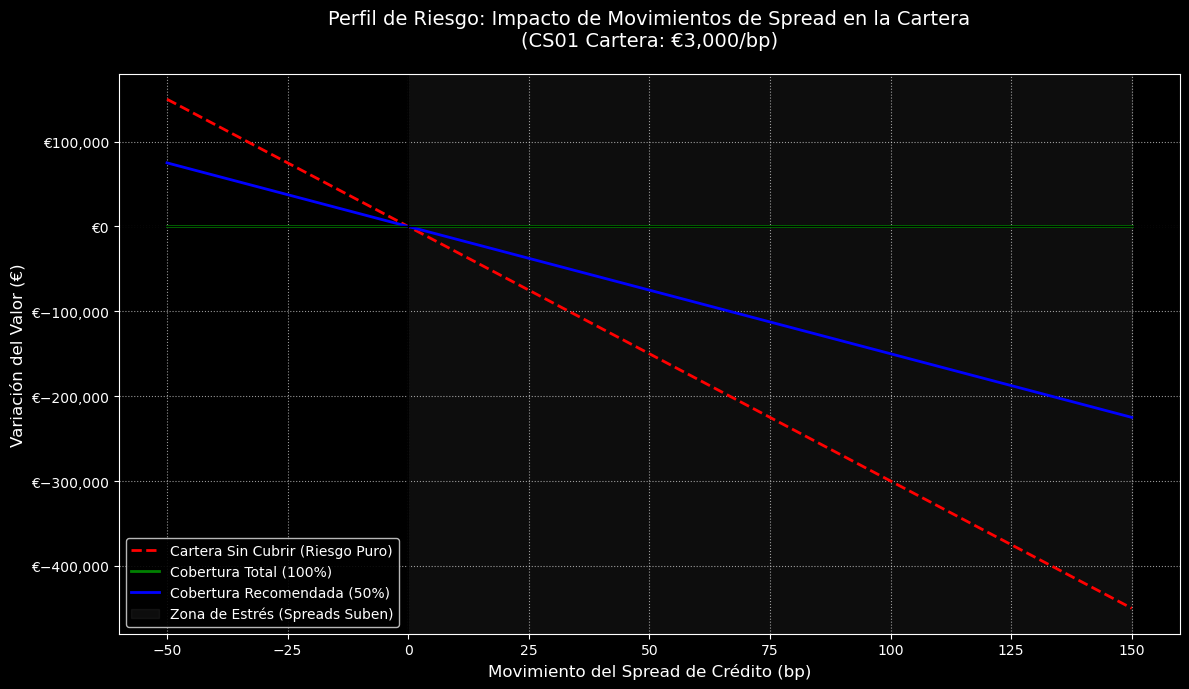


INTERPRETACIÓN DEL GRÁFICO:
1. LÍNEA ROJA (Sin Cubrir): Pendiente negativa fuerte. Si el spread sube 100bp, sufres una pérdida severa.
2. LÍNEA VERDE (Cobertura 100%): Línea casi plana. Eliminas el riesgo de mercado, pero también eliminas la ganancia si el mercado mejora (izquierda del 0).
3. LÍNEA AZUL (Cobertura 50%): Suaviza la pendiente. En caso de crisis, pierdes la mitad que sin cubrir. Si el mercado va bien, ganas la mitad.

NOTA: Este gráfico asume correlación perfecta. En la realidad, la línea verde oscilaría debido al 'Basis Risk'.


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ============================================================================
# VISUALIZACIÓN DEL PAYOFF DE LA ESTRATEGIA (ANÁLISIS DE ESCENARIOS)
# ============================================================================

print('='*80)
print('GENERANDO GRÁFICO DE ANÁLISIS DE ESCENARIOS...')
print('='*80)

# 1. Definir variables (Si no existen del bloque anterior, usamos valores simulados)
if 'cs01_cartera' not in globals():
    # Valores simulados basados en tu código anterior para que el ejemplo funcione solo
    cs01_cartera = 5000  # Ejemplo: €5,000 por bp
    nominal_cobertura_total = 10_000_000
    DV01_CDS_10M = 4500  # Sensibilidad del CDS

# Calcular la sensibilidad del Hedge (del CDS)
# DV01 total del CDS = (Nominal Cobertura / 10M) * DV01_per_10M
sensibilidad_hedge_100 = (nominal_cobertura_total / 10_000_000) * DV01_CDS_10M

# 2. Crear escenarios de movimiento de Spreads (Shock en puntos básicos)
# Simulamos desde una caída de spreads de -50bp hasta una subida fuerte de +150bp
shocks_bp = np.linspace(-50, 150, 100)

# 3. Calcular P&L (Profit & Loss) para cada escenario
# Cartera: Pierde dinero si los spreads suben (signo negativo)
pnl_cartera = -cs01_cartera * shocks_bp

# Cobertura (CDS): Gana dinero si los spreads suben (Long Protection)
pnl_hedge_total = sensibilidad_hedge_100 * shocks_bp
pnl_hedge_parcial = (sensibilidad_hedge_100 * 0.50) * shocks_bp # Ejemplo al 50%

# Portafolio Neto (Cartera + Hedge)
pnl_neto_total = pnl_cartera + pnl_hedge_total
pnl_neto_parcial = pnl_cartera + pnl_hedge_parcial

# 4. Configuración del Gráfico
plt.figure(figsize=(12, 7))

# Trazar líneas
plt.plot(shocks_bp, pnl_cartera, label='Cartera Sin Cubrir (Riesgo Puro)', color='red', linewidth=2, linestyle='--')
plt.plot(shocks_bp, pnl_neto_total, label='Cobertura Total (100%)', color='green', linewidth=2)
plt.plot(shocks_bp, pnl_neto_parcial, label='Cobertura Recomendada (50%)', color='blue', linewidth=2)

# Área de "Zona de Estrés" (Spreads subiendo)
plt.axvspan(0, 150, alpha=0.1, color='gray', label='Zona de Estrés (Spreads Suben)')

# Líneas de referencia
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

# Formato y Etiquetas
plt.title(f'Perfil de Riesgo: Impacto de Movimientos de Spread en la Cartera\n(CS01 Cartera: €{cs01_cartera:,.0f}/bp)', fontsize=14, pad=20)
plt.xlabel('Movimiento del Spread de Crédito (bp)', fontsize=12)
plt.ylabel('Variación del Valor (€)', fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.legend(loc='lower left', frameon=True, framealpha=0.9)

# Formatear eje Y en Euros
fmt = '€{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

plt.tight_layout()
plt.show()

# 5. Interpretación de texto
print("\nINTERPRETACIÓN DEL GRÁFICO:")
print("1. LÍNEA ROJA (Sin Cubrir): Pendiente negativa fuerte. Si el spread sube 100bp, sufres una pérdida severa.")
print("2. LÍNEA VERDE (Cobertura 100%): Línea casi plana. Eliminas el riesgo de mercado, pero también eliminas la ganancia si el mercado mejora (izquierda del 0).")
print("3. LÍNEA AZUL (Cobertura 50%): Suaviza la pendiente. En caso de crisis, pierdes la mitad que sin cubrir. Si el mercado va bien, ganas la mitad.")
print("\nNOTA: Este gráfico asume correlación perfecta. En la realidad, la línea verde oscilaría debido al 'Basis Risk'.")

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>